# Energy based models

Summary of my results for EBMs.

## General training results

I successfully managed to train EBMs, using SGLD sampling and the contrastive divergence-like algorithm proposed in [Du and Mordatch 2020](https://arxiv.org/abs/1903.08689). Some observations I noted during training:

* The noise/step-size hyperparameter is very important and can drastically influence convergence speed and training results.
* Sampling from the model, even after obtaining a very good energy function, is difficult, as one needs to choose appropriate values for the noise/step-size. Starting from datapoints might be a better approach than starting from random noise. Clipping gradients may be needed for very sharply peaked distributions.
* Finding a good, interpretable metric for the performance of the algorithm is not that easy; I settled on using kernel-density estimation (KDE) to estimate the data distribution (which is problematic due to the bandwidth parameter) and then using a PDF metric, namely the Jensen-Shannon distance, to measure goodness of fit. This was not very reliable due to the bandwidth parameter of the KDE however.
* It would probably be better to use a dataset-appropriate metric, rather than a PDF-based metric; for the pointsets sampled here, I could have used the Hausdorff distance, average pointset distance or Mahalobonis distance, rather than a distance between PDFs. KDE in high-dimensional spaces is more or less impossible anyway, so for images I will not use it.

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import tensorflow.keras as keras
import tensorflow_probability as tfp
import numpy as np
import scipy
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.utils import shuffle as util_shuffle
from functools import partial

## Langevin Monte Carlo and SGLD

Langevin Monte Carlo is a MCMC method for generating samples from a probability distribution. It is a special case of the class of Hamiltonian Monte Carlo (HMC) methods. It uses gradient information to move closer to the modes of the
energy function and Gaussian noise to improve mixing; intuitively, it first moves towards modes of the PDF, then, at the modes, the gradient shrinks and the noise dominates, enabling exploration of the probability landscape proportional to the probability mass assigned to each point, resulting in a stationary distribution that matches the normalized Boltzmann distribution defined by the energy function. LMC also includes a Metropolis acceptance step.

Stochastic Gradient Langevin Dynamics (SGLD) is similar to LMC, adapted to use stochastic gradients. It does not include a Metropolis acceptance step.
As SGLD is used for learning in EBMs, I implement and test it briefly below. I test it with an energy function defined by the negative log-probability of a PDF of a simple 1D Gaussian mixture model.

In [3]:
@tf.function
def sgld_sample(E, x_initial, num_steps, step_size, std_dev, clip_thresh=tf.constant(0.1)):
    """
    Do SGLD (stochastic gradient Langevin dynamics) sampling step
    :param E: Energy function
    :param x_initial: initial sample position, of shape (batch_size, ndims)
    :param num_steps: number of sampling steps
    :param step_size: step size used in gradient part
    :param std_dev: standard deviation for isotropic Gaussian used in update
    :param clip_thresh: threshold for gradient clipping; prevents energy gradients from growing too large
    :return: new sample
    """
    x_k = x_initial
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_k)
            energy = tf.math.reduce_sum(E(x_k))
        dE_dx = tf.clip_by_norm(g.gradient(energy, x_k), clip_thresh)
        x_k = x_k - (step_size / 2) * dE_dx + tf.random.normal(x_k.shape, mean=0.0, stddev=std_dev)
    return x_k

### Testing SGLD on a simple distribution

One can see that the SGLD update rule leads to the approximation of our mixture model.

Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


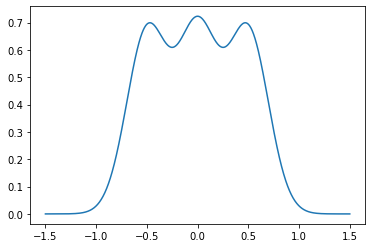

In [3]:
# Create a mixture of three Gaussians:
tfd = tfp.distributions
mix = 0.5
trimix_gauss = tfd.Mixture(
  cat=tfd.Categorical(probs=[0.333, 0.333, 0.333]),
  components=[
    tfd.Normal(loc=+0.5, scale=0.2),
    tfd.Normal(loc=-0.5, scale=0.2),
    tfd.Normal(loc=+0, scale=0.2),
])

@tf.function
def trimix_gauss_energy(x):
    return -tf.math.log(trimix_gauss.prob(x))

# Plot the PDF.
x = tf.linspace(-1.5, 1.5, 1000)
true_pdf = trimix_gauss.prob(x)
plt.plot(x, true_pdf)
    

In [4]:
batch_size = 1000
x_initial = tf.random.uniform((batch_size, 1), minval=-1, maxval=1)
lang_points = sgld_sample(trimix_gauss_energy, x_initial, tf.constant(25), tf.constant(0.05), tf.constant(0.05), batch_size)

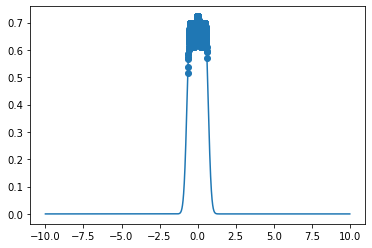

In [5]:
x = tf.linspace(-10., 10., int(1e4))
plt.plot(x, trimix_gauss.prob(x))
plt.scatter(lang_points, trimix_gauss.prob(lang_points))

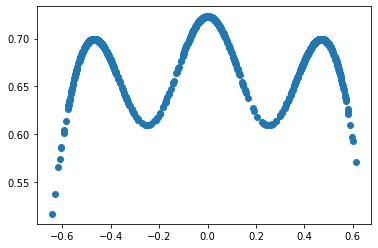

In [6]:
plt.scatter(lang_points, trimix_gauss.prob(lang_points))

We can use a kernel density estimator (KDE) to estimate the probability distribution between those points. We can see that they match quite well, though we would need more points to smooth out all noise.

C:\Users\chrku\anaconda3\envs\Python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

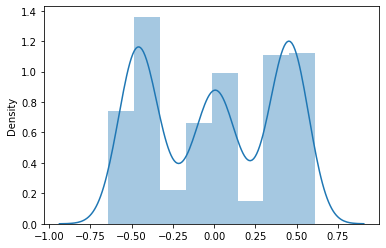

In [7]:
sns.distplot(lang_points)

## Using EBMs to model simple distributions

EBMs employ an energy function to model data distributions. Any energy function may be turned into a distribution by means
of the Boltzmann distribution; however, this require evaluating the partition function of the Boltzmann distribution, which is infeasible in higher dimensions. An alternative to evaluating the partition function is using sampling techniques to draw samples, as there are techniques (like SGLD used here) that do not require evaluating the partition function; this allows for generation of synthetic data given an energy function. The idea behind EBMs is to learn this energy function using maximum likelihood, using a neural network as an energy function and using SGLD to approximate the Boltzmann distribution.

I've tried using EBMs for estimating the distribution of toy-datasets based on sampling-based approaches, as was
demonstrated by [Du and Mordatch 2020](https://arxiv.org/abs/1903.08689). I modeled several toy datasets.

A class that implements EBM fitting is given below:

In [8]:
class EBM:
    def __init__(self, energy_fn, replay_buffer_size=10000):
        self.energy = energy_fn
        self.replay_buffer = []
        self.replay_buffer_ptr = 0
        self.replay_buffer_max = replay_buffer_size
    
    def sample_sgld(self, x_init, batch_size, num_steps_markov=tf.constant(25),
           step_size=tf.constant(10.0), std_dev=tf.constant(0.005), clip_thresh=tf.constant(0.01)):
        return sgld_sample(self.energy, x_init, num_steps_markov, step_size,
                           std_dev, clip_thresh=clip_thresh)


    def sample_replay_buffer(self, batch_size, uniform_bounds_lower, uniform_bounds_upper,
                             num_steps_markov=tf.constant(25), step_size=tf.constant(10.0),
                             std_dev=tf.constant(0.005), clip_thresh=tf.constant(0.01)):
        # Choose initial points, either from replay buffer or from uniform distribution
        # with bounds given by the user
        initial_points = []
        for _ in range(batch_size):
            prob_replay = np.random.uniform()
            if len(self.replay_buffer) < batch_size or prob_replay >= 0.95:
                x_k = np.random.uniform(uniform_bounds_lower, uniform_bounds_upper, (1, 2))
            else:
                x_k_index = np.random.choice(len(self.replay_buffer))
                x_k = tf.reshape(self.replay_buffer[x_k_index], (1, self.replay_buffer[x_k_index].shape[-1]))
            x_k = tf.convert_to_tensor(x_k, dtype=tf.float32)
            initial_points.append(x_k)
        initial_points = tf.concat(initial_points, 0)

        return sgld_sample(self.energy, initial_points, num_steps_markov, step_size,
                               std_dev, clip_thresh=clip_thresh)

    def _insert_into_replay_buffer(self, data, batch_size):
        for j in range(batch_size):
            if len(self.replay_buffer) <= self.replay_buffer_max:
                self.replay_buffer.append(tf.reshape(data[j], (1, data[j].shape[-1])))
            else:
                self.replay_buffer[self.replay_buffer_ptr] = tf.reshape(data[j], (1, data[j].shape[-1]))
            self.replay_buffer_ptr += 1
            if self.replay_buffer_ptr > self.replay_buffer_max - 1:
                self.replay_buffer_ptr = 0

    def fit(self, data, batch_size, num_epochs, optimizer, uniform_bounds_lower, uniform_bounds_upper,
            alpha=tf.constant(0.1), num_steps_markov=tf.constant(25), step_size=tf.constant(10.0),
            std_dev=tf.constant(0.005), clip_thresh=tf.constant(0.01), callbacks_energy=[]):
        # Get number of training examples
        n_train = data.shape[0]
        inner_loop_iterations = n_train // batch_size

        # Create dataset sampler
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.shuffle(buffer_size=n_train)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset_iterator = iter(dataset)

        for epoch in range(num_epochs):
            print("Epoch {}: 000.00%".format(epoch))

            num_samples_processed = 0

            used_std_dev = std_dev
            if callable(std_dev):
                used_std_dev = std_dev(epoch)

            for i in range(inner_loop_iterations):
                avg_abs_diff_energies_data_sample = 0.0
                # Sample from data distribution
                sample_data_dist = next(dataset_iterator)

                # Sample from energy function
                sample_energy_dist = self.sample_replay_buffer(batch_size, uniform_bounds_lower, uniform_bounds_upper,
                                                               num_steps_markov=num_steps_markov, step_size=step_size,
                                                               std_dev=used_std_dev, clip_thresh=clip_thresh)
                self._insert_into_replay_buffer(sample_energy_dist, batch_size)

                # Compute parameter gradients
                with tf.GradientTape() as g:
                    energies_data = self.energy(sample_data_dist, training=True)
                    energies_samples = self.energy(sample_energy_dist, training=True)
                    energy_data = tf.math.reduce_mean(energies_data)
                    energy_samples = tf.math.reduce_mean(energies_samples)
                    energies_l2 = tf.math.reduce_mean(tf.square(energies_data)) + \
                                  tf.math.reduce_mean(tf.square(energies_samples))
                    energy = energy_data - energy_samples + alpha * energies_l2
                gradient = g.gradient(energy, self.energy.trainable_variables)

                # Apply gradients
                optimizer.apply_gradients(zip(gradient, self.energy.trainable_variables))

                # Report epoch progress, compute metrics
                avg_abs_diff_energies_data_sample += (1 / inner_loop_iterations) * \
                                                     (tf.abs(energy_data - energy_samples)).numpy()

                num_samples_processed += batch_size
                progress = num_samples_processed / n_train

                print("Epoch progress: {:06.2f}%".format(progress * 100.0))
                # Print progress metric
                print("Average absolute energy difference between training and test examples: {}"
                      .format(avg_abs_diff_energies_data_sample))
            for callbacks_name, callback_fn in callbacks_energy:
                print(callbacks_name, callback_fn(self.energy))

### Visualization

To visualize PDFs and energy landscapes, I use contour plots.

In [9]:
def create_contour_plot(f, transpose=False):
    num_points = 250
    x_surface = np.linspace(-3, 3, num_points)
    y_surface = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x_surface, y_surface)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    if transpose:
        Z = f(combined.T)
    else:
        Z = f(combined)
    plt.contourf(X, Y, Z.reshape(X.shape), levels=20)
    plt.colorbar()
    plt.show()
    return Z

In [10]:
def create_contour_plot_tensorflow(E):
    num_points = 250
    x_surface = np.linspace(-3, 3, num_points)
    y_surface = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x_surface, y_surface)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    combined = tf.convert_to_tensor(combined, dtype=tf.float32)
    Z = E(combined).numpy()
    plt.contourf(X, Y, Z.reshape(X.shape), levels=20)
    plt.colorbar()
    plt.show()

### Evaluation

A quantitative way to estimate the similarity of two PDFs can be realized by using a distance metric for PDFs.
I use the Jensen-Shannon distance for this. It is closely related to the Kullback-Leiber divergence, but it is a true distance metric and it is bounded to the interval \[-1, 1\].

In [11]:
def jensen_shannon_distance_kde(energy, pdf_kde):
    num_points = 250
    x = np.linspace(-3, 3, num_points)
    y = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x, y)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    combined = tf.convert_to_tensor(combined, dtype=tf.float32)
    Z = np.exp(-energy(combined).numpy().reshape(num_points, num_points))
    partition = np.sum(Z)
    pdf = Z / partition
    return scipy.spatial.distance.jensenshannon(pdf.flatten(), pdf_kde.flatten())

### PDF of data distribution

To evaluate the fit of our EBMs, it would be very useful to have the PDF for the data distribution of this dataset. However, the PDF here is unfortunately not available. I therefore use a 2D kernel-density estimator (KDE) to get an estimated PDF.

In [12]:
def make_pdf_data(data, bw_method=0.15):
    kernel = scipy.stats.gaussian_kde(data.T, bw_method=bw_method)
    pdf_kde = create_contour_plot(kernel, transpose=True)
    pdf_kde = pdf_kde / pdf_kde.sum()
    return pdf_kde

### PDF of energy function

I also evaluate the partition function and create a PDF for visualization by using the Boltzmann distribution, which is possible
in 2D.

In [13]:
def make_pdf_energy(E):
    num_points = 250
    x = np.linspace(-3, 3, num_points)
    y = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x, y)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    combined = tf.convert_to_tensor(combined, dtype=tf.float32)
    Z = np.exp(-E(combined).numpy().reshape(num_points, num_points))
    partition = np.sum(Z)
    pdf = Z / partition
    plt.contourf(X, Y, pdf.reshape(X.shape), levels=1000)
    plt.colorbar()
    return pdf

### Toy dataset: 2D swiss roll

This is the first dataset I aim to model with EBMs. I plot it below, using the $\alpha$-channel to showcase the density of the points.

In [14]:
# Generate swiss roll data
def generate_swiss_roll(batch_size):
    data = sklearn.datasets.make_swiss_roll(n_samples=batch_size, noise=1.0)[0]
    data = data.astype("float32")[:, [0, 2]]
    data /= 5
    return data

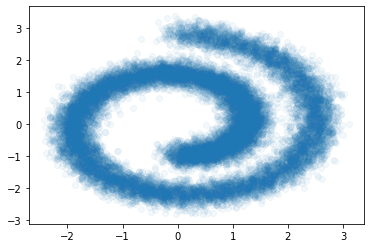

In [15]:
swiss_roll_train = generate_swiss_roll(20000)
plt.scatter(swiss_roll_train[:, 0], swiss_roll_train[:, 1], alpha=0.05)

I visualized the estimated PDF below:

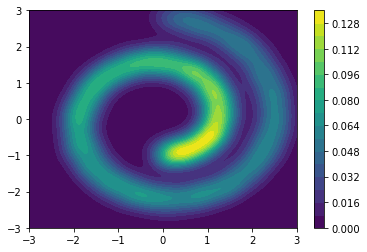

In [16]:
pdf_kde = make_pdf_data(swiss_roll_train)

This is the energy function I will use. I have found that it helps for the model to have some capacity to learn the shapes of the PDFs.

In [17]:
input_ = keras.layers.Input(shape=swiss_roll_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
swiss_roll_model = keras.Model(inputs=[input_], outputs=[output])

#### Network training

For the optimizer, I chose Adam with a learning rate of 0.001.

In [18]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(swiss_roll_model)

In [19]:
ebm.fit(swiss_roll_train, 128, 15, optimizer, [-4, -4], [4, 4], num_steps_markov=tf.constant(10),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 4.422040178607671e-05
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0024847720678036027
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.0037583601780426805
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0035830759085141695
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.00417091028812604
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.004876304131287795
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.00445597217633174
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0034682930280000735
Epoch progress: 005.76%
Average absolute energy diff

Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.015823116669288047
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.01675882706275353
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.017331866117624134
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.01782687810751108
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.01743476513104561
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.014323182595081817
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.01566116473613641
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.019785934533828344
Epoch progress: 051.20%
Average absolute energy difference between training 

Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.018023607058402818
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.01702699600121914
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.01937179534863203
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.019282473967625544
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.01631469909961407
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.017746897844167855
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.021740447252224654
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.01989268645262107
Epoch progress: 096.64%
Average absolute energy difference between training 

Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.019051120831416204
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.019466253427358773
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.01993120633638822
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.01882872978846232
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.01884884100693923
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.019185015788445104
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.01798563125805977
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.020140858796926644
Epoch progress: 042.24%
Average absolute energy difference between training 

Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.019248485565185547
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.02099322661375388
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.018909695820930675
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.020127897079174336
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.016995193102420904
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.026644382721338514
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.021854437314547025
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.020368932149349116
Epoch progress: 088.32%
Average absolute energy difference between traini

Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.01599744650033804
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.019507444821871243
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.020711088791871682
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.020376564600528814
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.020142802825340856
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.022670640395237848
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.01882869310868092
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.022708602440662872
Epoch progress: 034.56%
Average absolute energy difference between trainin

Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.020046622325212527
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.020259493436568823
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.021548280349144567
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.01876684029897054
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.019879567317473583
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.02045004490094307
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.018647303948035605
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.02348945385370499
Epoch progress: 080.64%
Average absolute energy difference between training

Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.020072907973558474
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.017362423432178985
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.020789675223521698
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.01942000327966152
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.0204355518023173
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.019306476299579326
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.021681889509543393
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.021410648639385518
Epoch progress: 026.88%
Average absolute energy difference between training

Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.02154609637382703
Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.02147771303470318
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.022729688729995336
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.02056264265989646
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.022577979625799716
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.020602247653863367
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.020946242870428622
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.022126696048638757
Epoch progress: 072.96%
Average absolute energy difference between training

Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.02212984133989383
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.022722990084917117
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.02379479775061974
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.024953214021829456
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.02224279672671587
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.025399687962654308
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.025750349729489058
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.0230104128519694
Epoch progress: 019.20%
Average absolute energy difference between training a

Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.023489132905617736
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.020389437675476074
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.02060411220941788
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.022143079684330866
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.023872216542561848
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.028995831807454426
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.01926875114440918
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.025909943458361503
Epoch progress: 065.28%
Average absolute energy difference between trainin

Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.0259175147765722
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.026494756723061584
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.025317892050131772
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.02500834678992247
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.02380292385052412
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.02727397282918294
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.024080469058110163
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.025462720638666395
Epoch progress: 012.16%
Average absolute energy difference between training a

Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.02195606170556484
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.02377189428378374
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.02527358287420028
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.02907714782617031
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.02538993572577452
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.024623980888953574
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.022887339958777793
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.024825583665798873
Epoch progress: 058.24%
Average absolute energy difference between training a

Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.027358434139153894
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.028885425665439703
JSD 0.29889871210191554
Epoch 6: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.025935937196780473
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.028249590824811887
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.023129351628132355
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.022782348669492282
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.024026190623258933
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.024700927428710155
Epoch progress: 004.48%
Average

Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.024158774278102778
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.02581059627043895
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.02575081739670191
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.02858763474684495
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.027572118318997897
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.025893596502450794
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.027935529366517678
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.027369376940604966
Epoch progress: 050.56%
Average absolute energy difference between training

Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.023061767602578186
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.024407140719584927
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.02472568475283109
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.021915778135642026
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.02570197521111904
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.023502258154062122
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.02709826139303354
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.027598179303682767
Epoch progress: 096.64%
Average absolute energy difference between training

Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.025925642404800806
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.026151409515967734
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.029192013618273612
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.023988175086486034
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.03066087991763384
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.026575357486040164
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.024405071368584264
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.028860819645417042
Epoch progress: 042.88%
Average absolute energy difference between traini

Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.02810950156969902
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.02731007490402613
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.028250082945212338
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.029646274371024888
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.028363692454802684
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.027567319380931363
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.02898548199580266
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.030775253589336686
Epoch progress: 088.96%
Average absolute energy difference between training

Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.031202053412412986
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.027919812080187675
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.02743424513401129
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.024111509323120117
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.02980347168751252
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.027704553726391915
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.028043169241685133
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.029058376948038735
Epoch progress: 035.20%
Average absolute energy difference between trainin

Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.02910018272888966
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.03206676703232985
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.028908374982002452
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.02779388427734375
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.02976203576112405
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0298616763872978
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.020978692250374034
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.02501605871396187
Epoch progress: 081.28%
Average absolute energy difference between training and

Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.02922709171588604
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.0342255739065317
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.03012820390554575
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.03417845872732309
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.030116551961654272
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.025754396732036885
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.02886958305652325
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.02698807227305877
Epoch progress: 027.52%
Average absolute energy difference between training and

Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.03215515002226218
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.030284961064656574
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.02633822269928761
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.030481693072196763
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.02941908897497715
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.02628081884139623
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.02899798063131479
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.03219328171167618
Epoch progress: 073.60%
Average absolute energy difference between training an

Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.030997640047317896
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.028467991413214266
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.026374052732418746
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.03096212484897711
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.02846731283725836
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.028793747608478252
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.029107164113949507
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.03137708321595803
Epoch progress: 019.84%
Average absolute energy difference between training

Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.030446590521396734
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.03178953513120993
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.03391075134277344
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.027946985684908353
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.029499429922837477
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.027628537936088365
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.028774108642186873
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.030789934671842135
Epoch progress: 065.92%
Average absolute energy difference between trainin

Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.03045352911337828
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.03207097909389398
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.0291902101956881
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.026114650261707794
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.03328704222654685
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.028542102911533453
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.0288471778233846
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.028816785567846052
Epoch progress: 012.16%
Average absolute energy difference between training and

Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.03266337284675011
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.030591545960842032
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.032576701579949796
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.03178046299861027
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.03101513935969426
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.025919541334494565
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.030254669678516876
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.027379677845881533
Epoch progress: 058.24%
Average absolute energy difference between training

Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.030602699671036158
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.03249940505394569
JSD 0.29455640034068714
Epoch 12: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.03349502575703156
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.03297313665732359
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.03251205957852877
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.03138905916458521
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.03351681660383175
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.030084940103384163
Epoch progress: 004.48%
Average abso

Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.029836700512812685
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.031636760785029486
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.033762406080197066
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.03041558693616818
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.028377380126561873
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.027778325936733145
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.03176519503960243
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.031232136946458083
Epoch progress: 050.56%
Average absolute energy difference between trainin

Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.030269531103280872
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.031110467054905035
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.029452990262936324
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.03456668670360859
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.025899663949624084
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.026445214564983662
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.02876901015257224
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.026917365881112904
Epoch progress: 096.00%
Average absolute energy difference between trainin

Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.0314023983784211
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.02976515965583997
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.02785975505144168
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.029188908063448392
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.02880432972541222
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.030726105738908816
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.028544902801513672
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.032215696114760176
Epoch progress: 042.24%
Average absolute energy difference between training a

Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.02918428335434351
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.028209203328841772
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.027985077637892503
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.03108956263615535
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.029190589220095903
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.034313923273331076
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.02738845654022999
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.027665028205284704
Epoch progress: 088.32%
Average absolute energy difference between training

Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.032860902639535755
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.031662788146581404
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.028297830850650102
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.02824107194558168
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.03206850626529791
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.031387925148010254
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.028900877023354553
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.030455995828677446
Epoch progress: 034.56%
Average absolute energy difference between trainin

Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.03159398298997145
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.032135040332109496
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.032614549001057945
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.033361208744538136
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.03135542686168964
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.029603209251012556
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.026536091780051205
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.027075944802699942
Epoch progress: 080.64%
Average absolute energy difference between trainin

#### Visualizing the energy function

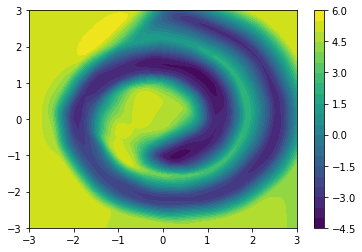

In [20]:
create_contour_plot_tensorflow(swiss_roll_model)

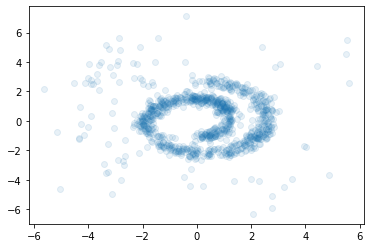

In [21]:
# Sample and plot some points
batch_size = 1000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(swiss_roll_model, x_init, tf.constant(50), 150, 0.2, clip_thresh=tf.constant(0.1))
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

#### Visualizing the PDF defined by the energy function

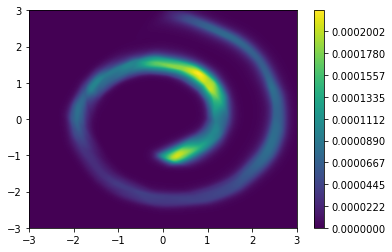

In [22]:
pdf = make_pdf_energy(swiss_roll_model)

In [23]:
scipy.spatial.distance.jensenshannon(pdf.flatten(), pdf_kde.flatten())

0.3049222297743985

### Toy dataset: Circles

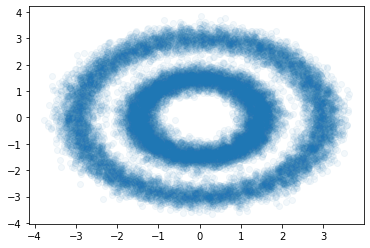

In [24]:
n_train = 20000
circles_train = sklearn.datasets.make_circles(n_samples=n_train, factor=.5, noise=0.08)[0]
circles_train = circles_train.astype("float32")
circles_train *= 3
plt.scatter(circles_train[:, 0], circles_train[:, 1], alpha=0.05)

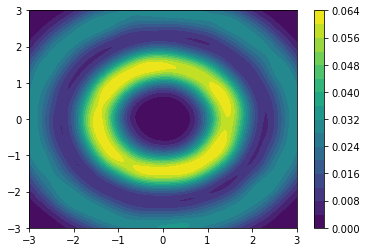

In [25]:
pdf_kde = make_pdf_data(circles_train)

#### Energy function and training

In [26]:
input_ = keras.layers.Input(shape=circles_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
circles_model = keras.Model(inputs=[input_], outputs=[output])

In [27]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(circles_model)

In [28]:
ebm.fit(circles_train, 128, 15, optimizer, [-4, -4], [4, 4], num_steps_markov=tf.constant(10),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 6.329581045951598e-05
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0018008859493793584
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.003384025815205696
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0026877113641836704
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.0027644714483847986
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.002570976049472124
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.0025946366099210885
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0020566949477562537
Epoch progress: 005.76%
Average absolute energy d

Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.00924744819983458
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.010653664668401081
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.014522839815188676
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.014373180193778796
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.01298678226960011
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.012868682543436686
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.010841566782731276
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.011112304070057012
Epoch progress: 051.84%
Average absolute energy difference between trainin

Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.01047790126922803
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.012094623003250513
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.011366680646554017
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.011126813980249258
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.0102044573196998
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.008673946062723795
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.013466697472792406
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.010513959786830803
Epoch progress: 097.92%
Average absolute energy difference between training

Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.009700665107140174
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.009900074738722581
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.009589300705836369
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.007507250859187199
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.008930916205430642
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.008448718450008294
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.010943995072291447
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.009021457953330798
Epoch progress: 044.16%
Average absolute energy difference between train

Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.01278304289548825
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.0115587191703992
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.010935382965283515
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.011865372077012673
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.010621148806351881
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.010410808599912202
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.009615872150812393
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.011039492411491198
Epoch progress: 090.24%
Average absolute energy difference between training

Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.010219537294827974
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.010173030388660919
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.008673608303070068
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.011218072512210943
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.008579983161045954
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.01031177548261789
Epoch progress: 035.20%
Average absolute energy difference between training and test examples: 0.011107935355259821
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.01263313950636448
Epoch progress: 036.48%
Average absolute energy difference between trainin

Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.010746344541892027
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.010575560423044058
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.011339450493837014
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.011406917602587968
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.010252918952550644
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.00879733226238153
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.010075570681156255
Epoch progress: 081.28%
Average absolute energy difference between training and test examples: 0.009174837515904352
Epoch progress: 081.92%
Average absolute energy difference between traini

Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.01074281869790493
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.010498362473952465
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.012345210099831605
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.009570138576703193
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.009969569169558011
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.012286035678325554
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.011358980949108416
Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.011166387643569555
Epoch progress: 028.16%
Average absolute energy difference between traini

Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.01006702734873845
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.009308740114554381
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.012672344843546549
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.013674467037885616
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.011621295641630124
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.010790921174562894
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.008975372864649845
Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.010522007178037595
Epoch progress: 074.24%
Average absolute energy difference between traini

Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.013046596294794327
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.01009912521411211
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.010520317615606846
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.011325347882050734
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.009810226085858466
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.011694791989448743
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.013082119134756235
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.011326783742660131
Epoch progress: 020.48%
Average absolute energy difference between traini

Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.010650893052419026
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.011303466099959154
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.012068519225487342
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.012665118162448589
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.011993391391558524
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.012789406837561192
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.012022662621278029
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.014608944073701516
Epoch progress: 066.56%
Average absolute energy difference between train

Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.014067040039942814
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.01323712177765675
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.01079701765989646
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.013727952272464067
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.014913994532365065
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.01565615488932683
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.013236522674560547
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.013303475502209785
Epoch progress: 012.80%
Average absolute energy difference between training

Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.012270777653425166
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.011982946059642693
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.011869630752465664
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.013781226598299466
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.01314315887597891
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.014122221714411026
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.01498115979708158
Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.014248044062883426
Epoch progress: 058.88%
Average absolute energy difference between trainin

Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.012561198228444807
JSD 0.24469372183818294
Epoch 6: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.01872281233469645
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.01733258137336144
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.016357544140938
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.01721031543536064
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.017411507092989408
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.0123139161330003
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.01405940911708734
Epoch progress: 005.12%
Average absolute

Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.014096440413059332
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.015012181722200833
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.01490322748819987
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.01688598516659859
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.010065512779431464
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.014456891096555268
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.011086129225217378
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.012601921191582313
Epoch progress: 050.56%
Average absolute energy difference between trainin

Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.01228105563383836
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.01619787858082698
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.0155488222073286
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.015084037413963905
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.017062855072510548
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.014745159026903983
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.013904991822365003
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.01491266947526198
Epoch progress: 096.64%
Average absolute energy difference between training a

Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.013241459161807329
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.013807331904386863
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.017073350074963693
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.014201038923019018
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.012004538224293634
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.017157881687848996
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.013550770588410206
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.015720718946212377
Epoch progress: 042.88%
Average absolute energy difference between train

Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.01868101266714243
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.017208096308585923
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.014363747376662035
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.014066662543859236
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.018024187821608324
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.015353373992137419
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.016651520362267126
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.013582241840851612
Epoch progress: 088.32%
Average absolute energy difference between traini

Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.018941717270093087
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.01793735608076438
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.01531305832740588
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.015614890135251558
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.016005638318184093
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.01764133496162219
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.016523486528641138
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.016434483039073456
Epoch progress: 034.56%
Average absolute energy difference between training

Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.017918968812013283
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.015032221109439164
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.019188491197732777
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.017856539824070074
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.015420216780442458
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.0184479982425005
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.022115655434437286
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.01882398587006789
Epoch progress: 080.64%
Average absolute energy difference between training

Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.017418491534697704
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.019952838237469014
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.019922273281293038
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.018375656543633875
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.018358039550292186
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.019731046297611333
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.020809742120596077
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.022399040368887093
Epoch progress: 026.88%
Average absolute energy difference between train

Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.01880201620933337
Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.017221802320235815
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.01962571877699632
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.015039813824189015
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.018950636570270244
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.017987783138568584
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.017487886624458507
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.018886364423311673
Epoch progress: 072.96%
Average absolute energy difference between trainin

Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.01869676663325383
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.020140048785087388
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.01989910847101456
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.018662121051397078
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.021769170577709492
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.0169522273234832
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.017099507344074737
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.016549836366604537
Epoch progress: 019.20%
Average absolute energy difference between training 

Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.022165897565010265
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.02141906664921687
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.021426361340742845
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.018546214470496543
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.02012814008272611
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.015067986952952849
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.02049988355392065
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.018676308485177845
Epoch progress: 065.28%
Average absolute energy difference between training

Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.019781039311335635
Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.016985714435577393
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.018302547626006298
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.017526978101485815
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.02137219141691159
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.01925339148594783
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.02093500663072635
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.018182213489825908
Epoch progress: 011.52%
Average absolute energy difference between training

Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.018487389271075908
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.0181312423485976
Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.019627023965884477
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.01836188787069076
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.02030823475275284
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.019669181261307154
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.016801979297246687
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.01705706883699466
Epoch progress: 056.96%
Average absolute energy difference between training a

Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.022153950654543363
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.01942019584851387
Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.02014457568144187
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.01933573453854292
JSD 0.2983801550800564
Epoch 12: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.01597657111974863
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.01901744267879388
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.018201296146099385
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.018379663809751853
Epoch progress: 003.20%
Average abso

Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.019553808065561146
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.019332587718963623
Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.02263324994307298
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.019931949101961575
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.02250878016153971
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.019070677268199433
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.019518439586345967
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.022043209809523363
Epoch progress: 049.28%
Average absolute energy difference between trainin

Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.021656131133055076
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.021632967851100825
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.02338604132334391
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.02157452167608799
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.020073471925197504
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.020887099779569186
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.02245162694882124
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.021038460425841503
Epoch progress: 095.36%
Average absolute energy difference between training

Epoch progress: 036.48%
Average absolute energy difference between training and test examples: 0.020016986590165358
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.025203940195915025
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.015963831009008944
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.0188371860063993
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.02056261820670886
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.023371305221166365
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.017870224439180814
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.020921930288657162
Epoch progress: 041.60%
Average absolute energy difference between training

Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.019135126700768102
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.014993617167839637
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.018450240294138588
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.02131194640428592
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.018940265362079326
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.022040648338122245
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.019396467086596366
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.019949780060694765
Epoch progress: 087.68%
Average absolute energy difference between traini

Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.019705483546623815
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.017809577477283966
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.02606989787175105
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.021692326435675986
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.022429637419871792
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.018647955014155462
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.019418311424744435
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.020358493694892295
Epoch progress: 033.92%
Average absolute energy difference between traini

Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.020490867969317313
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.021125683417687047
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.020458276455218975
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.01668632794649173
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.01946917711160122
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.01636685774876521
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.01736688155394334
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.019013212277339056
Epoch progress: 080.00%
Average absolute energy difference between training 

In [29]:
batch_size = 1000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)

In [30]:
sample = sgld_sample(circles_model, x_init, tf.constant(50), 150, 0.2, clip_thresh=tf.constant(0.1))

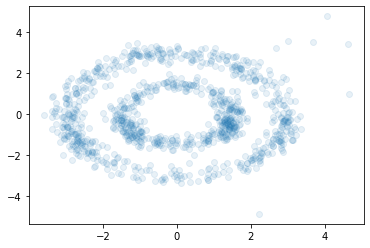

In [31]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

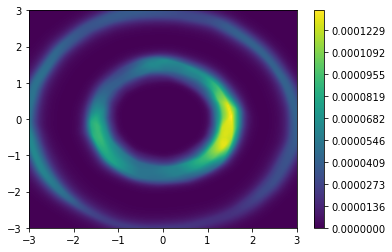

In [32]:
pdf = make_pdf_energy(circles_model)

In [33]:
scipy.spatial.distance.jensenshannon(pdf.flatten(), pdf_kde.flatten())

0.29489473334755184

### Rings dataset

In [34]:
n_train = 100000
rng = np.random.RandomState()
obs = n_train
n_train = n_train * 20
n_samples4 = n_samples3 = n_samples2 = n_train // 4
n_samples1 = n_train - n_samples4 - n_samples3 - n_samples2

# So as not to have the first point = last point, we set endpoint=False
linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

circ4_x = np.cos(linspace4)
circ4_y = np.sin(linspace4)
circ3_x = np.cos(linspace4) * 0.75
circ3_y = np.sin(linspace3) * 0.75
circ2_x = np.cos(linspace2) * 0.5
circ2_y = np.sin(linspace2) * 0.5
circ1_x = np.cos(linspace1) * 0.25
circ1_y = np.sin(linspace1) * 0.25

X = np.vstack([
    np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
    np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
]).T * 3.0
X = util_shuffle(X, random_state=rng)

# Add noise
X = X + rng.normal(scale=0.08, size=X.shape)
inds = np.random.choice(list(range(n_train)), obs)
X = X[inds]
rings_train = X.astype("float32")

(100000, 2)

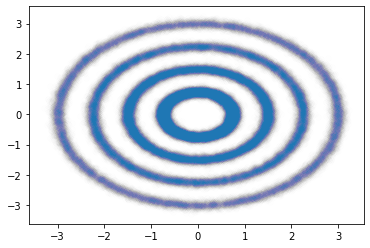

In [35]:
plt.scatter(rings_train[:, 0], rings_train[:, 1], alpha=0.005)
rings_train.shape

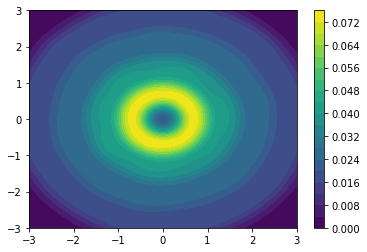

In [36]:
kernel = scipy.stats.gaussian_kde(rings_train.T, bw_method=0.2)
pdf_kde = create_contour_plot(kernel, transpose=True)
pdf_kde = pdf_kde / pdf_kde.sum()

#### Energy function and training

In [37]:
input_ = keras.layers.Input(shape=rings_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
rings_model = keras.Model(inputs=[input_], outputs=[output])

In [38]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(rings_model)

In [39]:
ebm.fit(rings_train, 128, 20, optimizer, [-4, -4], [4, 4], num_steps_markov=tf.constant(10),
        std_dev=0.01, step_size=0.01, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 000.13%
Average absolute energy difference between training and test examples: 2.517273575639908e-05
Epoch progress: 000.26%
Average absolute energy difference between training and test examples: 0.0005450461646506179
Epoch progress: 000.38%
Average absolute energy difference between training and test examples: 0.0006548508181309424
Epoch progress: 000.51%
Average absolute energy difference between training and test examples: 0.0008088631147611766
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.0006596223950843958
Epoch progress: 000.77%
Average absolute energy difference between training and test examples: 0.0005516377057064511
Epoch progress: 000.90%
Average absolute energy difference between training and test examples: 0.0003240187861092112
Epoch progress: 001.02%
Average absolute energy difference between training and test examples: 0.0004942227493632923
Epoch progress: 001.15%
Average absolute energy

Epoch progress: 009.09%
Average absolute energy difference between training and test examples: 0.003045766515402116
Epoch progress: 009.22%
Average absolute energy difference between training and test examples: 0.002690262434271936
Epoch progress: 009.34%
Average absolute energy difference between training and test examples: 0.0028070298413461056
Epoch progress: 009.47%
Average absolute energy difference between training and test examples: 0.0031115260838546458
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.0028277841633932233
Epoch progress: 009.73%
Average absolute energy difference between training and test examples: 0.0029318164771711323
Epoch progress: 009.86%
Average absolute energy difference between training and test examples: 0.002657518496739269
Epoch progress: 009.98%
Average absolute energy difference between training and test examples: 0.002073519971703445
Epoch progress: 010.11%
Average absolute energy difference between t

Epoch progress: 018.30%
Average absolute energy difference between training and test examples: 0.0027898157757161976
Epoch progress: 018.43%
Average absolute energy difference between training and test examples: 0.002783352525835611
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.002792711905114324
Epoch progress: 018.69%
Average absolute energy difference between training and test examples: 0.003215060496605007
Epoch progress: 018.82%
Average absolute energy difference between training and test examples: 0.0030630932269419963
Epoch progress: 018.94%
Average absolute energy difference between training and test examples: 0.0033214556270311185
Epoch progress: 019.07%
Average absolute energy difference between training and test examples: 0.0031142537022980166
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.003093246919092234
Epoch progress: 019.33%
Average absolute energy difference between t

Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.0032266807311933567
Epoch progress: 027.65%
Average absolute energy difference between training and test examples: 0.0034471333561114557
Epoch progress: 027.78%
Average absolute energy difference between training and test examples: 0.0036503728312200527
Epoch progress: 027.90%
Average absolute energy difference between training and test examples: 0.003015397605456402
Epoch progress: 028.03%
Average absolute energy difference between training and test examples: 0.003502064874627068
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.003618836250256332
Epoch progress: 028.29%
Average absolute energy difference between training and test examples: 0.0029573080329064676
Epoch progress: 028.42%
Average absolute energy difference between training and test examples: 0.0029373034624986245
Epoch progress: 028.54%
Average absolute energy difference between 

Epoch progress: 036.74%
Average absolute energy difference between training and test examples: 0.0027377220793661783
Epoch progress: 036.86%
Average absolute energy difference between training and test examples: 0.0033492999253901872
Epoch progress: 036.99%
Average absolute energy difference between training and test examples: 0.0036394724314710394
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.003457367038604697
Epoch progress: 037.25%
Average absolute energy difference between training and test examples: 0.003487930407750011
Epoch progress: 037.38%
Average absolute energy difference between training and test examples: 0.0027637976232472517
Epoch progress: 037.50%
Average absolute energy difference between training and test examples: 0.003126965289537183
Epoch progress: 037.63%
Average absolute energy difference between training and test examples: 0.0035581716959974066
Epoch progress: 037.76%
Average absolute energy difference between 

Epoch progress: 045.95%
Average absolute energy difference between training and test examples: 0.0031519748184653464
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.0033609137492356927
Epoch progress: 046.21%
Average absolute energy difference between training and test examples: 0.00387680332120341
Epoch progress: 046.34%
Average absolute energy difference between training and test examples: 0.003767993477639407
Epoch progress: 046.46%
Average absolute energy difference between training and test examples: 0.003791107563600039
Epoch progress: 046.59%
Average absolute energy difference between training and test examples: 0.0033271138707745853
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.0032126906586670235
Epoch progress: 046.85%
Average absolute energy difference between training and test examples: 0.003389147881814368
Epoch progress: 046.98%
Average absolute energy difference between tr

Epoch progress: 055.17%
Average absolute energy difference between training and test examples: 0.003553542223843661
Epoch progress: 055.30%
Average absolute energy difference between training and test examples: 0.0036660364129021284
Epoch progress: 055.42%
Average absolute energy difference between training and test examples: 0.0029285521879696816
Epoch progress: 055.55%
Average absolute energy difference between training and test examples: 0.0028422834320654482
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.00316063481622713
Epoch progress: 055.81%
Average absolute energy difference between training and test examples: 0.0038913801293367
Epoch progress: 055.94%
Average absolute energy difference between training and test examples: 0.003484367561096113
Epoch progress: 056.06%
Average absolute energy difference between training and test examples: 0.003678568499341664
Epoch progress: 056.19%
Average absolute energy difference between train

Epoch progress: 064.38%
Average absolute energy difference between training and test examples: 0.003207309297959722
Epoch progress: 064.51%
Average absolute energy difference between training and test examples: 0.0033198071502998144
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.004058701433384464
Epoch progress: 064.77%
Average absolute energy difference between training and test examples: 0.00397463614137774
Epoch progress: 064.90%
Average absolute energy difference between training and test examples: 0.0037442615181780044
Epoch progress: 065.02%
Average absolute energy difference between training and test examples: 0.004267676996971062
Epoch progress: 065.15%
Average absolute energy difference between training and test examples: 0.004338912866179677
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.0031300757209103787
Epoch progress: 065.41%
Average absolute energy difference between tra

Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.002836982053006962
Epoch progress: 073.73%
Average absolute energy difference between training and test examples: 0.0036824784419295423
Epoch progress: 073.86%
Average absolute energy difference between training and test examples: 0.0029609652090622123
Epoch progress: 073.98%
Average absolute energy difference between training and test examples: 0.0030317816325247516
Epoch progress: 074.11%
Average absolute energy difference between training and test examples: 0.003248540753744323
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.003154987562328539
Epoch progress: 074.37%
Average absolute energy difference between training and test examples: 0.0034894186159102163
Epoch progress: 074.50%
Average absolute energy difference between training and test examples: 0.0032450795631555223
Epoch progress: 074.62%
Average absolute energy difference between 

Epoch progress: 082.82%
Average absolute energy difference between training and test examples: 0.003510675112813444
Epoch progress: 082.94%
Average absolute energy difference between training and test examples: 0.003091279736859545
Epoch progress: 083.07%
Average absolute energy difference between training and test examples: 0.003274055510263284
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.003550063632667141
Epoch progress: 083.33%
Average absolute energy difference between training and test examples: 0.0027581286949323785
Epoch progress: 083.46%
Average absolute energy difference between training and test examples: 0.0031862600817417824
Epoch progress: 083.58%
Average absolute energy difference between training and test examples: 0.002696366682553261
Epoch progress: 083.71%
Average absolute energy difference between training and test examples: 0.0032328094013521825
Epoch progress: 083.84%
Average absolute energy difference between tr

Epoch progress: 092.03%
Average absolute energy difference between training and test examples: 0.002753761452688298
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.0035289961000410756
Epoch progress: 092.29%
Average absolute energy difference between training and test examples: 0.0035782104570337508
Epoch progress: 092.42%
Average absolute energy difference between training and test examples: 0.0032320956719822215
Epoch progress: 092.54%
Average absolute energy difference between training and test examples: 0.0036992660405235924
Epoch progress: 092.67%
Average absolute energy difference between training and test examples: 0.0036598100552332996
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.0032126827215568357
Epoch progress: 092.93%
Average absolute energy difference between training and test examples: 0.003112628731623807
Epoch progress: 093.06%
Average absolute energy difference between

Epoch progress: 001.02%
Average absolute energy difference between training and test examples: 0.0035745538914249433
Epoch progress: 001.15%
Average absolute energy difference between training and test examples: 0.003104647356783077
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0028110161023011736
Epoch progress: 001.41%
Average absolute energy difference between training and test examples: 0.0032565065596381467
Epoch progress: 001.54%
Average absolute energy difference between training and test examples: 0.0033171589029583216
Epoch progress: 001.66%
Average absolute energy difference between training and test examples: 0.0028062843635353937
Epoch progress: 001.79%
Average absolute energy difference between training and test examples: 0.003271556236374546
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.0032408319881111953
Epoch progress: 002.05%
Average absolute energy difference between

Epoch progress: 010.11%
Average absolute energy difference between training and test examples: 0.003829257588990977
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.004291799401199009
Epoch progress: 010.37%
Average absolute energy difference between training and test examples: 0.003726268394655821
Epoch progress: 010.50%
Average absolute energy difference between training and test examples: 0.0033823570735018018
Epoch progress: 010.62%
Average absolute energy difference between training and test examples: 0.0032494260468037273
Epoch progress: 010.75%
Average absolute energy difference between training and test examples: 0.0034513916157271887
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.003153594904764056
Epoch progress: 011.01%
Average absolute energy difference between training and test examples: 0.0037973122468525863
Epoch progress: 011.14%
Average absolute energy difference between t

Epoch progress: 019.33%
Average absolute energy difference between training and test examples: 0.0037597602521869497
Epoch progress: 019.46%
Average absolute energy difference between training and test examples: 0.0033649934238722014
Epoch progress: 019.58%
Average absolute energy difference between training and test examples: 0.003218468569610244
Epoch progress: 019.71%
Average absolute energy difference between training and test examples: 0.0035525406215926596
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.0029080515481751034
Epoch progress: 019.97%
Average absolute energy difference between training and test examples: 0.003990058251746027
Epoch progress: 020.10%
Average absolute energy difference between training and test examples: 0.0025310240084932645
Epoch progress: 020.22%
Average absolute energy difference between training and test examples: 0.003318368396441549
Epoch progress: 020.35%
Average absolute energy difference between 

Epoch progress: 028.42%
Average absolute energy difference between training and test examples: 0.0034232658552299233
Epoch progress: 028.54%
Average absolute energy difference between training and test examples: 0.003276573711107085
Epoch progress: 028.67%
Average absolute energy difference between training and test examples: 0.003607950808907288
Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.003540057989455063
Epoch progress: 028.93%
Average absolute energy difference between training and test examples: 0.003521260775616166
Epoch progress: 029.06%
Average absolute energy difference between training and test examples: 0.003672859274928915
Epoch progress: 029.18%
Average absolute energy difference between training and test examples: 0.0037669879068333114
Epoch progress: 029.31%
Average absolute energy difference between training and test examples: 0.0036840249573222806
Epoch progress: 029.44%
Average absolute energy difference between tr

Epoch progress: 037.63%
Average absolute energy difference between training and test examples: 0.003661779679653739
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.0030417094310022956
Epoch progress: 037.89%
Average absolute energy difference between training and test examples: 0.003330965811403399
Epoch progress: 038.02%
Average absolute energy difference between training and test examples: 0.003059349963668061
Epoch progress: 038.14%
Average absolute energy difference between training and test examples: 0.0038941910874370424
Epoch progress: 038.27%
Average absolute energy difference between training and test examples: 0.003560226796989099
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.003515629701211419
Epoch progress: 038.53%
Average absolute energy difference between training and test examples: 0.0038041512883732168
Epoch progress: 038.66%
Average absolute energy difference between tr

Epoch progress: 046.85%
Average absolute energy difference between training and test examples: 0.003350590011069167
Epoch progress: 046.98%
Average absolute energy difference between training and test examples: 0.003039589917308695
Epoch progress: 047.10%
Average absolute energy difference between training and test examples: 0.0028455406999771176
Epoch progress: 047.23%
Average absolute energy difference between training and test examples: 0.0037422894515698147
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.003539227645620036
Epoch progress: 047.49%
Average absolute energy difference between training and test examples: 0.004676209521812605
Epoch progress: 047.62%
Average absolute energy difference between training and test examples: 0.0032476246280645745
Epoch progress: 047.74%
Average absolute energy difference between training and test examples: 0.00391051894418714
Epoch progress: 047.87%
Average absolute energy difference between tra

Epoch progress: 056.06%
Average absolute energy difference between training and test examples: 0.003024338760082914
Epoch progress: 056.19%
Average absolute energy difference between training and test examples: 0.00344928889207437
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.0032662298248916214
Epoch progress: 056.45%
Average absolute energy difference between training and test examples: 0.002747095501224454
Epoch progress: 056.58%
Average absolute energy difference between training and test examples: 0.0030440331726464967
Epoch progress: 056.70%
Average absolute energy difference between training and test examples: 0.0037879592783167174
Epoch progress: 056.83%
Average absolute energy difference between training and test examples: 0.0033533356406471944
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.0033672039090594926
Epoch progress: 057.09%
Average absolute energy difference between t

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.004377718313708042
Epoch progress: 065.41%
Average absolute energy difference between training and test examples: 0.0037646739339401106
Epoch progress: 065.54%
Average absolute energy difference between training and test examples: 0.003384301665497803
Epoch progress: 065.66%
Average absolute energy difference between training and test examples: 0.004524213251170061
Epoch progress: 065.79%
Average absolute energy difference between training and test examples: 0.0033648761988601976
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.003933850995404467
Epoch progress: 066.05%
Average absolute energy difference between training and test examples: 0.0035577962096308316
Epoch progress: 066.18%
Average absolute energy difference between training and test examples: 0.003015606412509034
Epoch progress: 066.30%
Average absolute energy difference between tr

Epoch progress: 074.50%
Average absolute energy difference between training and test examples: 0.0034622968998517024
Epoch progress: 074.62%
Average absolute energy difference between training and test examples: 0.0035245775718542433
Epoch progress: 074.75%
Average absolute energy difference between training and test examples: 0.0035012742163429795
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.0033161423423073507
Epoch progress: 075.01%
Average absolute energy difference between training and test examples: 0.003044401332449821
Epoch progress: 075.14%
Average absolute energy difference between training and test examples: 0.004744464395598779
Epoch progress: 075.26%
Average absolute energy difference between training and test examples: 0.004118086891809285
Epoch progress: 075.39%
Average absolute energy difference between training and test examples: 0.0033797677439397792
Epoch progress: 075.52%
Average absolute energy difference between 

Epoch progress: 083.71%
Average absolute energy difference between training and test examples: 0.00362976748262569
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.003739587781371289
Epoch progress: 083.97%
Average absolute energy difference between training and test examples: 0.0038859010811193957
Epoch progress: 084.10%
Average absolute energy difference between training and test examples: 0.003938390411884928
Epoch progress: 084.22%
Average absolute energy difference between training and test examples: 0.00459702646839176
Epoch progress: 084.35%
Average absolute energy difference between training and test examples: 0.0031764116543661156
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.0037547604833155983
Epoch progress: 084.61%
Average absolute energy difference between training and test examples: 0.003589324853484365
Epoch progress: 084.74%
Average absolute energy difference between trai

Epoch progress: 092.93%
Average absolute energy difference between training and test examples: 0.0036524428906117143
Epoch progress: 093.06%
Average absolute energy difference between training and test examples: 0.003325048390484955
Epoch progress: 093.18%
Average absolute energy difference between training and test examples: 0.0039002367232123655
Epoch progress: 093.31%
Average absolute energy difference between training and test examples: 0.004006141584447648
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.0031753929568008638
Epoch progress: 093.57%
Average absolute energy difference between training and test examples: 0.0049942657065299954
Epoch progress: 093.70%
Average absolute energy difference between training and test examples: 0.004404596116265017
Epoch progress: 093.82%
Average absolute energy difference between training and test examples: 0.0036904436372764285
Epoch progress: 093.95%
Average absolute energy difference between 

Epoch progress: 002.05%
Average absolute energy difference between training and test examples: 0.004298526407356604
Epoch progress: 002.18%
Average absolute energy difference between training and test examples: 0.0036900034329344763
Epoch progress: 002.30%
Average absolute energy difference between training and test examples: 0.004011878894019523
Epoch progress: 002.43%
Average absolute energy difference between training and test examples: 0.003670666190329343
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.004030318022079565
Epoch progress: 002.69%
Average absolute energy difference between training and test examples: 0.004510903022658657
Epoch progress: 002.82%
Average absolute energy difference between training and test examples: 0.004272289679084025
Epoch progress: 002.94%
Average absolute energy difference between training and test examples: 0.004515460450273775
Epoch progress: 003.07%
Average absolute energy difference between trai

Epoch progress: 011.26%
Average absolute energy difference between training and test examples: 0.0032223907231368723
Epoch progress: 011.39%
Average absolute energy difference between training and test examples: 0.0036656471892294595
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.003811771524700404
Epoch progress: 011.65%
Average absolute energy difference between training and test examples: 0.003378987464953629
Epoch progress: 011.78%
Average absolute energy difference between training and test examples: 0.0033618106426869096
Epoch progress: 011.90%
Average absolute energy difference between training and test examples: 0.0036613318434750683
Epoch progress: 012.03%
Average absolute energy difference between training and test examples: 0.0037916314128724317
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.003867533081777575
Epoch progress: 012.29%
Average absolute energy difference between 

Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.0028676095295807158
Epoch progress: 020.61%
Average absolute energy difference between training and test examples: 0.0036241596090045686
Epoch progress: 020.74%
Average absolute energy difference between training and test examples: 0.003914254880897825
Epoch progress: 020.86%
Average absolute energy difference between training and test examples: 0.0035911290196847367
Epoch progress: 020.99%
Average absolute energy difference between training and test examples: 0.0037903370533648893
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.003281718484876098
Epoch progress: 021.25%
Average absolute energy difference between training and test examples: 0.0039816003450205625
Epoch progress: 021.38%
Average absolute energy difference between training and test examples: 0.0035910728493664845
Epoch progress: 021.50%
Average absolute energy difference between

Epoch progress: 029.70%
Average absolute energy difference between training and test examples: 0.003595141534158118
Epoch progress: 029.82%
Average absolute energy difference between training and test examples: 0.0037998945551248275
Epoch progress: 029.95%
Average absolute energy difference between training and test examples: 0.004268519857018308
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.004162010859588349
Epoch progress: 030.21%
Average absolute energy difference between training and test examples: 0.004073974570299996
Epoch progress: 030.34%
Average absolute energy difference between training and test examples: 0.0038389350632241376
Epoch progress: 030.46%
Average absolute energy difference between training and test examples: 0.004018800359376719
Epoch progress: 030.59%
Average absolute energy difference between training and test examples: 0.003578226331254126
Epoch progress: 030.72%
Average absolute energy difference between tra

Epoch progress: 038.91%
Average absolute energy difference between training and test examples: 0.003257685220501029
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.0036033625486718247
Epoch progress: 039.17%
Average absolute energy difference between training and test examples: 0.0037661490153411592
Epoch progress: 039.30%
Average absolute energy difference between training and test examples: 0.0035021888156553846
Epoch progress: 039.42%
Average absolute energy difference between training and test examples: 0.004159453583740547
Epoch progress: 039.55%
Average absolute energy difference between training and test examples: 0.004932763787146262
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.0044464607092238265
Epoch progress: 039.81%
Average absolute energy difference between training and test examples: 0.004495732762902097
Epoch progress: 039.94%
Average absolute energy difference between t

Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.004432343032387551
Epoch progress: 048.13%
Average absolute energy difference between training and test examples: 0.004206101811954826
Epoch progress: 048.26%
Average absolute energy difference between training and test examples: 0.004557762805386786
Epoch progress: 048.38%
Average absolute energy difference between training and test examples: 0.004340348872576724
Epoch progress: 048.51%
Average absolute energy difference between training and test examples: 0.003982445647255559
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.004070121408577307
Epoch progress: 048.77%
Average absolute energy difference between training and test examples: 0.003552314719225777
Epoch progress: 048.90%
Average absolute energy difference between training and test examples: 0.0037047163930348337
Epoch progress: 049.02%
Average absolute energy difference between trai

Epoch progress: 057.22%
Average absolute energy difference between training and test examples: 0.004679435957103929
Epoch progress: 057.34%
Average absolute energy difference between training and test examples: 0.004114868393628148
Epoch progress: 057.47%
Average absolute energy difference between training and test examples: 0.004679097103553606
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.004907950549058511
Epoch progress: 057.73%
Average absolute energy difference between training and test examples: 0.004707533021895131
Epoch progress: 057.86%
Average absolute energy difference between training and test examples: 0.0047791382720009466
Epoch progress: 057.98%
Average absolute energy difference between training and test examples: 0.0045370423686947004
Epoch progress: 058.11%
Average absolute energy difference between training and test examples: 0.004919288710961726
Epoch progress: 058.24%
Average absolute energy difference between tra

Epoch progress: 066.43%
Average absolute energy difference between training and test examples: 0.003600011867078715
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.003675972759036798
Epoch progress: 066.69%
Average absolute energy difference between training and test examples: 0.004085372260529619
Epoch progress: 066.82%
Average absolute energy difference between training and test examples: 0.005388858223694082
Epoch progress: 066.94%
Average absolute energy difference between training and test examples: 0.004299156186522656
Epoch progress: 067.07%
Average absolute energy difference between training and test examples: 0.003862221323421151
Epoch progress: 067.20%
Average absolute energy difference between training and test examples: 0.0038260314589731214
Epoch progress: 067.33%
Average absolute energy difference between training and test examples: 0.004047195981620368
Epoch progress: 067.46%
Average absolute energy difference between trai

Epoch progress: 075.65%
Average absolute energy difference between training and test examples: 0.003809613851823208
Epoch progress: 075.78%
Average absolute energy difference between training and test examples: 0.003663266971993538
Epoch progress: 075.90%
Average absolute energy difference between training and test examples: 0.003647719394229591
Epoch progress: 076.03%
Average absolute energy difference between training and test examples: 0.0037834934327422272
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.0037575213765670638
Epoch progress: 076.29%
Average absolute energy difference between training and test examples: 0.004112638676212325
Epoch progress: 076.42%
Average absolute energy difference between training and test examples: 0.004629583273288077
Epoch progress: 076.54%
Average absolute energy difference between training and test examples: 0.0036462058483714786
Epoch progress: 076.67%
Average absolute energy difference between tr

Epoch progress: 084.86%
Average absolute energy difference between training and test examples: 0.00396842504738235
Epoch progress: 084.99%
Average absolute energy difference between training and test examples: 0.0038259649093569316
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.004743655726180034
Epoch progress: 085.25%
Average absolute energy difference between training and test examples: 0.004208310160227835
Epoch progress: 085.38%
Average absolute energy difference between training and test examples: 0.004208744259100412
Epoch progress: 085.50%
Average absolute energy difference between training and test examples: 0.004446841079965901
Epoch progress: 085.63%
Average absolute energy difference between training and test examples: 0.004285847179105126
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.003780936156894425
Epoch progress: 085.89%
Average absolute energy difference between train

Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.004289838934982632
Epoch progress: 094.21%
Average absolute energy difference between training and test examples: 0.004288431624291648
Epoch progress: 094.34%
Average absolute energy difference between training and test examples: 0.004298875945478334
Epoch progress: 094.46%
Average absolute energy difference between training and test examples: 0.0038638914745687367
Epoch progress: 094.59%
Average absolute energy difference between training and test examples: 0.004294240367855214
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.004083198102885111
Epoch progress: 094.85%
Average absolute energy difference between training and test examples: 0.003748377825630764
Epoch progress: 094.98%
Average absolute energy difference between training and test examples: 0.004047838887545577
Epoch progress: 095.10%
Average absolute energy difference between trai

Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.004283751782015557
Epoch progress: 003.33%
Average absolute energy difference between training and test examples: 0.0042945319040178795
Epoch progress: 003.46%
Average absolute energy difference between training and test examples: 0.004144428023608179
Epoch progress: 003.58%
Average absolute energy difference between training and test examples: 0.003850069912997159
Epoch progress: 003.71%
Average absolute energy difference between training and test examples: 0.004110783224069202
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.004151595539381195
Epoch progress: 003.97%
Average absolute energy difference between training and test examples: 0.003941199233070989
Epoch progress: 004.10%
Average absolute energy difference between training and test examples: 0.004119985998058441
Epoch progress: 004.22%
Average absolute energy difference between trai

Epoch progress: 012.29%
Average absolute energy difference between training and test examples: 0.0038336034620922443
Epoch progress: 012.42%
Average absolute energy difference between training and test examples: 0.0043344723583030945
Epoch progress: 012.54%
Average absolute energy difference between training and test examples: 0.004669014836700869
Epoch progress: 012.67%
Average absolute energy difference between training and test examples: 0.004742423947733587
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.0044479898240288454
Epoch progress: 012.93%
Average absolute energy difference between training and test examples: 0.004600889704138918
Epoch progress: 013.06%
Average absolute energy difference between training and test examples: 0.004461319284768782
Epoch progress: 013.18%
Average absolute energy difference between training and test examples: 0.005357776500198814
Epoch progress: 013.31%
Average absolute energy difference between tr

Epoch progress: 021.50%
Average absolute energy difference between training and test examples: 0.004294389341307968
Epoch progress: 021.63%
Average absolute energy difference between training and test examples: 0.0038254166382070388
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.004268835509785006
Epoch progress: 021.89%
Average absolute energy difference between training and test examples: 0.004154234933792095
Epoch progress: 022.02%
Average absolute energy difference between training and test examples: 0.0036909064318550685
Epoch progress: 022.14%
Average absolute energy difference between training and test examples: 0.004322000105463436
Epoch progress: 022.27%
Average absolute energy difference between training and test examples: 0.004496074974460577
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.0034604298473167663
Epoch progress: 022.53%
Average absolute energy difference between tr

Epoch progress: 030.59%
Average absolute energy difference between training and test examples: 0.004285350804444922
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.004092488490359884
Epoch progress: 030.85%
Average absolute energy difference between training and test examples: 0.004671214637316754
Epoch progress: 030.98%
Average absolute energy difference between training and test examples: 0.0034475268536126873
Epoch progress: 031.10%
Average absolute energy difference between training and test examples: 0.004701167459524548
Epoch progress: 031.23%
Average absolute energy difference between training and test examples: 0.004468841528312497
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.0043481025134097595
Epoch progress: 031.49%
Average absolute energy difference between training and test examples: 0.004248751873548754
Epoch progress: 031.62%
Average absolute energy difference between tra

Epoch progress: 039.81%
Average absolute energy difference between training and test examples: 0.0038286794010411454
Epoch progress: 039.94%
Average absolute energy difference between training and test examples: 0.004651341945047415
Epoch progress: 040.06%
Average absolute energy difference between training and test examples: 0.004032097766402436
Epoch progress: 040.19%
Average absolute energy difference between training and test examples: 0.004933273593839091
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.0040047547270790716
Epoch progress: 040.45%
Average absolute energy difference between training and test examples: 0.004451081938993916
Epoch progress: 040.58%
Average absolute energy difference between training and test examples: 0.004261579159432581
Epoch progress: 040.70%
Average absolute energy difference between training and test examples: 0.003982732909589662
Epoch progress: 040.83%
Average absolute energy difference between tra

Epoch progress: 049.02%
Average absolute energy difference between training and test examples: 0.004104761399624442
Epoch progress: 049.15%
Average absolute energy difference between training and test examples: 0.003597414600406505
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.0039354448281848625
Epoch progress: 049.41%
Average absolute energy difference between training and test examples: 0.003913970976571878
Epoch progress: 049.54%
Average absolute energy difference between training and test examples: 0.003785655379447986
Epoch progress: 049.66%
Average absolute energy difference between training and test examples: 0.003918099494963388
Epoch progress: 049.79%
Average absolute energy difference between training and test examples: 0.0037166278585123802
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0036422882739468817
Epoch progress: 050.05%
Average absolute energy difference between tr

Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.003878210021347456
Epoch progress: 058.37%
Average absolute energy difference between training and test examples: 0.00428088801160512
Epoch progress: 058.50%
Average absolute energy difference between training and test examples: 0.003976382916165986
Epoch progress: 058.62%
Average absolute energy difference between training and test examples: 0.00400627895750859
Epoch progress: 058.75%
Average absolute energy difference between training and test examples: 0.004092254650882814
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.004970201609534582
Epoch progress: 059.01%
Average absolute energy difference between training and test examples: 0.004822164430508387
Epoch progress: 059.14%
Average absolute energy difference between training and test examples: 0.003901369287781465
Epoch progress: 059.26%
Average absolute energy difference between trainin

Epoch progress: 067.33%
Average absolute energy difference between training and test examples: 0.004205795317392191
Epoch progress: 067.46%
Average absolute energy difference between training and test examples: 0.003926480472774725
Epoch progress: 067.58%
Average absolute energy difference between training and test examples: 0.004090761253073639
Epoch progress: 067.71%
Average absolute energy difference between training and test examples: 0.004477966152293734
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.00382492636901621
Epoch progress: 067.97%
Average absolute energy difference between training and test examples: 0.004002882179621698
Epoch progress: 068.10%
Average absolute energy difference between training and test examples: 0.004002224620569988
Epoch progress: 068.22%
Average absolute energy difference between training and test examples: 0.004674286298959417
Epoch progress: 068.35%
Average absolute energy difference between traini

Epoch progress: 076.54%
Average absolute energy difference between training and test examples: 0.004014761286111556
Epoch progress: 076.67%
Average absolute energy difference between training and test examples: 0.004127339425373932
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.004789215043931245
Epoch progress: 076.93%
Average absolute energy difference between training and test examples: 0.004031413038012008
Epoch progress: 077.06%
Average absolute energy difference between training and test examples: 0.003591311267945586
Epoch progress: 077.18%
Average absolute energy difference between training and test examples: 0.004615924727748817
Epoch progress: 077.31%
Average absolute energy difference between training and test examples: 0.0035083126014387104
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.004873851502598019
Epoch progress: 077.57%
Average absolute energy difference between trai

Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.004079333340770609
Epoch progress: 085.89%
Average absolute energy difference between training and test examples: 0.003914043021110506
Epoch progress: 086.02%
Average absolute energy difference between training and test examples: 0.003198894740066821
Epoch progress: 086.14%
Average absolute energy difference between training and test examples: 0.0032781089313814794
Epoch progress: 086.27%
Average absolute energy difference between training and test examples: 0.0034641163297255122
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.004537555838669155
Epoch progress: 086.53%
Average absolute energy difference between training and test examples: 0.003867007706137839
Epoch progress: 086.66%
Average absolute energy difference between training and test examples: 0.004503328882625252
Epoch progress: 086.78%
Average absolute energy difference between tra

Epoch progress: 094.85%
Average absolute energy difference between training and test examples: 0.00437256865556353
Epoch progress: 094.98%
Average absolute energy difference between training and test examples: 0.0043035121336483925
Epoch progress: 095.10%
Average absolute energy difference between training and test examples: 0.004088403320800937
Epoch progress: 095.23%
Average absolute energy difference between training and test examples: 0.0042557050873467004
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.004894952310032179
Epoch progress: 095.49%
Average absolute energy difference between training and test examples: 0.004375062739803299
Epoch progress: 095.62%
Average absolute energy difference between training and test examples: 0.004432138499163482
Epoch progress: 095.74%
Average absolute energy difference between training and test examples: 0.00432242993050745
Epoch progress: 095.87%
Average absolute energy difference between train

Epoch progress: 003.97%
Average absolute energy difference between training and test examples: 0.004498103211387019
Epoch progress: 004.10%
Average absolute energy difference between training and test examples: 0.0039021544511431156
Epoch progress: 004.22%
Average absolute energy difference between training and test examples: 0.0052659404720448045
Epoch progress: 004.35%
Average absolute energy difference between training and test examples: 0.003883005256994738
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.004184312612848611
Epoch progress: 004.61%
Average absolute energy difference between training and test examples: 0.004073408593288915
Epoch progress: 004.74%
Average absolute energy difference between training and test examples: 0.004536430600663306
Epoch progress: 004.86%
Average absolute energy difference between training and test examples: 0.003487653524713846
Epoch progress: 004.99%
Average absolute energy difference between tra

Epoch progress: 013.18%
Average absolute energy difference between training and test examples: 0.004248844066136319
Epoch progress: 013.31%
Average absolute energy difference between training and test examples: 0.0046455069479655366
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.004319390017305537
Epoch progress: 013.57%
Average absolute energy difference between training and test examples: 0.003952848468638871
Epoch progress: 013.70%
Average absolute energy difference between training and test examples: 0.004241847503505809
Epoch progress: 013.82%
Average absolute energy difference between training and test examples: 0.004058725549988497
Epoch progress: 013.95%
Average absolute energy difference between training and test examples: 0.003977529523314648
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.0036161730445148695
Epoch progress: 014.21%
Average absolute energy difference between tra

Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.003886754931011517
Epoch progress: 022.53%
Average absolute energy difference between training and test examples: 0.004655018963978629
Epoch progress: 022.66%
Average absolute energy difference between training and test examples: 0.0053757735922760905
Epoch progress: 022.78%
Average absolute energy difference between training and test examples: 0.004256110490513214
Epoch progress: 022.91%
Average absolute energy difference between training and test examples: 0.00463008972197275
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.0041867664009905044
Epoch progress: 023.17%
Average absolute energy difference between training and test examples: 0.004359534088994415
Epoch progress: 023.30%
Average absolute energy difference between training and test examples: 0.003242042397414829
Epoch progress: 023.42%
Average absolute energy difference between trai

Epoch progress: 031.62%
Average absolute energy difference between training and test examples: 0.004219277414866507
Epoch progress: 031.74%
Average absolute energy difference between training and test examples: 0.004274034316957989
Epoch progress: 031.87%
Average absolute energy difference between training and test examples: 0.0039577981726613455
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.0045799293225003875
Epoch progress: 032.13%
Average absolute energy difference between training and test examples: 0.00431666667269073
Epoch progress: 032.26%
Average absolute energy difference between training and test examples: 0.003774965313118948
Epoch progress: 032.38%
Average absolute energy difference between training and test examples: 0.004066296332013744
Epoch progress: 032.51%
Average absolute energy difference between training and test examples: 0.00451079892440581
Epoch progress: 032.64%
Average absolute energy difference between train

Epoch progress: 040.83%
Average absolute energy difference between training and test examples: 0.0045384063305531205
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.004795701799868927
Epoch progress: 041.09%
Average absolute energy difference between training and test examples: 0.004013471810979513
Epoch progress: 041.22%
Average absolute energy difference between training and test examples: 0.003432207620403373
Epoch progress: 041.34%
Average absolute energy difference between training and test examples: 0.0034235555597517766
Epoch progress: 041.47%
Average absolute energy difference between training and test examples: 0.003742871302801271
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.003956556014916961
Epoch progress: 041.73%
Average absolute energy difference between training and test examples: 0.0038753172499574862
Epoch progress: 041.86%
Average absolute energy difference between tr

Epoch progress: 050.05%
Average absolute energy difference between training and test examples: 0.004303065823837065
Epoch progress: 050.18%
Average absolute energy difference between training and test examples: 0.004760777904495844
Epoch progress: 050.30%
Average absolute energy difference between training and test examples: 0.004287967608619133
Epoch progress: 050.43%
Average absolute energy difference between training and test examples: 0.004196141654489593
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.004330614312204905
Epoch progress: 050.69%
Average absolute energy difference between training and test examples: 0.004024926282074326
Epoch progress: 050.82%
Average absolute energy difference between training and test examples: 0.004332488691303092
Epoch progress: 050.94%
Average absolute energy difference between training and test examples: 0.004743591924025063
Epoch progress: 051.07%
Average absolute energy difference between train

Epoch progress: 059.26%
Average absolute energy difference between training and test examples: 0.0033057554125327914
Epoch progress: 059.39%
Average absolute energy difference between training and test examples: 0.004308159616936795
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.004567482407358636
Epoch progress: 059.65%
Average absolute energy difference between training and test examples: 0.004697547221458522
Epoch progress: 059.78%
Average absolute energy difference between training and test examples: 0.00425740393420035
Epoch progress: 059.90%
Average absolute energy difference between training and test examples: 0.00425849711849198
Epoch progress: 060.03%
Average absolute energy difference between training and test examples: 0.003910061949804406
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.0040691182799589614
Epoch progress: 060.29%
Average absolute energy difference between train

Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.004245476899775897
Epoch progress: 068.61%
Average absolute energy difference between training and test examples: 0.004020849660172505
Epoch progress: 068.74%
Average absolute energy difference between training and test examples: 0.00475087239098152
Epoch progress: 068.86%
Average absolute energy difference between training and test examples: 0.004585234364840499
Epoch progress: 068.99%
Average absolute energy difference between training and test examples: 0.004657554260136681
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.003939360265695179
Epoch progress: 069.25%
Average absolute energy difference between training and test examples: 0.003991730845081363
Epoch progress: 069.38%
Average absolute energy difference between training and test examples: 0.004150644612526008
Epoch progress: 069.50%
Average absolute energy difference between traini

Epoch progress: 077.70%
Average absolute energy difference between training and test examples: 0.004562576967989131
Epoch progress: 077.82%
Average absolute energy difference between training and test examples: 0.004027891708549861
Epoch progress: 077.95%
Average absolute energy difference between training and test examples: 0.004555996493096541
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.004560328323618245
Epoch progress: 078.21%
Average absolute energy difference between training and test examples: 0.0045760111375288525
Epoch progress: 078.34%
Average absolute energy difference between training and test examples: 0.00477461991938983
Epoch progress: 078.46%
Average absolute energy difference between training and test examples: 0.004416455379979406
Epoch progress: 078.59%
Average absolute energy difference between training and test examples: 0.003980474191194307
Epoch progress: 078.72%
Average absolute energy difference between train

Epoch progress: 086.91%
Average absolute energy difference between training and test examples: 0.004656159160384448
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.0040851585691014875
Epoch progress: 087.17%
Average absolute energy difference between training and test examples: 0.0044446388371622665
Epoch progress: 087.30%
Average absolute energy difference between training and test examples: 0.004897673212459237
Epoch progress: 087.42%
Average absolute energy difference between training and test examples: 0.004070327162895251
Epoch progress: 087.55%
Average absolute energy difference between training and test examples: 0.004150370171677593
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.003314802191779494
Epoch progress: 087.81%
Average absolute energy difference between training and test examples: 0.004063043948477575
Epoch progress: 087.94%
Average absolute energy difference between tra

Epoch progress: 096.13%
Average absolute energy difference between training and test examples: 0.004301730862958177
Epoch progress: 096.26%
Average absolute energy difference between training and test examples: 0.004417625798458631
Epoch progress: 096.38%
Average absolute energy difference between training and test examples: 0.0042684307171654305
Epoch progress: 096.51%
Average absolute energy difference between training and test examples: 0.004758604662671743
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.004383826225270993
Epoch progress: 096.77%
Average absolute energy difference between training and test examples: 0.003991013757703246
Epoch progress: 096.90%
Average absolute energy difference between training and test examples: 0.004050204146381529
Epoch progress: 097.02%
Average absolute energy difference between training and test examples: 0.004244438664708644
Epoch progress: 097.15%
Average absolute energy difference between trai

Epoch progress: 005.25%
Average absolute energy difference between training and test examples: 0.004276742703172827
Epoch progress: 005.38%
Average absolute energy difference between training and test examples: 0.0047550891334055025
Epoch progress: 005.50%
Average absolute energy difference between training and test examples: 0.004608002881234495
Epoch progress: 005.63%
Average absolute energy difference between training and test examples: 0.0038709704610358124
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.003967740624265389
Epoch progress: 005.89%
Average absolute energy difference between training and test examples: 0.004110560679710476
Epoch progress: 006.02%
Average absolute energy difference between training and test examples: 0.0040518993299535535
Epoch progress: 006.14%
Average absolute energy difference between training and test examples: 0.004234222382803122
Epoch progress: 006.27%
Average absolute energy difference between tr

Epoch progress: 014.46%
Average absolute energy difference between training and test examples: 0.0037977335242394754
Epoch progress: 014.59%
Average absolute energy difference between training and test examples: 0.0035001718738472873
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.003982835786748635
Epoch progress: 014.85%
Average absolute energy difference between training and test examples: 0.004088193597927899
Epoch progress: 014.98%
Average absolute energy difference between training and test examples: 0.004676359716359235
Epoch progress: 015.10%
Average absolute energy difference between training and test examples: 0.004216588566153669
Epoch progress: 015.23%
Average absolute energy difference between training and test examples: 0.004169501659964782
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.005115151252697738
Epoch progress: 015.49%
Average absolute energy difference between tra

Epoch progress: 023.55%
Average absolute energy difference between training and test examples: 0.004302206173749037
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.0046154665122722085
Epoch progress: 023.81%
Average absolute energy difference between training and test examples: 0.004657213269672076
Epoch progress: 023.94%
Average absolute energy difference between training and test examples: 0.0035596824943942996
Epoch progress: 024.06%
Average absolute energy difference between training and test examples: 0.003367787286658293
Epoch progress: 024.19%
Average absolute energy difference between training and test examples: 0.0041486383552893176
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.004432053633139167
Epoch progress: 024.45%
Average absolute energy difference between training and test examples: 0.0038268691293713987
Epoch progress: 024.58%
Average absolute energy difference between t

Epoch progress: 032.77%
Average absolute energy difference between training and test examples: 0.004134146413180342
Epoch progress: 032.90%
Average absolute energy difference between training and test examples: 0.005078441507532411
Epoch progress: 033.02%
Average absolute energy difference between training and test examples: 0.005052393743536994
Epoch progress: 033.15%
Average absolute energy difference between training and test examples: 0.004264324178463671
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0037330653084377626
Epoch progress: 033.41%
Average absolute energy difference between training and test examples: 0.0035055724667831206
Epoch progress: 033.54%
Average absolute energy difference between training and test examples: 0.003652916369761761
Epoch progress: 033.66%
Average absolute energy difference between training and test examples: 0.00497703637722665
Epoch progress: 033.79%
Average absolute energy difference between trai

Epoch progress: 041.98%
Average absolute energy difference between training and test examples: 0.004399273673337187
Epoch progress: 042.11%
Average absolute energy difference between training and test examples: 0.003944824355512514
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.004158908365325341
Epoch progress: 042.37%
Average absolute energy difference between training and test examples: 0.004242112480876693
Epoch progress: 042.50%
Average absolute energy difference between training and test examples: 0.004483290732135846
Epoch progress: 042.62%
Average absolute energy difference between training and test examples: 0.004037266656775481
Epoch progress: 042.75%
Average absolute energy difference between training and test examples: 0.003813378789513425
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.0038766506844690298
Epoch progress: 043.01%
Average absolute energy difference between trai

Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.0043671607360644465
Epoch progress: 051.33%
Average absolute energy difference between training and test examples: 0.004380243230568156
Epoch progress: 051.46%
Average absolute energy difference between training and test examples: 0.004954473309877129
Epoch progress: 051.58%
Average absolute energy difference between training and test examples: 0.00544599931157658
Epoch progress: 051.71%
Average absolute energy difference between training and test examples: 0.004651196940149754
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.004760072722783009
Epoch progress: 051.97%
Average absolute energy difference between training and test examples: 0.005290308010868165
Epoch progress: 052.10%
Average absolute energy difference between training and test examples: 0.0042668826754053485
Epoch progress: 052.22%
Average absolute energy difference between trai

Epoch progress: 060.42%
Average absolute energy difference between training and test examples: 0.004205132873964981
Epoch progress: 060.54%
Average absolute energy difference between training and test examples: 0.004760665258585872
Epoch progress: 060.67%
Average absolute energy difference between training and test examples: 0.005105066543657251
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.004801859471007285
Epoch progress: 060.93%
Average absolute energy difference between training and test examples: 0.004762390053684366
Epoch progress: 061.06%
Average absolute energy difference between training and test examples: 0.003894305870261296
Epoch progress: 061.18%
Average absolute energy difference between training and test examples: 0.004219869645395902
Epoch progress: 061.31%
Average absolute energy difference between training and test examples: 0.003769244793587854
Epoch progress: 061.44%
Average absolute energy difference between train

Epoch progress: 069.63%
Average absolute energy difference between training and test examples: 0.0048291280236042716
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.00456161230382785
Epoch progress: 069.89%
Average absolute energy difference between training and test examples: 0.004545119599404622
Epoch progress: 070.02%
Average absolute energy difference between training and test examples: 0.0041555015134139795
Epoch progress: 070.14%
Average absolute energy difference between training and test examples: 0.004395903759515545
Epoch progress: 070.27%
Average absolute energy difference between training and test examples: 0.0040957442319042095
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.004537071369674233
Epoch progress: 070.53%
Average absolute energy difference between training and test examples: 0.004509759162971213
Epoch progress: 070.66%
Average absolute energy difference between tra

Epoch progress: 078.85%
Average absolute energy difference between training and test examples: 0.0049420034992252206
Epoch progress: 078.98%
Average absolute energy difference between training and test examples: 0.004226676633202312
Epoch progress: 079.10%
Average absolute energy difference between training and test examples: 0.004718411441954394
Epoch progress: 079.23%
Average absolute energy difference between training and test examples: 0.004678904781268287
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.004444535654729826
Epoch progress: 079.49%
Average absolute energy difference between training and test examples: 0.004513485636204366
Epoch progress: 079.62%
Average absolute energy difference between training and test examples: 0.00465911542865592
Epoch progress: 079.74%
Average absolute energy difference between training and test examples: 0.004494140151215576
Epoch progress: 079.87%
Average absolute energy difference between train

Epoch progress: 088.06%
Average absolute energy difference between training and test examples: 0.00422117499474832
Epoch progress: 088.19%
Average absolute energy difference between training and test examples: 0.004991257236495366
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.004713869278012714
Epoch progress: 088.45%
Average absolute energy difference between training and test examples: 0.004847736578439475
Epoch progress: 088.58%
Average absolute energy difference between training and test examples: 0.004649478861067573
Epoch progress: 088.70%
Average absolute energy difference between training and test examples: 0.0054399316961115055
Epoch progress: 088.83%
Average absolute energy difference between training and test examples: 0.005179238533088401
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.004751840413150958
Epoch progress: 089.09%
Average absolute energy difference between train

Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.005159558773651318
Epoch progress: 097.41%
Average absolute energy difference between training and test examples: 0.0038824450801795635
Epoch progress: 097.54%
Average absolute energy difference between training and test examples: 0.0038420363363932705
Epoch progress: 097.66%
Average absolute energy difference between training and test examples: 0.0046793355221327075
Epoch progress: 097.79%
Average absolute energy difference between training and test examples: 0.004840105352267413
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.00495151154668322
Epoch progress: 098.05%
Average absolute energy difference between training and test examples: 0.0047296219995476676
Epoch progress: 098.18%
Average absolute energy difference between training and test examples: 0.0047281927091669335
Epoch progress: 098.30%
Average absolute energy difference between t

Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.004300184958112377
Epoch progress: 006.53%
Average absolute energy difference between training and test examples: 0.004841741618059966
Epoch progress: 006.66%
Average absolute energy difference between training and test examples: 0.0055311223761525564
Epoch progress: 006.78%
Average absolute energy difference between training and test examples: 0.005720418180302072
Epoch progress: 006.91%
Average absolute energy difference between training and test examples: 0.0048954666958270394
Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.0041233629331698645
Epoch progress: 007.17%
Average absolute energy difference between training and test examples: 0.0038039241649124593
Epoch progress: 007.30%
Average absolute energy difference between training and test examples: 0.004102744763089814
Epoch progress: 007.42%
Average absolute energy difference between t

Epoch progress: 015.62%
Average absolute energy difference between training and test examples: 0.004580831100327105
Epoch progress: 015.74%
Average absolute energy difference between training and test examples: 0.004423892146951868
Epoch progress: 015.87%
Average absolute energy difference between training and test examples: 0.0045852593972649375
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.00489342563741491
Epoch progress: 016.13%
Average absolute energy difference between training and test examples: 0.0041790832783287525
Epoch progress: 016.26%
Average absolute energy difference between training and test examples: 0.004579589553129658
Epoch progress: 016.38%
Average absolute energy difference between training and test examples: 0.0039889443088585224
Epoch progress: 016.51%
Average absolute energy difference between training and test examples: 0.00503357851856344
Epoch progress: 016.64%
Average absolute energy difference between trai

Epoch progress: 024.83%
Average absolute energy difference between training and test examples: 0.0039055014694546002
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.004239663271836831
Epoch progress: 025.09%
Average absolute energy difference between training and test examples: 0.004276138261704683
Epoch progress: 025.22%
Average absolute energy difference between training and test examples: 0.0042626885232180545
Epoch progress: 025.34%
Average absolute energy difference between training and test examples: 0.004261225042208819
Epoch progress: 025.47%
Average absolute energy difference between training and test examples: 0.004859945075002125
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0038329391870242225
Epoch progress: 025.73%
Average absolute energy difference between training and test examples: 0.004465816878784023
Epoch progress: 025.86%
Average absolute energy difference between tr

Epoch progress: 034.05%
Average absolute energy difference between training and test examples: 0.004291256014424615
Epoch progress: 034.18%
Average absolute energy difference between training and test examples: 0.004611443923774358
Epoch progress: 034.30%
Average absolute energy difference between training and test examples: 0.004254869859136173
Epoch progress: 034.43%
Average absolute energy difference between training and test examples: 0.004801673254191341
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.004048932682384144
Epoch progress: 034.69%
Average absolute energy difference between training and test examples: 0.0038655787210305735
Epoch progress: 034.82%
Average absolute energy difference between training and test examples: 0.0044353493655079
Epoch progress: 034.94%
Average absolute energy difference between training and test examples: 0.004072041273422339
Epoch progress: 035.07%
Average absolute energy difference between traini

Epoch progress: 043.26%
Average absolute energy difference between training and test examples: 0.004742342744990897
Epoch progress: 043.39%
Average absolute energy difference between training and test examples: 0.004343562181108892
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.004188881946129011
Epoch progress: 043.65%
Average absolute energy difference between training and test examples: 0.004297891743815052
Epoch progress: 043.78%
Average absolute energy difference between training and test examples: 0.003515587268199261
Epoch progress: 043.90%
Average absolute energy difference between training and test examples: 0.0038707448639423987
Epoch progress: 044.03%
Average absolute energy difference between training and test examples: 0.004389918873160505
Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.0036406327759257963
Epoch progress: 044.29%
Average absolute energy difference between tra

Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.003952440623284607
Epoch progress: 052.61%
Average absolute energy difference between training and test examples: 0.0045152366848211735
Epoch progress: 052.74%
Average absolute energy difference between training and test examples: 0.004430700050578685
Epoch progress: 052.86%
Average absolute energy difference between training and test examples: 0.0037226383878387957
Epoch progress: 052.99%
Average absolute energy difference between training and test examples: 0.004468903804100125
Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.004003735113693413
Epoch progress: 053.25%
Average absolute energy difference between training and test examples: 0.0051045295676257025
Epoch progress: 053.38%
Average absolute energy difference between training and test examples: 0.0041266604971794095
Epoch progress: 053.50%
Average absolute energy difference between t

Epoch progress: 061.70%
Average absolute energy difference between training and test examples: 0.003784714831890736
Epoch progress: 061.82%
Average absolute energy difference between training and test examples: 0.004931647096797538
Epoch progress: 061.95%
Average absolute energy difference between training and test examples: 0.004138939206639875
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.004238247413488722
Epoch progress: 062.21%
Average absolute energy difference between training and test examples: 0.00506252790687942
Epoch progress: 062.34%
Average absolute energy difference between training and test examples: 0.004105507487982092
Epoch progress: 062.46%
Average absolute energy difference between training and test examples: 0.004433933507159791
Epoch progress: 062.59%
Average absolute energy difference between training and test examples: 0.00461345964448858
Epoch progress: 062.72%
Average absolute energy difference between trainin

Epoch progress: 070.91%
Average absolute energy difference between training and test examples: 0.005027279811082515
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.005517966921289813
Epoch progress: 071.17%
Average absolute energy difference between training and test examples: 0.005089880714953785
Epoch progress: 071.30%
Average absolute energy difference between training and test examples: 0.004472016372387601
Epoch progress: 071.42%
Average absolute energy difference between training and test examples: 0.004641727967695756
Epoch progress: 071.55%
Average absolute energy difference between training and test examples: 0.004853603323962105
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.004712369774734165
Epoch progress: 071.81%
Average absolute energy difference between training and test examples: 0.004699689325388811
Epoch progress: 071.94%
Average absolute energy difference between train

Epoch progress: 080.13%
Average absolute energy difference between training and test examples: 0.004673644003581146
Epoch progress: 080.26%
Average absolute energy difference between training and test examples: 0.005494261215346723
Epoch progress: 080.38%
Average absolute energy difference between training and test examples: 0.005197250278292178
Epoch progress: 080.51%
Average absolute energy difference between training and test examples: 0.0048344889309891665
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.004026291465026621
Epoch progress: 080.77%
Average absolute energy difference between training and test examples: 0.0044719919505101
Epoch progress: 080.90%
Average absolute energy difference between training and test examples: 0.004553302760008203
Epoch progress: 081.02%
Average absolute energy difference between training and test examples: 0.003938266470856612
Epoch progress: 081.15%
Average absolute energy difference between traini

Epoch progress: 089.34%
Average absolute energy difference between training and test examples: 0.005241909344584017
Epoch progress: 089.47%
Average absolute energy difference between training and test examples: 0.004161853338478469
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0042740254640273945
Epoch progress: 089.73%
Average absolute energy difference between training and test examples: 0.004445626091560236
Epoch progress: 089.86%
Average absolute energy difference between training and test examples: 0.004149868912641889
Epoch progress: 089.98%
Average absolute energy difference between training and test examples: 0.005180428489069627
Epoch progress: 090.11%
Average absolute energy difference between training and test examples: 0.004141593864724211
Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.005406095184834147
Epoch progress: 090.37%
Average absolute energy difference between trai

Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.0051895317439080504
Epoch progress: 098.69%
Average absolute energy difference between training and test examples: 0.004972495434378845
Epoch progress: 098.82%
Average absolute energy difference between training and test examples: 0.004592378069282952
Epoch progress: 098.94%
Average absolute energy difference between training and test examples: 0.004066221234740429
Epoch progress: 099.07%
Average absolute energy difference between training and test examples: 0.004672336822587915
Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.004167944765274106
Epoch progress: 099.33%
Average absolute energy difference between training and test examples: 0.004882394885894736
Epoch progress: 099.46%
Average absolute energy difference between training and test examples: 0.005202629807358667
Epoch progress: 099.58%
Average absolute energy difference between trai

Epoch progress: 007.81%
Average absolute energy difference between training and test examples: 0.004321701548010988
Epoch progress: 007.94%
Average absolute energy difference between training and test examples: 0.0045775802431582795
Epoch progress: 008.06%
Average absolute energy difference between training and test examples: 0.004641405293639277
Epoch progress: 008.19%
Average absolute energy difference between training and test examples: 0.005056747553748449
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.004514977507646197
Epoch progress: 008.45%
Average absolute energy difference between training and test examples: 0.004300335763205944
Epoch progress: 008.58%
Average absolute energy difference between training and test examples: 0.0046747545884604945
Epoch progress: 008.70%
Average absolute energy difference between training and test examples: 0.004983426361474734
Epoch progress: 008.83%
Average absolute energy difference between tra

Epoch progress: 017.02%
Average absolute energy difference between training and test examples: 0.005227025431341154
Epoch progress: 017.15%
Average absolute energy difference between training and test examples: 0.0051348096429920075
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.004547746172329833
Epoch progress: 017.41%
Average absolute energy difference between training and test examples: 0.0050926696933643765
Epoch progress: 017.54%
Average absolute energy difference between training and test examples: 0.004882429076523237
Epoch progress: 017.66%
Average absolute energy difference between training and test examples: 0.0047409042964061
Epoch progress: 017.79%
Average absolute energy difference between training and test examples: 0.004641260899288554
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.004491693384363465
Epoch progress: 018.05%
Average absolute energy difference between train

Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.005077319932808186
Epoch progress: 026.37%
Average absolute energy difference between training and test examples: 0.004626101934650338
Epoch progress: 026.50%
Average absolute energy difference between training and test examples: 0.00480446040096112
Epoch progress: 026.62%
Average absolute energy difference between training and test examples: 0.005146609073106519
Epoch progress: 026.75%
Average absolute energy difference between training and test examples: 0.004469523509241707
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.004776041272660376
Epoch progress: 027.01%
Average absolute energy difference between training and test examples: 0.004582519262609348
Epoch progress: 027.14%
Average absolute energy difference between training and test examples: 0.004587505599448073
Epoch progress: 027.26%
Average absolute energy difference between traini

Epoch progress: 035.46%
Average absolute energy difference between training and test examples: 0.00435965375619417
Epoch progress: 035.58%
Average absolute energy difference between training and test examples: 0.004307674842668404
Epoch progress: 035.71%
Average absolute energy difference between training and test examples: 0.004784157883647767
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.004404859567268557
Epoch progress: 035.97%
Average absolute energy difference between training and test examples: 0.004333752218190289
Epoch progress: 036.10%
Average absolute energy difference between training and test examples: 0.004538566293850751
Epoch progress: 036.22%
Average absolute energy difference between training and test examples: 0.004264486583949051
Epoch progress: 036.35%
Average absolute energy difference between training and test examples: 0.004162821971194845
Epoch progress: 036.48%
Average absolute energy difference between traini

Epoch progress: 044.54%
Average absolute energy difference between training and test examples: 0.0036214518333366674
Epoch progress: 044.67%
Average absolute energy difference between training and test examples: 0.004508469993112639
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.0047091747826101225
Epoch progress: 044.93%
Average absolute energy difference between training and test examples: 0.005400776099914472
Epoch progress: 045.06%
Average absolute energy difference between training and test examples: 0.004973268692075214
Epoch progress: 045.18%
Average absolute energy difference between training and test examples: 0.005405607968378006
Epoch progress: 045.31%
Average absolute energy difference between training and test examples: 0.0047327489156881765
Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.004432190090379703
Epoch progress: 045.57%
Average absolute energy difference between tr

Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.004793288613098379
Epoch progress: 053.89%
Average absolute energy difference between training and test examples: 0.0047027506077335374
Epoch progress: 054.02%
Average absolute energy difference between training and test examples: 0.004651863962678995
Epoch progress: 054.14%
Average absolute energy difference between training and test examples: 0.005037477471306443
Epoch progress: 054.27%
Average absolute energy difference between training and test examples: 0.004489723759943025
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.004911435550977875
Epoch progress: 054.53%
Average absolute energy difference between training and test examples: 0.004439929383359706
Epoch progress: 054.66%
Average absolute energy difference between training and test examples: 0.004318975150661493
Epoch progress: 054.78%
Average absolute energy difference between trai

Epoch progress: 062.98%
Average absolute energy difference between training and test examples: 0.004691898135919119
Epoch progress: 063.10%
Average absolute energy difference between training and test examples: 0.004267386071355334
Epoch progress: 063.23%
Average absolute energy difference between training and test examples: 0.0037150260886217963
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.0037797538327499175
Epoch progress: 063.49%
Average absolute energy difference between training and test examples: 0.005331250677951319
Epoch progress: 063.62%
Average absolute energy difference between training and test examples: 0.004338835326718612
Epoch progress: 063.74%
Average absolute energy difference between training and test examples: 0.0046416177639735335
Epoch progress: 063.87%
Average absolute energy difference between training and test examples: 0.0039007935420193834
Epoch progress: 064.00%
Average absolute energy difference between t

Epoch progress: 072.19%
Average absolute energy difference between training and test examples: 0.005182749788526078
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.0049028985784240016
Epoch progress: 072.45%
Average absolute energy difference between training and test examples: 0.004878447699943669
Epoch progress: 072.58%
Average absolute energy difference between training and test examples: 0.003796847010086196
Epoch progress: 072.70%
Average absolute energy difference between training and test examples: 0.0038948278878928756
Epoch progress: 072.83%
Average absolute energy difference between training and test examples: 0.003853864156940377
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.0043706170422777475
Epoch progress: 073.09%
Average absolute energy difference between training and test examples: 0.005096956343412704
Epoch progress: 073.22%
Average absolute energy difference between tr

Epoch progress: 081.54%
Average absolute energy difference between training and test examples: 0.004304184040553133
Epoch progress: 081.66%
Average absolute energy difference between training and test examples: 0.004109750789197856
Epoch progress: 081.79%
Average absolute energy difference between training and test examples: 0.004388860184770845
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.004724086170465174
Epoch progress: 082.05%
Average absolute energy difference between training and test examples: 0.0055741396817294035
Epoch progress: 082.18%
Average absolute energy difference between training and test examples: 0.005189939589262314
Epoch progress: 082.30%
Average absolute energy difference between training and test examples: 0.0057764987481540965
Epoch progress: 082.43%
Average absolute energy difference between training and test examples: 0.005158430482910781
Epoch progress: 082.56%
Average absolute energy difference between tra

Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.004279606778856734
Epoch progress: 091.01%
Average absolute energy difference between training and test examples: 0.0049585474895912
Epoch progress: 091.14%
Average absolute energy difference between training and test examples: 0.005212763665427624
Epoch progress: 091.26%
Average absolute energy difference between training and test examples: 0.004967401336005647
Epoch progress: 091.39%
Average absolute energy difference between training and test examples: 0.005159940976034206
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.004035296727081572
Epoch progress: 091.65%
Average absolute energy difference between training and test examples: 0.005016444434582348
Epoch progress: 091.78%
Average absolute energy difference between training and test examples: 0.004958023335045339
Epoch progress: 091.90%
Average absolute energy difference between trainin

Epoch progress: 000.13%
Average absolute energy difference between training and test examples: 0.005061262853624879
Epoch progress: 000.26%
Average absolute energy difference between training and test examples: 0.004480092076730178
Epoch progress: 000.38%
Average absolute energy difference between training and test examples: 0.004785207413833364
Epoch progress: 000.51%
Average absolute energy difference between training and test examples: 0.004137688195964896
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.004359173255754341
Epoch progress: 000.77%
Average absolute energy difference between training and test examples: 0.00501581099213467
Epoch progress: 000.90%
Average absolute energy difference between training and test examples: 0.004175616592817514
Epoch progress: 001.02%
Average absolute energy difference between training and test examples: 0.004276285403516625
Epoch progress: 001.15%
Average absolute energy difference between traini

Epoch progress: 009.34%
Average absolute energy difference between training and test examples: 0.004440556720338008
Epoch progress: 009.47%
Average absolute energy difference between training and test examples: 0.0045475779666485465
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.004080633500474058
Epoch progress: 009.73%
Average absolute energy difference between training and test examples: 0.004446611209043925
Epoch progress: 009.86%
Average absolute energy difference between training and test examples: 0.004765553907914595
Epoch progress: 009.98%
Average absolute energy difference between training and test examples: 0.005086436009132297
Epoch progress: 010.11%
Average absolute energy difference between training and test examples: 0.0043690210725830705
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.00433214678501808
Epoch progress: 010.37%
Average absolute energy difference between trai

Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.00484962866339885
Epoch progress: 018.69%
Average absolute energy difference between training and test examples: 0.004472258454248328
Epoch progress: 018.82%
Average absolute energy difference between training and test examples: 0.0050775604883015685
Epoch progress: 018.94%
Average absolute energy difference between training and test examples: 0.0051743553786821155
Epoch progress: 019.07%
Average absolute energy difference between training and test examples: 0.004379290166798688
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.005095290466093681
Epoch progress: 019.33%
Average absolute energy difference between training and test examples: 0.0046398148188670375
Epoch progress: 019.46%
Average absolute energy difference between training and test examples: 0.004392073798576482
Epoch progress: 019.58%
Average absolute energy difference between tra

Epoch progress: 027.78%
Average absolute energy difference between training and test examples: 0.0048512978987260294
Epoch progress: 027.90%
Average absolute energy difference between training and test examples: 0.004858206847871006
Epoch progress: 028.03%
Average absolute energy difference between training and test examples: 0.004951075921443299
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.0055113803409278465
Epoch progress: 028.29%
Average absolute energy difference between training and test examples: 0.004749210176944122
Epoch progress: 028.42%
Average absolute energy difference between training and test examples: 0.0049292049090474575
Epoch progress: 028.54%
Average absolute energy difference between training and test examples: 0.005075272158379744
Epoch progress: 028.67%
Average absolute energy difference between training and test examples: 0.00521936978329159
Epoch progress: 028.80%
Average absolute energy difference between tra

Epoch progress: 036.99%
Average absolute energy difference between training and test examples: 0.005035957819978955
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.005639178194248722
Epoch progress: 037.25%
Average absolute energy difference between training and test examples: 0.005211159758622759
Epoch progress: 037.38%
Average absolute energy difference between training and test examples: 0.00540368657716563
Epoch progress: 037.50%
Average absolute energy difference between training and test examples: 0.004707558970139976
Epoch progress: 037.63%
Average absolute energy difference between training and test examples: 0.005285250850584687
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.005547676135269536
Epoch progress: 037.89%
Average absolute energy difference between training and test examples: 0.00513297006506926
Epoch progress: 038.02%
Average absolute energy difference between trainin

Epoch progress: 046.21%
Average absolute energy difference between training and test examples: 0.004864465259254055
Epoch progress: 046.34%
Average absolute energy difference between training and test examples: 0.004559636573938035
Epoch progress: 046.46%
Average absolute energy difference between training and test examples: 0.0046607907694524746
Epoch progress: 046.59%
Average absolute energy difference between training and test examples: 0.004929952218498982
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.005083397011750791
Epoch progress: 046.85%
Average absolute energy difference between training and test examples: 0.005216049629045357
Epoch progress: 046.98%
Average absolute energy difference between training and test examples: 0.004826200756312332
Epoch progress: 047.10%
Average absolute energy difference between training and test examples: 0.004274807269380889
Epoch progress: 047.23%
Average absolute energy difference between trai

Epoch progress: 055.42%
Average absolute energy difference between training and test examples: 0.004182699242566215
Epoch progress: 055.55%
Average absolute energy difference between training and test examples: 0.004213781881881889
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.005047883022762596
Epoch progress: 055.81%
Average absolute energy difference between training and test examples: 0.004914481569649163
Epoch progress: 055.94%
Average absolute energy difference between training and test examples: 0.005300952286176889
Epoch progress: 056.06%
Average absolute energy difference between training and test examples: 0.004397819655805483
Epoch progress: 056.19%
Average absolute energy difference between training and test examples: 0.005376709560731309
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.005112109813128482
Epoch progress: 056.45%
Average absolute energy difference between train

Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.00422768892002472
Epoch progress: 064.77%
Average absolute energy difference between training and test examples: 0.004968893512720946
Epoch progress: 064.90%
Average absolute energy difference between training and test examples: 0.0043212387534323484
Epoch progress: 065.02%
Average absolute energy difference between training and test examples: 0.004567514461072856
Epoch progress: 065.15%
Average absolute energy difference between training and test examples: 0.004943118968480069
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.004362551411959639
Epoch progress: 065.41%
Average absolute energy difference between training and test examples: 0.004713933385441154
Epoch progress: 065.54%
Average absolute energy difference between training and test examples: 0.004107984782181079
Epoch progress: 065.66%
Average absolute energy difference between train

Epoch progress: 073.86%
Average absolute energy difference between training and test examples: 0.0040182240030677005
Epoch progress: 073.98%
Average absolute energy difference between training and test examples: 0.0039133824093241084
Epoch progress: 074.11%
Average absolute energy difference between training and test examples: 0.004409581842556806
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.004213960772134583
Epoch progress: 074.37%
Average absolute energy difference between training and test examples: 0.004985024468083693
Epoch progress: 074.50%
Average absolute energy difference between training and test examples: 0.0038928991701172497
Epoch progress: 074.62%
Average absolute energy difference between training and test examples: 0.005467764088805292
Epoch progress: 074.75%
Average absolute energy difference between training and test examples: 0.004731270476278971
Epoch progress: 074.88%
Average absolute energy difference between tr

Epoch progress: 083.07%
Average absolute energy difference between training and test examples: 0.004814023092370027
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.00474050530398243
Epoch progress: 083.33%
Average absolute energy difference between training and test examples: 0.004689675745066546
Epoch progress: 083.46%
Average absolute energy difference between training and test examples: 0.005161732931295827
Epoch progress: 083.58%
Average absolute energy difference between training and test examples: 0.004447649444111178
Epoch progress: 083.71%
Average absolute energy difference between training and test examples: 0.005042672004650863
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.0056732216809379
Epoch progress: 083.97%
Average absolute energy difference between training and test examples: 0.005010948596324261
Epoch progress: 084.10%
Average absolute energy difference between training

Epoch progress: 092.29%
Average absolute energy difference between training and test examples: 0.005200030709045645
Epoch progress: 092.42%
Average absolute energy difference between training and test examples: 0.004893317875880438
Epoch progress: 092.54%
Average absolute energy difference between training and test examples: 0.004800692105262746
Epoch progress: 092.67%
Average absolute energy difference between training and test examples: 0.004224889562316191
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.005059347873155347
Epoch progress: 092.93%
Average absolute energy difference between training and test examples: 0.005162233579784593
Epoch progress: 093.06%
Average absolute energy difference between training and test examples: 0.005164638524171485
Epoch progress: 093.18%
Average absolute energy difference between training and test examples: 0.004745796914289916
Epoch progress: 093.31%
Average absolute energy difference between train

Epoch progress: 001.41%
Average absolute energy difference between training and test examples: 0.005595080220592464
Epoch progress: 001.54%
Average absolute energy difference between training and test examples: 0.0060166695969663415
Epoch progress: 001.66%
Average absolute energy difference between training and test examples: 0.005032005139105451
Epoch progress: 001.79%
Average absolute energy difference between training and test examples: 0.005135150938730081
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.004869730616043228
Epoch progress: 002.05%
Average absolute energy difference between training and test examples: 0.004865062984705887
Epoch progress: 002.18%
Average absolute energy difference between training and test examples: 0.0052637852413553584
Epoch progress: 002.30%
Average absolute energy difference between training and test examples: 0.005619246889473381
Epoch progress: 002.43%
Average absolute energy difference between tra

Epoch progress: 010.62%
Average absolute energy difference between training and test examples: 0.004598170022805735
Epoch progress: 010.75%
Average absolute energy difference between training and test examples: 0.005001607838727142
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.004614235954919637
Epoch progress: 011.01%
Average absolute energy difference between training and test examples: 0.005558374138708762
Epoch progress: 011.14%
Average absolute energy difference between training and test examples: 0.006030983869916498
Epoch progress: 011.26%
Average absolute energy difference between training and test examples: 0.005318147730125202
Epoch progress: 011.39%
Average absolute energy difference between training and test examples: 0.0051097851556638745
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.004864165785981201
Epoch progress: 011.65%
Average absolute energy difference between trai

Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.005037543105102227
Epoch progress: 019.97%
Average absolute energy difference between training and test examples: 0.004888133111287018
Epoch progress: 020.10%
Average absolute energy difference between training and test examples: 0.004868500974511062
Epoch progress: 020.22%
Average absolute energy difference between training and test examples: 0.00437768442835301
Epoch progress: 020.35%
Average absolute energy difference between training and test examples: 0.0050632843745350075
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.005440158209025325
Epoch progress: 020.61%
Average absolute energy difference between training and test examples: 0.004856466483825605
Epoch progress: 020.74%
Average absolute energy difference between training and test examples: 0.005180507860171504
Epoch progress: 020.86%
Average absolute energy difference between train

Epoch progress: 029.18%
Average absolute energy difference between training and test examples: 0.00457787788479032
Epoch progress: 029.31%
Average absolute energy difference between training and test examples: 0.004715179206467163
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.004797945865137781
Epoch progress: 029.57%
Average absolute energy difference between training and test examples: 0.005298331208174116
Epoch progress: 029.70%
Average absolute energy difference between training and test examples: 0.004953841699070265
Epoch progress: 029.82%
Average absolute energy difference between training and test examples: 0.005519971957432628
Epoch progress: 029.95%
Average absolute energy difference between training and test examples: 0.004974793838325139
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.0047911477302619646
Epoch progress: 030.21%
Average absolute energy difference between train

Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.005874523890613746
Epoch progress: 038.53%
Average absolute energy difference between training and test examples: 0.006081733141910099
Epoch progress: 038.66%
Average absolute energy difference between training and test examples: 0.006415192510040713
Epoch progress: 038.78%
Average absolute energy difference between training and test examples: 0.005255360914711457
Epoch progress: 038.91%
Average absolute energy difference between training and test examples: 0.004983423308740046
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.005219329487193714
Epoch progress: 039.17%
Average absolute energy difference between training and test examples: 0.005665610602814775
Epoch progress: 039.30%
Average absolute energy difference between training and test examples: 0.0057008562564239305
Epoch progress: 039.42%
Average absolute energy difference between trai

Epoch progress: 047.62%
Average absolute energy difference between training and test examples: 0.004712331310277101
Epoch progress: 047.74%
Average absolute energy difference between training and test examples: 0.0046193004417663655
Epoch progress: 047.87%
Average absolute energy difference between training and test examples: 0.005043539591849079
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.006619516927057283
Epoch progress: 048.13%
Average absolute energy difference between training and test examples: 0.0053950864130037236
Epoch progress: 048.26%
Average absolute energy difference between training and test examples: 0.00601602485940032
Epoch progress: 048.38%
Average absolute energy difference between training and test examples: 0.005029493043731025
Epoch progress: 048.51%
Average absolute energy difference between training and test examples: 0.004827795504913135
Epoch progress: 048.64%
Average absolute energy difference between trai

Epoch progress: 056.83%
Average absolute energy difference between training and test examples: 0.005775255674589306
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.005002622567737301
Epoch progress: 057.09%
Average absolute energy difference between training and test examples: 0.005344145429271742
Epoch progress: 057.22%
Average absolute energy difference between training and test examples: 0.005786640543333241
Epoch progress: 057.34%
Average absolute energy difference between training and test examples: 0.0064855494969327685
Epoch progress: 057.47%
Average absolute energy difference between training and test examples: 0.005247542250629576
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.0044826209621453865
Epoch progress: 057.73%
Average absolute energy difference between training and test examples: 0.005328588082756795
Epoch progress: 057.86%
Average absolute energy difference between tra

Epoch progress: 066.05%
Average absolute energy difference between training and test examples: 0.00553955830318827
Epoch progress: 066.18%
Average absolute energy difference between training and test examples: 0.004449275025332325
Epoch progress: 066.30%
Average absolute energy difference between training and test examples: 0.004846228527503801
Epoch progress: 066.43%
Average absolute energy difference between training and test examples: 0.004821928759390505
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.0053875608114518515
Epoch progress: 066.69%
Average absolute energy difference between training and test examples: 0.004863472509933647
Epoch progress: 066.82%
Average absolute energy difference between training and test examples: 0.004298358506948786
Epoch progress: 066.94%
Average absolute energy difference between training and test examples: 0.004254194594223277
Epoch progress: 067.07%
Average absolute energy difference between train

Epoch progress: 075.26%
Average absolute energy difference between training and test examples: 0.006185564585745563
Epoch progress: 075.39%
Average absolute energy difference between training and test examples: 0.005332708664038117
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.005961521944834847
Epoch progress: 075.65%
Average absolute energy difference between training and test examples: 0.004813575866738294
Epoch progress: 075.78%
Average absolute energy difference between training and test examples: 0.004823047281380041
Epoch progress: 075.90%
Average absolute energy difference between training and test examples: 0.004876167612405501
Epoch progress: 076.03%
Average absolute energy difference between training and test examples: 0.004829299892567184
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.004768374940039406
Epoch progress: 076.29%
Average absolute energy difference between train

Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.004979413236454415
Epoch progress: 084.61%
Average absolute energy difference between training and test examples: 0.004585816521345424
Epoch progress: 084.74%
Average absolute energy difference between training and test examples: 0.005211401535210017
Epoch progress: 084.86%
Average absolute energy difference between training and test examples: 0.005008748795708376
Epoch progress: 084.99%
Average absolute energy difference between training and test examples: 0.0051077196753742445
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.00640655937634418
Epoch progress: 085.25%
Average absolute energy difference between training and test examples: 0.005619194382436754
Epoch progress: 085.38%
Average absolute energy difference between training and test examples: 0.004219941079387592
Epoch progress: 085.50%
Average absolute energy difference between train

Epoch progress: 093.70%
Average absolute energy difference between training and test examples: 0.0054299132314137395
Epoch progress: 093.82%
Average absolute energy difference between training and test examples: 0.005546229139027614
Epoch progress: 093.95%
Average absolute energy difference between training and test examples: 0.00584976132792181
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.005450970995288805
Epoch progress: 094.21%
Average absolute energy difference between training and test examples: 0.005473025171765902
Epoch progress: 094.34%
Average absolute energy difference between training and test examples: 0.006036845731063628
Epoch progress: 094.46%
Average absolute energy difference between training and test examples: 0.005275723876171624
Epoch progress: 094.59%
Average absolute energy difference between training and test examples: 0.00508133427892238
Epoch progress: 094.72%
Average absolute energy difference between traini

Epoch progress: 002.82%
Average absolute energy difference between training and test examples: 0.0046888023576724235
Epoch progress: 002.94%
Average absolute energy difference between training and test examples: 0.00470116684897761
Epoch progress: 003.07%
Average absolute energy difference between training and test examples: 0.005029018648760572
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.00550003515773485
Epoch progress: 003.33%
Average absolute energy difference between training and test examples: 0.005470316175004126
Epoch progress: 003.46%
Average absolute energy difference between training and test examples: 0.005378060701104041
Epoch progress: 003.58%
Average absolute energy difference between training and test examples: 0.005133413932692837
Epoch progress: 003.71%
Average absolute energy difference between training and test examples: 0.0056367500490782044
Epoch progress: 003.84%
Average absolute energy difference between train

Epoch progress: 012.03%
Average absolute energy difference between training and test examples: 0.00511809042565496
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.005040967968148245
Epoch progress: 012.29%
Average absolute energy difference between training and test examples: 0.004903483177116677
Epoch progress: 012.42%
Average absolute energy difference between training and test examples: 0.005206299194453162
Epoch progress: 012.54%
Average absolute energy difference between training and test examples: 0.005294622135528682
Epoch progress: 012.67%
Average absolute energy difference between training and test examples: 0.004621058206399485
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.004929324270973742
Epoch progress: 012.93%
Average absolute energy difference between training and test examples: 0.005272673583671774
Epoch progress: 013.06%
Average absolute energy difference between traini

Epoch progress: 021.25%
Average absolute energy difference between training and test examples: 0.005783211711732129
Epoch progress: 021.38%
Average absolute energy difference between training and test examples: 0.005462996938317136
Epoch progress: 021.50%
Average absolute energy difference between training and test examples: 0.0063834477325712975
Epoch progress: 021.63%
Average absolute energy difference between training and test examples: 0.0058790529277962696
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.004780547109059274
Epoch progress: 021.89%
Average absolute energy difference between training and test examples: 0.004955067677320805
Epoch progress: 022.02%
Average absolute energy difference between training and test examples: 0.004457092163046863
Epoch progress: 022.14%
Average absolute energy difference between training and test examples: 0.005954580026155245
Epoch progress: 022.27%
Average absolute energy difference between tra

Epoch progress: 030.46%
Average absolute energy difference between training and test examples: 0.0067574431435246775
Epoch progress: 030.59%
Average absolute energy difference between training and test examples: 0.005320241295573958
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.004852447558609379
Epoch progress: 030.85%
Average absolute energy difference between training and test examples: 0.005287541622694262
Epoch progress: 030.98%
Average absolute energy difference between training and test examples: 0.00515802202700958
Epoch progress: 031.10%
Average absolute energy difference between training and test examples: 0.004860978120420409
Epoch progress: 031.23%
Average absolute energy difference between training and test examples: 0.005276362508268271
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.004966756293166156
Epoch progress: 031.49%
Average absolute energy difference between train

Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.004877213479309472
Epoch progress: 039.81%
Average absolute energy difference between training and test examples: 0.005234125481677574
Epoch progress: 039.94%
Average absolute energy difference between training and test examples: 0.005102449739483041
Epoch progress: 040.06%
Average absolute energy difference between training and test examples: 0.005246087317277466
Epoch progress: 040.19%
Average absolute energy difference between training and test examples: 0.005788986875214131
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.005357598220493058
Epoch progress: 040.45%
Average absolute energy difference between training and test examples: 0.005840576259793759
Epoch progress: 040.58%
Average absolute energy difference between training and test examples: 0.005295111794172572
Epoch progress: 040.70%
Average absolute energy difference between train

Epoch progress: 049.02%
Average absolute energy difference between training and test examples: 0.004782271904157768
Epoch progress: 049.15%
Average absolute energy difference between training and test examples: 0.0052521494378201024
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.005583378477987956
Epoch progress: 049.41%
Average absolute energy difference between training and test examples: 0.005090916813106756
Epoch progress: 049.54%
Average absolute energy difference between training and test examples: 0.004972690504125382
Epoch progress: 049.66%
Average absolute energy difference between training and test examples: 0.005553576460873729
Epoch progress: 049.79%
Average absolute energy difference between training and test examples: 0.004554112955794292
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0044649093007614
Epoch progress: 050.05%
Average absolute energy difference between traini

Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.0050812735295020965
Epoch progress: 058.37%
Average absolute energy difference between training and test examples: 0.005007255397899203
Epoch progress: 058.50%
Average absolute energy difference between training and test examples: 0.005277793630289817
Epoch progress: 058.62%
Average absolute energy difference between training and test examples: 0.005664605642555618
Epoch progress: 058.75%
Average absolute energy difference between training and test examples: 0.004922294433535137
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.004410142935192387
Epoch progress: 059.01%
Average absolute energy difference between training and test examples: 0.005670849095538697
Epoch progress: 059.14%
Average absolute energy difference between training and test examples: 0.005738469611056788
Epoch progress: 059.26%
Average absolute energy difference between trai

Epoch progress: 067.46%
Average absolute energy difference between training and test examples: 0.005209021623247564
Epoch progress: 067.58%
Average absolute energy difference between training and test examples: 0.004543178670690246
Epoch progress: 067.71%
Average absolute energy difference between training and test examples: 0.004686504564273067
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.0051891312251170375
Epoch progress: 067.97%
Average absolute energy difference between training and test examples: 0.005103841175953649
Epoch progress: 068.10%
Average absolute energy difference between training and test examples: 0.005303310828996529
Epoch progress: 068.22%
Average absolute energy difference between training and test examples: 0.004945040970239382
Epoch progress: 068.35%
Average absolute energy difference between training and test examples: 0.004541283532996184
Epoch progress: 068.48%
Average absolute energy difference between trai

Epoch progress: 076.67%
Average absolute energy difference between training and test examples: 0.00458472211595992
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.0058109977028586645
Epoch progress: 076.93%
Average absolute energy difference between training and test examples: 0.004429563212181023
Epoch progress: 077.06%
Average absolute energy difference between training and test examples: 0.005305093626054087
Epoch progress: 077.18%
Average absolute energy difference between training and test examples: 0.00503547670899219
Epoch progress: 077.31%
Average absolute energy difference between training and test examples: 0.005610908649947671
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.005811277333356049
Epoch progress: 077.57%
Average absolute energy difference between training and test examples: 0.0048914755504964715
Epoch progress: 077.70%
Average absolute energy difference between train

Epoch progress: 085.89%
Average absolute energy difference between training and test examples: 0.005240978871051236
Epoch progress: 086.02%
Average absolute energy difference between training and test examples: 0.005356024230488131
Epoch progress: 086.14%
Average absolute energy difference between training and test examples: 0.0045455625512077925
Epoch progress: 086.27%
Average absolute energy difference between training and test examples: 0.0044007801979055175
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.004283902892382593
Epoch progress: 086.53%
Average absolute energy difference between training and test examples: 0.0051279715172917835
Epoch progress: 086.66%
Average absolute energy difference between training and test examples: 0.005799165303209527
Epoch progress: 086.78%
Average absolute energy difference between training and test examples: 0.004945610915805558
Epoch progress: 086.91%
Average absolute energy difference between tr

Epoch progress: 095.10%
Average absolute energy difference between training and test examples: 0.005496442699554482
Epoch progress: 095.23%
Average absolute energy difference between training and test examples: 0.005828757292177246
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.00599678041992969
Epoch progress: 095.49%
Average absolute energy difference between training and test examples: 0.0058871768653469105
Epoch progress: 095.62%
Average absolute energy difference between training and test examples: 0.005052469756630715
Epoch progress: 095.74%
Average absolute energy difference between training and test examples: 0.004675999188392629
Epoch progress: 095.87%
Average absolute energy difference between training and test examples: 0.0054600992825516665
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.005558753288356961
Epoch progress: 096.13%
Average absolute energy difference between trai

Epoch progress: 004.35%
Average absolute energy difference between training and test examples: 0.004834196173732625
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.005410896525950804
Epoch progress: 004.61%
Average absolute energy difference between training and test examples: 0.00483978359403134
Epoch progress: 004.74%
Average absolute energy difference between training and test examples: 0.005744945071876125
Epoch progress: 004.86%
Average absolute energy difference between training and test examples: 0.00607714366058076
Epoch progress: 004.99%
Average absolute energy difference between training and test examples: 0.005276393035615147
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.004819417579836485
Epoch progress: 005.25%
Average absolute energy difference between training and test examples: 0.0052511914896751334
Epoch progress: 005.38%
Average absolute energy difference between traini

Epoch progress: 013.57%
Average absolute energy difference between training and test examples: 0.005324157954178149
Epoch progress: 013.70%
Average absolute energy difference between training and test examples: 0.005694579833906224
Epoch progress: 013.82%
Average absolute energy difference between training and test examples: 0.005578814639629994
Epoch progress: 013.95%
Average absolute energy difference between training and test examples: 0.004830477332336191
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.005300473006830936
Epoch progress: 014.21%
Average absolute energy difference between training and test examples: 0.0050998576624598
Epoch progress: 014.34%
Average absolute energy difference between training and test examples: 0.004997935704171428
Epoch progress: 014.46%
Average absolute energy difference between training and test examples: 0.005270887123332591
Epoch progress: 014.59%
Average absolute energy difference between trainin

Epoch progress: 022.78%
Average absolute energy difference between training and test examples: 0.004901412201904609
Epoch progress: 022.91%
Average absolute energy difference between training and test examples: 0.005088091201879914
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.0059298052525245575
Epoch progress: 023.17%
Average absolute energy difference between training and test examples: 0.0055352148722747525
Epoch progress: 023.30%
Average absolute energy difference between training and test examples: 0.005178044913825549
Epoch progress: 023.42%
Average absolute energy difference between training and test examples: 0.004769442176086191
Epoch progress: 023.55%
Average absolute energy difference between training and test examples: 0.004280128491214845
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.0042689844832377605
Epoch progress: 023.81%
Average absolute energy difference between tr

Epoch progress: 031.87%
Average absolute energy difference between training and test examples: 0.004944522921162897
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.0053829969730938895
Epoch progress: 032.13%
Average absolute energy difference between training and test examples: 0.005367653928554012
Epoch progress: 032.26%
Average absolute energy difference between training and test examples: 0.00569046963192284
Epoch progress: 032.38%
Average absolute energy difference between training and test examples: 0.005658022725475277
Epoch progress: 032.51%
Average absolute energy difference between training and test examples: 0.005449711436956701
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.004507498918208514
Epoch progress: 032.77%
Average absolute energy difference between training and test examples: 0.004783653571877376
Epoch progress: 032.90%
Average absolute energy difference between train

Epoch progress: 041.09%
Average absolute energy difference between training and test examples: 0.006645882175460209
Epoch progress: 041.22%
Average absolute energy difference between training and test examples: 0.005576471971030729
Epoch progress: 041.34%
Average absolute energy difference between training and test examples: 0.005282892307765047
Epoch progress: 041.47%
Average absolute energy difference between training and test examples: 0.00530181621009348
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.005251184163111883
Epoch progress: 041.73%
Average absolute energy difference between training and test examples: 0.005662914427538687
Epoch progress: 041.86%
Average absolute energy difference between training and test examples: 0.004654784513954621
Epoch progress: 041.98%
Average absolute energy difference between training and test examples: 0.005295953738399413
Epoch progress: 042.11%
Average absolute energy difference between traini

Epoch progress: 050.18%
Average absolute energy difference between training and test examples: 0.006160519339821555
Epoch progress: 050.30%
Average absolute energy difference between training and test examples: 0.005324071867059959
Epoch progress: 050.43%
Average absolute energy difference between training and test examples: 0.0058729047201354434
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.006102763431172975
Epoch progress: 050.69%
Average absolute energy difference between training and test examples: 0.00454821720929213
Epoch progress: 050.82%
Average absolute energy difference between training and test examples: 0.005007280125050172
Epoch progress: 050.94%
Average absolute energy difference between training and test examples: 0.005421485241488213
Epoch progress: 051.07%
Average absolute energy difference between training and test examples: 0.005852980741923352
Epoch progress: 051.20%
Average absolute energy difference between train

Epoch progress: 059.39%
Average absolute energy difference between training and test examples: 0.005699085670305123
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.005188117717200754
Epoch progress: 059.65%
Average absolute energy difference between training and test examples: 0.005627186441848892
Epoch progress: 059.78%
Average absolute energy difference between training and test examples: 0.005117823311369794
Epoch progress: 059.90%
Average absolute energy difference between training and test examples: 0.0051529062542201
Epoch progress: 060.03%
Average absolute energy difference between training and test examples: 0.00468581189877245
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.005215599655952405
Epoch progress: 060.29%
Average absolute energy difference between training and test examples: 0.004941905506441749
Epoch progress: 060.42%
Average absolute energy difference between training

Epoch progress: 068.61%
Average absolute energy difference between training and test examples: 0.005905654457864016
Epoch progress: 068.74%
Average absolute energy difference between training and test examples: 0.005963916509923801
Epoch progress: 068.86%
Average absolute energy difference between training and test examples: 0.004956139187196153
Epoch progress: 068.99%
Average absolute energy difference between training and test examples: 0.004429379437552829
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.004093198861721688
Epoch progress: 069.25%
Average absolute energy difference between training and test examples: 0.004717085944553038
Epoch progress: 069.38%
Average absolute energy difference between training and test examples: 0.0053494211653588525
Epoch progress: 069.50%
Average absolute energy difference between training and test examples: 0.005078990999776178
Epoch progress: 069.63%
Average absolute energy difference between trai

Epoch progress: 077.82%
Average absolute energy difference between training and test examples: 0.005478814988374404
Epoch progress: 077.95%
Average absolute energy difference between training and test examples: 0.004792626474944639
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.00497490923169633
Epoch progress: 078.21%
Average absolute energy difference between training and test examples: 0.0054834606400219945
Epoch progress: 078.34%
Average absolute energy difference between training and test examples: 0.004940045169923126
Epoch progress: 078.46%
Average absolute energy difference between training and test examples: 0.005612323897748842
Epoch progress: 078.59%
Average absolute energy difference between training and test examples: 0.005826039137211407
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.005879626841917538
Epoch progress: 078.85%
Average absolute energy difference between train

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.005197144653671987
Epoch progress: 087.17%
Average absolute energy difference between training and test examples: 0.005691496571871749
Epoch progress: 087.30%
Average absolute energy difference between training and test examples: 0.005502962730300259
Epoch progress: 087.42%
Average absolute energy difference between training and test examples: 0.00527559199803312
Epoch progress: 087.55%
Average absolute energy difference between training and test examples: 0.00513962930051679
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.005166814513456806
Epoch progress: 087.81%
Average absolute energy difference between training and test examples: 0.00475817422708079
Epoch progress: 087.94%
Average absolute energy difference between training and test examples: 0.00540068818115547
Epoch progress: 088.06%
Average absolute energy difference between training 

Epoch progress: 096.26%
Average absolute energy difference between training and test examples: 0.004840971718371754
Epoch progress: 096.38%
Average absolute energy difference between training and test examples: 0.0047039078994536064
Epoch progress: 096.51%
Average absolute energy difference between training and test examples: 0.0057374878515812555
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.00576844258131352
Epoch progress: 096.77%
Average absolute energy difference between training and test examples: 0.00523728750426699
Epoch progress: 096.90%
Average absolute energy difference between training and test examples: 0.006066242955558279
Epoch progress: 097.02%
Average absolute energy difference between training and test examples: 0.005078111201639212
Epoch progress: 097.15%
Average absolute energy difference between training and test examples: 0.005510291735738249
Epoch progress: 097.28%
Average absolute energy difference between train

Epoch progress: 005.50%
Average absolute energy difference between training and test examples: 0.0053372224375472024
Epoch progress: 005.63%
Average absolute energy difference between training and test examples: 0.005382562263674375
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.005895274549379239
Epoch progress: 005.89%
Average absolute energy difference between training and test examples: 0.00590614350596097
Epoch progress: 006.02%
Average absolute energy difference between training and test examples: 0.005720180066996439
Epoch progress: 006.14%
Average absolute energy difference between training and test examples: 0.006176508953568267
Epoch progress: 006.27%
Average absolute energy difference between training and test examples: 0.005801478055008852
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.005299927177868793
Epoch progress: 006.53%
Average absolute energy difference between train

Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.005233068624928727
Epoch progress: 014.85%
Average absolute energy difference between training and test examples: 0.004892301009955999
Epoch progress: 014.98%
Average absolute energy difference between training and test examples: 0.0051240206680590915
Epoch progress: 015.10%
Average absolute energy difference between training and test examples: 0.006098191655704826
Epoch progress: 015.23%
Average absolute energy difference between training and test examples: 0.005568805943683228
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.006173193073150595
Epoch progress: 015.49%
Average absolute energy difference between training and test examples: 0.005689848095140445
Epoch progress: 015.62%
Average absolute energy difference between training and test examples: 0.00670320459578315
Epoch progress: 015.74%
Average absolute energy difference between train

Epoch progress: 023.94%
Average absolute energy difference between training and test examples: 0.005717360561238971
Epoch progress: 024.06%
Average absolute energy difference between training and test examples: 0.006220603263942899
Epoch progress: 024.19%
Average absolute energy difference between training and test examples: 0.006436432827450096
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.005652826360490044
Epoch progress: 024.45%
Average absolute energy difference between training and test examples: 0.005449490418965319
Epoch progress: 024.58%
Average absolute energy difference between training and test examples: 0.005546696207434816
Epoch progress: 024.70%
Average absolute energy difference between training and test examples: 0.00548034257681208
Epoch progress: 024.83%
Average absolute energy difference between training and test examples: 0.0057864695901907355
Epoch progress: 024.96%
Average absolute energy difference between train

Epoch progress: 033.15%
Average absolute energy difference between training and test examples: 0.0050934554672729645
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.005500119413212228
Epoch progress: 033.41%
Average absolute energy difference between training and test examples: 0.005422319859151804
Epoch progress: 033.54%
Average absolute energy difference between training and test examples: 0.0049961642022322145
Epoch progress: 033.66%
Average absolute energy difference between training and test examples: 0.004846278287079209
Epoch progress: 033.79%
Average absolute energy difference between training and test examples: 0.004791954568039897
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.005621031518171752
Epoch progress: 034.05%
Average absolute energy difference between training and test examples: 0.005989907493054027
Epoch progress: 034.18%
Average absolute energy difference between tra

Epoch progress: 042.37%
Average absolute energy difference between training and test examples: 0.004931691056177039
Epoch progress: 042.50%
Average absolute energy difference between training and test examples: 0.005285506059204571
Epoch progress: 042.62%
Average absolute energy difference between training and test examples: 0.0057952254438217105
Epoch progress: 042.75%
Average absolute energy difference between training and test examples: 0.006379375384498039
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.005779390908997129
Epoch progress: 043.01%
Average absolute energy difference between training and test examples: 0.006240053457731474
Epoch progress: 043.14%
Average absolute energy difference between training and test examples: 0.005595981387872244
Epoch progress: 043.26%
Average absolute energy difference between training and test examples: 0.004839813510831278
Epoch progress: 043.39%
Average absolute energy difference between trai

Epoch progress: 051.58%
Average absolute energy difference between training and test examples: 0.004795261900800443
Epoch progress: 051.71%
Average absolute energy difference between training and test examples: 0.004878212028825786
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.005777418842388939
Epoch progress: 051.97%
Average absolute energy difference between training and test examples: 0.004865454345292838
Epoch progress: 052.10%
Average absolute energy difference between training and test examples: 0.004662318357890149
Epoch progress: 052.22%
Average absolute energy difference between training and test examples: 0.004357461892688473
Epoch progress: 052.35%
Average absolute energy difference between training and test examples: 0.00442352001859345
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.005557518762449296
Epoch progress: 052.61%
Average absolute energy difference between traini

Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.006194261216323598
Epoch progress: 060.93%
Average absolute energy difference between training and test examples: 0.00524580341295152
Epoch progress: 061.06%
Average absolute energy difference between training and test examples: 0.005058900342250145
Epoch progress: 061.18%
Average absolute energy difference between training and test examples: 0.005366457867103411
Epoch progress: 061.31%
Average absolute energy difference between training and test examples: 0.005335263192424701
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.006196556872808673
Epoch progress: 061.57%
Average absolute energy difference between training and test examples: 0.005699006299203245
Epoch progress: 061.70%
Average absolute energy difference between training and test examples: 0.0052853302216865645
Epoch progress: 061.82%
Average absolute energy difference between train

Epoch progress: 070.02%
Average absolute energy difference between training and test examples: 0.005672123917544239
Epoch progress: 070.14%
Average absolute energy difference between training and test examples: 0.005353652255635866
Epoch progress: 070.27%
Average absolute energy difference between training and test examples: 0.005446591542105974
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.004334296826058557
Epoch progress: 070.53%
Average absolute energy difference between training and test examples: 0.005248586285892735
Epoch progress: 070.66%
Average absolute energy difference between training and test examples: 0.005768728317280279
Epoch progress: 070.78%
Average absolute energy difference between training and test examples: 0.005135426295398903
Epoch progress: 070.91%
Average absolute energy difference between training and test examples: 0.005683439794484235
Epoch progress: 071.04%
Average absolute energy difference between train

Epoch progress: 079.23%
Average absolute energy difference between training and test examples: 0.00519487402961135
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.005550386963672125
Epoch progress: 079.49%
Average absolute energy difference between training and test examples: 0.0056445882506620864
Epoch progress: 079.62%
Average absolute energy difference between training and test examples: 0.005267113943258718
Epoch progress: 079.74%
Average absolute energy difference between training and test examples: 0.005637258634677159
Epoch progress: 079.87%
Average absolute energy difference between training and test examples: 0.005626034950324729
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.005635820796639299
Epoch progress: 080.13%
Average absolute energy difference between training and test examples: 0.005680150167584877
Epoch progress: 080.26%
Average absolute energy difference between train

Epoch progress: 088.45%
Average absolute energy difference between training and test examples: 0.0054022524024093955
Epoch progress: 088.58%
Average absolute energy difference between training and test examples: 0.0055944721158426945
Epoch progress: 088.70%
Average absolute energy difference between training and test examples: 0.006157124088302006
Epoch progress: 088.83%
Average absolute energy difference between training and test examples: 0.006135469820068984
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.0053039207653871115
Epoch progress: 089.09%
Average absolute energy difference between training and test examples: 0.00551110864754065
Epoch progress: 089.22%
Average absolute energy difference between training and test examples: 0.004930638473256754
Epoch progress: 089.34%
Average absolute energy difference between training and test examples: 0.005348157333198186
Epoch progress: 089.47%
Average absolute energy difference between tra

Epoch progress: 097.66%
Average absolute energy difference between training and test examples: 0.0049473030466428945
Epoch progress: 097.79%
Average absolute energy difference between training and test examples: 0.005400009863507885
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.006047047970389587
Epoch progress: 098.05%
Average absolute energy difference between training and test examples: 0.005083968178410841
Epoch progress: 098.18%
Average absolute energy difference between training and test examples: 0.005329053930070122
Epoch progress: 098.30%
Average absolute energy difference between training and test examples: 0.005740854407394741
Epoch progress: 098.43%
Average absolute energy difference between training and test examples: 0.006347170254637734
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.0059477980707732725
Epoch progress: 098.69%
Average absolute energy difference between tra

Epoch progress: 006.78%
Average absolute energy difference between training and test examples: 0.005617160650587876
Epoch progress: 006.91%
Average absolute energy difference between training and test examples: 0.006007651818699171
Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.005305061877613336
Epoch progress: 007.17%
Average absolute energy difference between training and test examples: 0.005667331124084707
Epoch progress: 007.30%
Average absolute energy difference between training and test examples: 0.004973247017658932
Epoch progress: 007.42%
Average absolute energy difference between training and test examples: 0.005368304771589409
Epoch progress: 007.55%
Average absolute energy difference between training and test examples: 0.005210161514379914
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.006080438171855619
Epoch progress: 007.81%
Average absolute energy difference between train

Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.006365457967057271
Epoch progress: 016.13%
Average absolute energy difference between training and test examples: 0.005659859861210275
Epoch progress: 016.26%
Average absolute energy difference between training and test examples: 0.005770522714729651
Epoch progress: 016.38%
Average absolute energy difference between training and test examples: 0.005551235623915278
Epoch progress: 016.51%
Average absolute energy difference between training and test examples: 0.0061945713741678584
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.005574143955557966
Epoch progress: 016.77%
Average absolute energy difference between training and test examples: 0.005042955298429872
Epoch progress: 016.90%
Average absolute energy difference between training and test examples: 0.0055053750012504
Epoch progress: 017.02%
Average absolute energy difference between traini

Epoch progress: 025.34%
Average absolute energy difference between training and test examples: 0.0060328747337819975
Epoch progress: 025.47%
Average absolute energy difference between training and test examples: 0.006736126507748104
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.005433017862591029
Epoch progress: 025.73%
Average absolute energy difference between training and test examples: 0.004966644563076591
Epoch progress: 025.86%
Average absolute energy difference between training and test examples: 0.005570243781721088
Epoch progress: 025.98%
Average absolute energy difference between training and test examples: 0.006354731878458919
Epoch progress: 026.11%
Average absolute energy difference between training and test examples: 0.00657158716082115
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.006752080709772439
Epoch progress: 026.37%
Average absolute energy difference between train

Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.00506355942593036
Epoch progress: 034.69%
Average absolute energy difference between training and test examples: 0.005719576236075231
Epoch progress: 034.82%
Average absolute energy difference between training and test examples: 0.005934407555339583
Epoch progress: 034.94%
Average absolute energy difference between training and test examples: 0.005561058713593037
Epoch progress: 035.07%
Average absolute energy difference between training and test examples: 0.006146517666903409
Epoch progress: 035.20%
Average absolute energy difference between training and test examples: 0.0055320418598404615
Epoch progress: 035.33%
Average absolute energy difference between training and test examples: 0.006045288984662592
Epoch progress: 035.46%
Average absolute energy difference between training and test examples: 0.005580842266009498
Epoch progress: 035.58%
Average absolute energy difference between train

Epoch progress: 043.78%
Average absolute energy difference between training and test examples: 0.004749123784552463
Epoch progress: 043.90%
Average absolute energy difference between training and test examples: 0.006453444496770216
Epoch progress: 044.03%
Average absolute energy difference between training and test examples: 0.005280633894643161
Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.005691488634761561
Epoch progress: 044.29%
Average absolute energy difference between training and test examples: 0.004666410854012346
Epoch progress: 044.42%
Average absolute energy difference between training and test examples: 0.005919658572969912
Epoch progress: 044.54%
Average absolute energy difference between training and test examples: 0.00483626073820185
Epoch progress: 044.67%
Average absolute energy difference between training and test examples: 0.005079793868999017
Epoch progress: 044.80%
Average absolute energy difference between traini

Epoch progress: 052.99%
Average absolute energy difference between training and test examples: 0.0060051040063289
Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.006169914436096113
Epoch progress: 053.25%
Average absolute energy difference between training and test examples: 0.005795406776262154
Epoch progress: 053.38%
Average absolute energy difference between training and test examples: 0.006606208224913222
Epoch progress: 053.50%
Average absolute energy difference between training and test examples: 0.005435733575369118
Epoch progress: 053.63%
Average absolute energy difference between training and test examples: 0.005452368537228788
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.005783691601625019
Epoch progress: 053.89%
Average absolute energy difference between training and test examples: 0.005871102385575884
Epoch progress: 054.02%
Average absolute energy difference between trainin

Epoch progress: 062.21%
Average absolute energy difference between training and test examples: 0.005856721563009538
Epoch progress: 062.34%
Average absolute energy difference between training and test examples: 0.005295391424669956
Epoch progress: 062.46%
Average absolute energy difference between training and test examples: 0.006111481430893823
Epoch progress: 062.59%
Average absolute energy difference between training and test examples: 0.005461643966303592
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.004755100123250378
Epoch progress: 062.85%
Average absolute energy difference between training and test examples: 0.004508335978059854
Epoch progress: 062.98%
Average absolute energy difference between training and test examples: 0.005166599600934799
Epoch progress: 063.10%
Average absolute energy difference between training and test examples: 0.005535007286315996
Epoch progress: 063.23%
Average absolute energy difference between train

Epoch progress: 071.42%
Average absolute energy difference between training and test examples: 0.005851215650726983
Epoch progress: 071.55%
Average absolute energy difference between training and test examples: 0.006100006201203135
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.005697653937736638
Epoch progress: 071.81%
Average absolute energy difference between training and test examples: 0.005790606045692434
Epoch progress: 071.94%
Average absolute energy difference between training and test examples: 0.0063165323987660425
Epoch progress: 072.06%
Average absolute energy difference between training and test examples: 0.00557524110840469
Epoch progress: 072.19%
Average absolute energy difference between training and test examples: 0.005545386584253836
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.0053708495312249915
Epoch progress: 072.45%
Average absolute energy difference between trai

Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.0059293913017009195
Epoch progress: 080.77%
Average absolute energy difference between training and test examples: 0.005848821085638029
Epoch progress: 080.90%
Average absolute energy difference between training and test examples: 0.005563295147025173
Epoch progress: 081.02%
Average absolute energy difference between training and test examples: 0.006589714909943057
Epoch progress: 081.15%
Average absolute energy difference between training and test examples: 0.0053334633000528915
Epoch progress: 081.28%
Average absolute energy difference between training and test examples: 0.006208530308800379
Epoch progress: 081.41%
Average absolute energy difference between training and test examples: 0.005483357457589553
Epoch progress: 081.54%
Average absolute energy difference between training and test examples: 0.005425752964581479
Epoch progress: 081.66%
Average absolute energy difference between tra

Epoch progress: 089.86%
Average absolute energy difference between training and test examples: 0.0055702236336721495
Epoch progress: 089.98%
Average absolute energy difference between training and test examples: 0.005625446383076959
Epoch progress: 090.11%
Average absolute energy difference between training and test examples: 0.005974206057461825
Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.005871945550896599
Epoch progress: 090.37%
Average absolute energy difference between training and test examples: 0.006391699884978818
Epoch progress: 090.50%
Average absolute energy difference between training and test examples: 0.006034799788275998
Epoch progress: 090.62%
Average absolute energy difference between training and test examples: 0.00660400537156265
Epoch progress: 090.75%
Average absolute energy difference between training and test examples: 0.006529577257691211
Epoch progress: 090.88%
Average absolute energy difference between train

Epoch progress: 099.07%
Average absolute energy difference between training and test examples: 0.006460416942796695
Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.005927817311695992
Epoch progress: 099.33%
Average absolute energy difference between training and test examples: 0.006851273217976627
Epoch progress: 099.46%
Average absolute energy difference between training and test examples: 0.006136796538564216
Epoch progress: 099.58%
Average absolute energy difference between training and test examples: 0.005323939988921455
Epoch progress: 099.71%
Average absolute energy difference between training and test examples: 0.005664706382800308
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.00641450137090744
Epoch progress: 099.97%
Average absolute energy difference between training and test examples: 0.005693155427900991
JSD 0.5399880672821972
Epoch 14: 000.00%
Epoch progress: 000.13%
Average 

Epoch progress: 008.19%
Average absolute energy difference between training and test examples: 0.006007658534715484
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.005177571739948971
Epoch progress: 008.45%
Average absolute energy difference between training and test examples: 0.0048890596162647045
Epoch progress: 008.58%
Average absolute energy difference between training and test examples: 0.005339065068204638
Epoch progress: 008.70%
Average absolute energy difference between training and test examples: 0.0057121855653965515
Epoch progress: 008.83%
Average absolute energy difference between training and test examples: 0.005488504368272847
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.0048849362875221635
Epoch progress: 009.09%
Average absolute energy difference between training and test examples: 0.004816365455695823
Epoch progress: 009.22%
Average absolute energy difference between tr

Epoch progress: 017.41%
Average absolute energy difference between training and test examples: 0.004935321368267533
Epoch progress: 017.54%
Average absolute energy difference between training and test examples: 0.005039053292952182
Epoch progress: 017.66%
Average absolute energy difference between training and test examples: 0.005411613308055453
Epoch progress: 017.79%
Average absolute energy difference between training and test examples: 0.005455791873907463
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.005373687353390584
Epoch progress: 018.05%
Average absolute energy difference between training and test examples: 0.005277903528738571
Epoch progress: 018.18%
Average absolute energy difference between training and test examples: 0.00463051313627392
Epoch progress: 018.30%
Average absolute energy difference between training and test examples: 0.005065677107983148
Epoch progress: 018.43%
Average absolute energy difference between traini

Epoch progress: 026.62%
Average absolute energy difference between training and test examples: 0.005654532228633475
Epoch progress: 026.75%
Average absolute energy difference between training and test examples: 0.005934385575649833
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.005448130730935461
Epoch progress: 027.01%
Average absolute energy difference between training and test examples: 0.0052330112335166
Epoch progress: 027.14%
Average absolute energy difference between training and test examples: 0.0056009384184579685
Epoch progress: 027.26%
Average absolute energy difference between training and test examples: 0.006170071957205993
Epoch progress: 027.39%
Average absolute energy difference between training and test examples: 0.0060592753939073
Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.006163796145235225
Epoch progress: 027.65%
Average absolute energy difference between training

Epoch progress: 035.71%
Average absolute energy difference between training and test examples: 0.005078025725067959
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.00489086530883242
Epoch progress: 035.97%
Average absolute energy difference between training and test examples: 0.004863670632414873
Epoch progress: 036.10%
Average absolute energy difference between training and test examples: 0.0046291082677706865
Epoch progress: 036.22%
Average absolute energy difference between training and test examples: 0.006043780933726917
Epoch progress: 036.35%
Average absolute energy difference between training and test examples: 0.006106907213237924
Epoch progress: 036.48%
Average absolute energy difference between training and test examples: 0.005751512114736091
Epoch progress: 036.61%
Average absolute energy difference between training and test examples: 0.005562915386830036
Epoch progress: 036.74%
Average absolute energy difference between train

Epoch progress: 044.93%
Average absolute energy difference between training and test examples: 0.005379030249640823
Epoch progress: 045.06%
Average absolute energy difference between training and test examples: 0.006262500826436334
Epoch progress: 045.18%
Average absolute energy difference between training and test examples: 0.006294169896085497
Epoch progress: 045.31%
Average absolute energy difference between training and test examples: 0.0060296540986865795
Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.0052782735201827085
Epoch progress: 045.57%
Average absolute energy difference between training and test examples: 0.004651818171658681
Epoch progress: 045.70%
Average absolute energy difference between training and test examples: 0.0053257972727053906
Epoch progress: 045.82%
Average absolute energy difference between training and test examples: 0.006050995156340654
Epoch progress: 045.95%
Average absolute energy difference between tr

Epoch progress: 054.14%
Average absolute energy difference between training and test examples: 0.005731520365813935
Epoch progress: 054.27%
Average absolute energy difference between training and test examples: 0.005863967534064025
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.006047817870077799
Epoch progress: 054.53%
Average absolute energy difference between training and test examples: 0.006185231227117677
Epoch progress: 054.66%
Average absolute energy difference between training and test examples: 0.006063099859923925
Epoch progress: 054.78%
Average absolute energy difference between training and test examples: 0.0055562408877090665
Epoch progress: 054.91%
Average absolute energy difference between training and test examples: 0.005530440395223346
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.005629021745943077
Epoch progress: 055.17%
Average absolute energy difference between trai

Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.006425350789987171
Epoch progress: 063.49%
Average absolute energy difference between training and test examples: 0.005405054812852613
Epoch progress: 063.62%
Average absolute energy difference between training and test examples: 0.005442478287387901
Epoch progress: 063.74%
Average absolute energy difference between training and test examples: 0.006119214618404451
Epoch progress: 063.87%
Average absolute energy difference between training and test examples: 0.005672092169103488
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.004754397383725292
Epoch progress: 064.13%
Average absolute energy difference between training and test examples: 0.005253880948934909
Epoch progress: 064.26%
Average absolute energy difference between training and test examples: 0.004670839456223648
Epoch progress: 064.38%
Average absolute energy difference between train

Epoch progress: 072.58%
Average absolute energy difference between training and test examples: 0.005117001209918423
Epoch progress: 072.70%
Average absolute energy difference between training and test examples: 0.005201627899834197
Epoch progress: 072.83%
Average absolute energy difference between training and test examples: 0.005452492478257105
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.004915068305256119
Epoch progress: 073.09%
Average absolute energy difference between training and test examples: 0.006187508567194627
Epoch progress: 073.22%
Average absolute energy difference between training and test examples: 0.00585642788993259
Epoch progress: 073.34%
Average absolute energy difference between training and test examples: 0.006305215911279109
Epoch progress: 073.47%
Average absolute energy difference between training and test examples: 0.005300690361540693
Epoch progress: 073.60%
Average absolute energy difference between traini

Epoch progress: 081.79%
Average absolute energy difference between training and test examples: 0.005258545527537562
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.005230478074272829
Epoch progress: 082.05%
Average absolute energy difference between training and test examples: 0.005512366984778879
Epoch progress: 082.18%
Average absolute energy difference between training and test examples: 0.004699928965061788
Epoch progress: 082.30%
Average absolute energy difference between training and test examples: 0.005427538203826787
Epoch progress: 082.43%
Average absolute energy difference between training and test examples: 0.004857072756934562
Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.00580702548448316
Epoch progress: 082.69%
Average absolute energy difference between training and test examples: 0.005275060822197478
Epoch progress: 082.82%
Average absolute energy difference between traini

Epoch progress: 091.01%
Average absolute energy difference between training and test examples: 0.006474745258326415
Epoch progress: 091.14%
Average absolute energy difference between training and test examples: 0.0062044365915843065
Epoch progress: 091.26%
Average absolute energy difference between training and test examples: 0.0054806863147379035
Epoch progress: 091.39%
Average absolute energy difference between training and test examples: 0.006399093608392185
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.006023290978503746
Epoch progress: 091.65%
Average absolute energy difference between training and test examples: 0.005797950314803862
Epoch progress: 091.78%
Average absolute energy difference between training and test examples: 0.005812893451099664
Epoch progress: 091.90%
Average absolute energy difference between training and test examples: 0.005051947433725667
Epoch progress: 092.03%
Average absolute energy difference between tra

Epoch progress: 000.13%
Average absolute energy difference between training and test examples: 0.005838308688467809
Epoch progress: 000.26%
Average absolute energy difference between training and test examples: 0.007287938829878686
Epoch progress: 000.38%
Average absolute energy difference between training and test examples: 0.006102811053834102
Epoch progress: 000.51%
Average absolute energy difference between training and test examples: 0.006119356875840894
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.005739998420588338
Epoch progress: 000.77%
Average absolute energy difference between training and test examples: 0.005652226192850462
Epoch progress: 000.90%
Average absolute energy difference between training and test examples: 0.005213290567434704
Epoch progress: 001.02%
Average absolute energy difference between training and test examples: 0.006239099783415068
Epoch progress: 001.15%
Average absolute energy difference between train

Epoch progress: 009.34%
Average absolute energy difference between training and test examples: 0.0056640811827362875
Epoch progress: 009.47%
Average absolute energy difference between training and test examples: 0.006062518008692469
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.005351094674514594
Epoch progress: 009.73%
Average absolute energy difference between training and test examples: 0.0056037719667949995
Epoch progress: 009.86%
Average absolute energy difference between training and test examples: 0.005485442475381184
Epoch progress: 009.98%
Average absolute energy difference between training and test examples: 0.006634978417703039
Epoch progress: 010.11%
Average absolute energy difference between training and test examples: 0.005844463001598011
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.0059336101810391825
Epoch progress: 010.37%
Average absolute energy difference between tr

Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.006042677064863881
Epoch progress: 018.69%
Average absolute energy difference between training and test examples: 0.006730732936102052
Epoch progress: 018.82%
Average absolute energy difference between training and test examples: 0.006346417450263772
Epoch progress: 018.94%
Average absolute energy difference between training and test examples: 0.006017983493975885
Epoch progress: 019.07%
Average absolute energy difference between training and test examples: 0.006512702961432033
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.006460731985016455
Epoch progress: 019.33%
Average absolute energy difference between training and test examples: 0.006125766397590979
Epoch progress: 019.46%
Average absolute energy difference between training and test examples: 0.0051538446648630686
Epoch progress: 019.58%
Average absolute energy difference between trai

Epoch progress: 027.90%
Average absolute energy difference between training and test examples: 0.007020317790755542
Epoch progress: 028.03%
Average absolute energy difference between training and test examples: 0.0061654678227501545
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.006001658079413537
Epoch progress: 028.29%
Average absolute energy difference between training and test examples: 0.0052939578604606595
Epoch progress: 028.42%
Average absolute energy difference between training and test examples: 0.005609199729069552
Epoch progress: 028.54%
Average absolute energy difference between training and test examples: 0.005642514222715331
Epoch progress: 028.67%
Average absolute energy difference between training and test examples: 0.006574575177533373
Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.004824890217310945
Epoch progress: 028.93%
Average absolute energy difference between tra

Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.005265435549727475
Epoch progress: 037.25%
Average absolute energy difference between training and test examples: 0.005652190170581149
Epoch progress: 037.38%
Average absolute energy difference between training and test examples: 0.006315042053691556
Epoch progress: 037.50%
Average absolute energy difference between training and test examples: 0.006290512719929752
Epoch progress: 037.63%
Average absolute energy difference between training and test examples: 0.005813609622657375
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.005551231960633653
Epoch progress: 037.89%
Average absolute energy difference between training and test examples: 0.0059625299578286925
Epoch progress: 038.02%
Average absolute energy difference between training and test examples: 0.004788257401059745
Epoch progress: 038.14%
Average absolute energy difference between trai

Epoch progress: 046.34%
Average absolute energy difference between training and test examples: 0.0065936889599593745
Epoch progress: 046.46%
Average absolute energy difference between training and test examples: 0.006744645469167321
Epoch progress: 046.59%
Average absolute energy difference between training and test examples: 0.005279918333632387
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.005585956207158165
Epoch progress: 046.85%
Average absolute energy difference between training and test examples: 0.0054439753484787
Epoch progress: 046.98%
Average absolute energy difference between training and test examples: 0.005850075149047695
Epoch progress: 047.10%
Average absolute energy difference between training and test examples: 0.006139309549759047
Epoch progress: 047.23%
Average absolute energy difference between training and test examples: 0.0063387001369735185
Epoch progress: 047.36%
Average absolute energy difference between train

Epoch progress: 055.55%
Average absolute energy difference between training and test examples: 0.005091421124877148
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.004998910442357179
Epoch progress: 055.81%
Average absolute energy difference between training and test examples: 0.004976347680281127
Epoch progress: 055.94%
Average absolute energy difference between training and test examples: 0.005928150670323878
Epoch progress: 056.06%
Average absolute energy difference between training and test examples: 0.0067048842104082676
Epoch progress: 056.19%
Average absolute energy difference between training and test examples: 0.006210702634804075
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.005760604990276576
Epoch progress: 056.45%
Average absolute energy difference between training and test examples: 0.00537698003302463
Epoch progress: 056.58%
Average absolute energy difference between train

Epoch progress: 064.77%
Average absolute energy difference between training and test examples: 0.006021403167372934
Epoch progress: 064.90%
Average absolute energy difference between training and test examples: 0.005746719321276558
Epoch progress: 065.02%
Average absolute energy difference between training and test examples: 0.006458651241053387
Epoch progress: 065.15%
Average absolute energy difference between training and test examples: 0.0070732027559365866
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.005992960227741627
Epoch progress: 065.41%
Average absolute energy difference between training and test examples: 0.005944789295465174
Epoch progress: 065.54%
Average absolute energy difference between training and test examples: 0.005407286972456186
Epoch progress: 065.66%
Average absolute energy difference between training and test examples: 0.005256091739395669
Epoch progress: 065.79%
Average absolute energy difference between trai

Epoch progress: 073.98%
Average absolute energy difference between training and test examples: 0.005830521162279742
Epoch progress: 074.11%
Average absolute energy difference between training and test examples: 0.005737882264902894
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.006126193780447243
Epoch progress: 074.37%
Average absolute energy difference between training and test examples: 0.0060447040806964475
Epoch progress: 074.50%
Average absolute energy difference between training and test examples: 0.005930309564294949
Epoch progress: 074.62%
Average absolute energy difference between training and test examples: 0.006850546056574041
Epoch progress: 074.75%
Average absolute energy difference between training and test examples: 0.005240691303443664
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.005874515342956621
Epoch progress: 075.01%
Average absolute energy difference between trai

Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.0066679711531127455
Epoch progress: 083.33%
Average absolute energy difference between training and test examples: 0.006218999357138034
Epoch progress: 083.46%
Average absolute energy difference between training and test examples: 0.005370411158523852
Epoch progress: 083.58%
Average absolute energy difference between training and test examples: 0.005492922285912742
Epoch progress: 083.71%
Average absolute energy difference between training and test examples: 0.0053959662111406894
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.0058458281845503056
Epoch progress: 083.97%
Average absolute energy difference between training and test examples: 0.005259975428465234
Epoch progress: 084.10%
Average absolute energy difference between training and test examples: 0.005392692458461707
Epoch progress: 084.22%
Average absolute energy difference between tr

Epoch progress: 092.42%
Average absolute energy difference between training and test examples: 0.005854740948744223
Epoch progress: 092.54%
Average absolute energy difference between training and test examples: 0.005828978310168629
Epoch progress: 092.67%
Average absolute energy difference between training and test examples: 0.005777705188902636
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.006283141586753073
Epoch progress: 092.93%
Average absolute energy difference between training and test examples: 0.005996975794949696
Epoch progress: 093.06%
Average absolute energy difference between training and test examples: 0.005450387922963473
Epoch progress: 093.18%
Average absolute energy difference between training and test examples: 0.005569944003174765
Epoch progress: 093.31%
Average absolute energy difference between training and test examples: 0.005513192444238406
Epoch progress: 093.44%
Average absolute energy difference between train

Epoch progress: 001.66%
Average absolute energy difference between training and test examples: 0.006165951375924671
Epoch progress: 001.79%
Average absolute energy difference between training and test examples: 0.005445626877944692
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.0061056452127180695
Epoch progress: 002.05%
Average absolute energy difference between training and test examples: 0.006092066038280687
Epoch progress: 002.18%
Average absolute energy difference between training and test examples: 0.0058372579371883376
Epoch progress: 002.30%
Average absolute energy difference between training and test examples: 0.005308170782619188
Epoch progress: 002.43%
Average absolute energy difference between training and test examples: 0.006746960052607459
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.006115604454362896
Epoch progress: 002.69%
Average absolute energy difference between tra

Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.005045907292872781
Epoch progress: 011.01%
Average absolute energy difference between training and test examples: 0.005334240526304355
Epoch progress: 011.14%
Average absolute energy difference between training and test examples: 0.005424995275832016
Epoch progress: 011.26%
Average absolute energy difference between training and test examples: 0.005734631713007537
Epoch progress: 011.39%
Average absolute energy difference between training and test examples: 0.0057740791506407044
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.0062469556908601375
Epoch progress: 011.65%
Average absolute energy difference between training and test examples: 0.0054063430668907795
Epoch progress: 011.78%
Average absolute energy difference between training and test examples: 0.005684130933617507
Epoch progress: 011.90%
Average absolute energy difference between tr

Epoch progress: 019.97%
Average absolute energy difference between training and test examples: 0.005934674974898217
Epoch progress: 020.10%
Average absolute energy difference between training and test examples: 0.005517759335331056
Epoch progress: 020.22%
Average absolute energy difference between training and test examples: 0.005453128057619063
Epoch progress: 020.35%
Average absolute energy difference between training and test examples: 0.006265877761547758
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.006732861302726247
Epoch progress: 020.61%
Average absolute energy difference between training and test examples: 0.006068357890149848
Epoch progress: 020.74%
Average absolute energy difference between training and test examples: 0.00515030166098464
Epoch progress: 020.86%
Average absolute energy difference between training and test examples: 0.005006693999990153
Epoch progress: 020.99%
Average absolute energy difference between traini

Epoch progress: 029.18%
Average absolute energy difference between training and test examples: 0.006640844552678732
Epoch progress: 029.31%
Average absolute energy difference between training and test examples: 0.00574653920992999
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.00471581264891484
Epoch progress: 029.57%
Average absolute energy difference between training and test examples: 0.005542331407378486
Epoch progress: 029.70%
Average absolute energy difference between training and test examples: 0.0050752037771227415
Epoch progress: 029.82%
Average absolute energy difference between training and test examples: 0.006114832112486933
Epoch progress: 029.95%
Average absolute energy difference between training and test examples: 0.006138498132879084
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.005879371633297655
Epoch progress: 030.21%
Average absolute energy difference between traini

Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.005762162495514189
Epoch progress: 038.53%
Average absolute energy difference between training and test examples: 0.005450464851877601
Epoch progress: 038.66%
Average absolute energy difference between training and test examples: 0.005441944058817571
Epoch progress: 038.78%
Average absolute energy difference between training and test examples: 0.0056283904404096806
Epoch progress: 038.91%
Average absolute energy difference between training and test examples: 0.006530523605444367
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.005161737205124389
Epoch progress: 039.17%
Average absolute energy difference between training and test examples: 0.0053279433451907734
Epoch progress: 039.30%
Average absolute energy difference between training and test examples: 0.005117614809590631
Epoch progress: 039.42%
Average absolute energy difference between tra

Epoch progress: 047.62%
Average absolute energy difference between training and test examples: 0.006585742081020614
Epoch progress: 047.74%
Average absolute energy difference between training and test examples: 0.006426104204908071
Epoch progress: 047.87%
Average absolute energy difference between training and test examples: 0.0050821377586921564
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.005902602944270291
Epoch progress: 048.13%
Average absolute energy difference between training and test examples: 0.006516113476625019
Epoch progress: 048.26%
Average absolute energy difference between training and test examples: 0.00682274419122713
Epoch progress: 048.38%
Average absolute energy difference between training and test examples: 0.006405139244167508
Epoch progress: 048.51%
Average absolute energy difference between training and test examples: 0.006546555346929767
Epoch progress: 048.64%
Average absolute energy difference between train

Epoch progress: 056.83%
Average absolute energy difference between training and test examples: 0.005620371516932293
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.005906603247804922
Epoch progress: 057.09%
Average absolute energy difference between training and test examples: 0.006582110547836245
Epoch progress: 057.22%
Average absolute energy difference between training and test examples: 0.005825765612183399
Epoch progress: 057.34%
Average absolute energy difference between training and test examples: 0.005475296406373477
Epoch progress: 057.47%
Average absolute energy difference between training and test examples: 0.005272377468407078
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.005760633685982639
Epoch progress: 057.73%
Average absolute energy difference between training and test examples: 0.0054873675298751845
Epoch progress: 057.86%
Average absolute energy difference between trai

Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.006049965774203995
Epoch progress: 066.05%
Average absolute energy difference between training and test examples: 0.005508557782435692
Epoch progress: 066.18%
Average absolute energy difference between training and test examples: 0.004978044390220496
Epoch progress: 066.30%
Average absolute energy difference between training and test examples: 0.005625625273329653
Epoch progress: 066.43%
Average absolute energy difference between training and test examples: 0.005342622725209567
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.006592122907064636
Epoch progress: 066.69%
Average absolute energy difference between training and test examples: 0.005428702516836637
Epoch progress: 066.82%
Average absolute energy difference between training and test examples: 0.005625138056873512
Epoch progress: 066.94%
Average absolute energy difference between train

Epoch progress: 075.26%
Average absolute energy difference between training and test examples: 0.004932459124224439
Epoch progress: 075.39%
Average absolute energy difference between training and test examples: 0.005759725192139609
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.005249657185221145
Epoch progress: 075.65%
Average absolute energy difference between training and test examples: 0.005740634610497234
Epoch progress: 075.78%
Average absolute energy difference between training and test examples: 0.0055840433636029155
Epoch progress: 075.90%
Average absolute energy difference between training and test examples: 0.006638863938413417
Epoch progress: 076.03%
Average absolute energy difference between training and test examples: 0.005872520075564805
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.005988398221024477
Epoch progress: 076.29%
Average absolute energy difference between trai

Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.006111132198045562
Epoch progress: 084.61%
Average absolute energy difference between training and test examples: 0.006080650031642938
Epoch progress: 084.74%
Average absolute energy difference between training and test examples: 0.005391164259477095
Epoch progress: 084.86%
Average absolute energy difference between training and test examples: 0.005620027168459532
Epoch progress: 084.99%
Average absolute energy difference between training and test examples: 0.005478204441436885
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.005725452750348862
Epoch progress: 085.25%
Average absolute energy difference between training and test examples: 0.005921402905570407
Epoch progress: 085.38%
Average absolute energy difference between training and test examples: 0.006178258781091199
Epoch progress: 085.50%
Average absolute energy difference between train

Epoch progress: 093.70%
Average absolute energy difference between training and test examples: 0.006055795276363436
Epoch progress: 093.82%
Average absolute energy difference between training and test examples: 0.006171932904271554
Epoch progress: 093.95%
Average absolute energy difference between training and test examples: 0.0060375881561396515
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.005863089567567871
Epoch progress: 094.21%
Average absolute energy difference between training and test examples: 0.00597595283225007
Epoch progress: 094.34%
Average absolute energy difference between training and test examples: 0.005286319307725347
Epoch progress: 094.46%
Average absolute energy difference between training and test examples: 0.005235653680662187
Epoch progress: 094.59%
Average absolute energy difference between training and test examples: 0.005340471157801747
Epoch progress: 094.72%
Average absolute energy difference between train

Epoch progress: 002.82%
Average absolute energy difference between training and test examples: 0.006174811633081961
Epoch progress: 002.94%
Average absolute energy difference between training and test examples: 0.005630109740585737
Epoch progress: 003.07%
Average absolute energy difference between training and test examples: 0.005038521811843071
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.004971242286789585
Epoch progress: 003.33%
Average absolute energy difference between training and test examples: 0.006231084523219305
Epoch progress: 003.46%
Average absolute energy difference between training and test examples: 0.006472604680763469
Epoch progress: 003.58%
Average absolute energy difference between training and test examples: 0.0064064757314137395
Epoch progress: 003.71%
Average absolute energy difference between training and test examples: 0.00607713633401751
Epoch progress: 003.84%
Average absolute energy difference between train

Epoch progress: 012.03%
Average absolute energy difference between training and test examples: 0.006257749550168554
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.0063760674411905555
Epoch progress: 012.29%
Average absolute energy difference between training and test examples: 0.005456167360274038
Epoch progress: 012.42%
Average absolute energy difference between training and test examples: 0.005195709868368815
Epoch progress: 012.54%
Average absolute energy difference between training and test examples: 0.006338879027226212
Epoch progress: 012.67%
Average absolute energy difference between training and test examples: 0.00619918222464001
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.0056134918740403175
Epoch progress: 012.93%
Average absolute energy difference between training and test examples: 0.006585272570425661
Epoch progress: 013.06%
Average absolute energy difference between trai

Epoch progress: 021.25%
Average absolute energy difference between training and test examples: 0.004990810316137101
Epoch progress: 021.38%
Average absolute energy difference between training and test examples: 0.005377598517072338
Epoch progress: 021.50%
Average absolute energy difference between training and test examples: 0.00616775126829648
Epoch progress: 021.63%
Average absolute energy difference between training and test examples: 0.005532092535236275
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.007109084599454638
Epoch progress: 021.89%
Average absolute energy difference between training and test examples: 0.005821772635212018
Epoch progress: 022.02%
Average absolute energy difference between training and test examples: 0.005214030550322978
Epoch progress: 022.14%
Average absolute energy difference between training and test examples: 0.005394858068449091
Epoch progress: 022.27%
Average absolute energy difference between traini

Epoch progress: 030.46%
Average absolute energy difference between training and test examples: 0.006499991374192866
Epoch progress: 030.59%
Average absolute energy difference between training and test examples: 0.00654465410376633
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.005399701537304437
Epoch progress: 030.85%
Average absolute energy difference between training and test examples: 0.006467364356398735
Epoch progress: 030.98%
Average absolute energy difference between training and test examples: 0.006588957221193594
Epoch progress: 031.10%
Average absolute energy difference between training and test examples: 0.006025024931806303
Epoch progress: 031.23%
Average absolute energy difference between training and test examples: 0.005990801333770556
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.005918032686475297
Epoch progress: 031.49%
Average absolute energy difference between traini

Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.005991861853801028
Epoch progress: 039.81%
Average absolute energy difference between training and test examples: 0.005667906259299851
Epoch progress: 039.94%
Average absolute energy difference between training and test examples: 0.006955554634905044
Epoch progress: 040.06%
Average absolute energy difference between training and test examples: 0.007261083312284931
Epoch progress: 040.19%
Average absolute energy difference between training and test examples: 0.006244030560482479
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.005877746967896914
Epoch progress: 040.45%
Average absolute energy difference between training and test examples: 0.005401553936712873
Epoch progress: 040.58%
Average absolute energy difference between training and test examples: 0.0052302881941752605
Epoch progress: 040.70%
Average absolute energy difference between trai

Epoch progress: 048.90%
Average absolute energy difference between training and test examples: 0.007403398140139219
Epoch progress: 049.02%
Average absolute energy difference between training and test examples: 0.006245494652038652
Epoch progress: 049.15%
Average absolute energy difference between training and test examples: 0.006032174436444662
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.006229364001949373
Epoch progress: 049.41%
Average absolute energy difference between training and test examples: 0.005726335601220515
Epoch progress: 049.54%
Average absolute energy difference between training and test examples: 0.0058466481490873955
Epoch progress: 049.66%
Average absolute energy difference between training and test examples: 0.006411615315533783
Epoch progress: 049.79%
Average absolute energy difference between training and test examples: 0.007370771732892025
Epoch progress: 049.92%
Average absolute energy difference between trai

Epoch progress: 058.11%
Average absolute energy difference between training and test examples: 0.00637710537098434
Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.005267558421429232
Epoch progress: 058.37%
Average absolute energy difference between training and test examples: 0.006286693138288627
Epoch progress: 058.50%
Average absolute energy difference between training and test examples: 0.006597927987346576
Epoch progress: 058.62%
Average absolute energy difference between training and test examples: 0.005925333606754161
Epoch progress: 058.75%
Average absolute energy difference between training and test examples: 0.006513357467749055
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.006406135656769541
Epoch progress: 059.01%
Average absolute energy difference between training and test examples: 0.0060827130697448184
Epoch progress: 059.14%
Average absolute energy difference between train

Epoch progress: 067.33%
Average absolute energy difference between training and test examples: 0.007007652605083626
Epoch progress: 067.46%
Average absolute energy difference between training and test examples: 0.006242821677546189
Epoch progress: 067.58%
Average absolute energy difference between training and test examples: 0.005425244989529462
Epoch progress: 067.71%
Average absolute energy difference between training and test examples: 0.0060495286225967304
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.006107108083180367
Epoch progress: 067.97%
Average absolute energy difference between training and test examples: 0.0061722235246138134
Epoch progress: 068.10%
Average absolute energy difference between training and test examples: 0.006671273601497792
Epoch progress: 068.22%
Average absolute energy difference between training and test examples: 0.00534891441140071
Epoch progress: 068.35%
Average absolute energy difference between trai

Epoch progress: 076.54%
Average absolute energy difference between training and test examples: 0.005549010790874955
Epoch progress: 076.67%
Average absolute energy difference between training and test examples: 0.005532750704834922
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.0063323351851498726
Epoch progress: 076.93%
Average absolute energy difference between training and test examples: 0.005848774684070778
Epoch progress: 077.06%
Average absolute energy difference between training and test examples: 0.006242439475163302
Epoch progress: 077.18%
Average absolute energy difference between training and test examples: 0.00607316777892363
Epoch progress: 077.31%
Average absolute energy difference between training and test examples: 0.0063375907731880446
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.005713331561998276
Epoch progress: 077.57%
Average absolute energy difference between trai

Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.006043029960993768
Epoch progress: 085.89%
Average absolute energy difference between training and test examples: 0.006613167849454013
Epoch progress: 086.02%
Average absolute energy difference between training and test examples: 0.005973278636663732
Epoch progress: 086.14%
Average absolute energy difference between training and test examples: 0.006178899855375595
Epoch progress: 086.27%
Average absolute energy difference between training and test examples: 0.006059894488501945
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.005764784184063901
Epoch progress: 086.53%
Average absolute energy difference between training and test examples: 0.005980941000729608
Epoch progress: 086.66%
Average absolute energy difference between training and test examples: 0.0059537454084916544
Epoch progress: 086.78%
Average absolute energy difference between trai

Epoch progress: 094.98%
Average absolute energy difference between training and test examples: 0.005613494926775005
Epoch progress: 095.10%
Average absolute energy difference between training and test examples: 0.006585571127878108
Epoch progress: 095.23%
Average absolute energy difference between training and test examples: 0.005440775471979158
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.005214802892198941
Epoch progress: 095.49%
Average absolute energy difference between training and test examples: 0.006419015754963463
Epoch progress: 095.62%
Average absolute energy difference between training and test examples: 0.006337622521628796
Epoch progress: 095.74%
Average absolute energy difference between training and test examples: 0.006258864408876465
Epoch progress: 095.87%
Average absolute energy difference between training and test examples: 0.005884356138495569
Epoch progress: 096.00%
Average absolute energy difference between train

Epoch progress: 004.10%
Average absolute energy difference between training and test examples: 0.006102115030325329
Epoch progress: 004.22%
Average absolute energy difference between training and test examples: 0.0066425846114506635
Epoch progress: 004.35%
Average absolute energy difference between training and test examples: 0.006036557552909118
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.006292293074799561
Epoch progress: 004.61%
Average absolute energy difference between training and test examples: 0.005487059203671737
Epoch progress: 004.74%
Average absolute energy difference between training and test examples: 0.005211284310198013
Epoch progress: 004.86%
Average absolute energy difference between training and test examples: 0.005594205917377935
Epoch progress: 004.99%
Average absolute energy difference between training and test examples: 0.006012635713350147
Epoch progress: 005.12%
Average absolute energy difference between trai

Epoch progress: 013.31%
Average absolute energy difference between training and test examples: 0.005439694803899748
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.0055679798736767636
Epoch progress: 013.57%
Average absolute energy difference between training and test examples: 0.006004583820338133
Epoch progress: 013.70%
Average absolute energy difference between training and test examples: 0.006403556706505457
Epoch progress: 013.82%
Average absolute energy difference between training and test examples: 0.005822570620059356
Epoch progress: 013.95%
Average absolute energy difference between training and test examples: 0.005441636343161061
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.005307596257950981
Epoch progress: 014.21%
Average absolute energy difference between training and test examples: 0.005425658329806163
Epoch progress: 014.34%
Average absolute energy difference between trai

Epoch progress: 022.53%
Average absolute energy difference between training and test examples: 0.006013091791912474
Epoch progress: 022.66%
Average absolute energy difference between training and test examples: 0.0065536523445315
Epoch progress: 022.78%
Average absolute energy difference between training and test examples: 0.006607381696127136
Epoch progress: 022.91%
Average absolute energy difference between training and test examples: 0.00613877471064178
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.005626580168739934
Epoch progress: 023.17%
Average absolute energy difference between training and test examples: 0.0057619469724452445
Epoch progress: 023.30%
Average absolute energy difference between training and test examples: 0.006547561528282801
Epoch progress: 023.42%
Average absolute energy difference between training and test examples: 0.007003289636668108
Epoch progress: 023.55%
Average absolute energy difference between trainin

Epoch progress: 031.74%
Average absolute energy difference between training and test examples: 0.005981224294508617
Epoch progress: 031.87%
Average absolute energy difference between training and test examples: 0.005593467155583537
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.005136791478351197
Epoch progress: 032.13%
Average absolute energy difference between training and test examples: 0.005232147920146947
Epoch progress: 032.26%
Average absolute energy difference between training and test examples: 0.005844768275066771
Epoch progress: 032.38%
Average absolute energy difference between training and test examples: 0.0052414276230503135
Epoch progress: 032.51%
Average absolute energy difference between training and test examples: 0.005090750133792813
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.005652662733910789
Epoch progress: 032.77%
Average absolute energy difference between trai

Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.00507343410682434
Epoch progress: 041.09%
Average absolute energy difference between training and test examples: 0.005429365570810784
Epoch progress: 041.22%
Average absolute energy difference between training and test examples: 0.004948133085204452
Epoch progress: 041.34%
Average absolute energy difference between training and test examples: 0.005211262330508263
Epoch progress: 041.47%
Average absolute energy difference between training and test examples: 0.004999694689898424
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.005235169516940734
Epoch progress: 041.73%
Average absolute energy difference between training and test examples: 0.005760454185183009
Epoch progress: 041.86%
Average absolute energy difference between training and test examples: 0.00542785507768736
Epoch progress: 041.98%
Average absolute energy difference between trainin

Epoch progress: 050.18%
Average absolute energy difference between training and test examples: 0.0061994319383374555
Epoch progress: 050.30%
Average absolute energy difference between training and test examples: 0.006621104959641772
Epoch progress: 050.43%
Average absolute energy difference between training and test examples: 0.005624630692368433
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.005981649235177132
Epoch progress: 050.69%
Average absolute energy difference between training and test examples: 0.0059887596648114895
Epoch progress: 050.82%
Average absolute energy difference between training and test examples: 0.005851951970333631
Epoch progress: 050.94%
Average absolute energy difference between training and test examples: 0.006361468042820577
Epoch progress: 051.07%
Average absolute energy difference between training and test examples: 0.006041847942122729
Epoch progress: 051.20%
Average absolute energy difference between tra

Epoch progress: 059.39%
Average absolute energy difference between training and test examples: 0.00676925234239019
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.005123855209839023
Epoch progress: 059.65%
Average absolute energy difference between training and test examples: 0.005660598012457736
Epoch progress: 059.78%
Average absolute energy difference between training and test examples: 0.00557296621051549
Epoch progress: 059.90%
Average absolute energy difference between training and test examples: 0.0053461413072104945
Epoch progress: 060.03%
Average absolute energy difference between training and test examples: 0.005600374883634638
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.0056160170961739005
Epoch progress: 060.29%
Average absolute energy difference between training and test examples: 0.005279274206613303
Epoch progress: 060.42%
Average absolute energy difference between train

Epoch progress: 068.61%
Average absolute energy difference between training and test examples: 0.005765488755229798
Epoch progress: 068.74%
Average absolute energy difference between training and test examples: 0.005377724289741467
Epoch progress: 068.86%
Average absolute energy difference between training and test examples: 0.006254546620934324
Epoch progress: 068.99%
Average absolute energy difference between training and test examples: 0.0065007240305178906
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0061405129377729
Epoch progress: 069.25%
Average absolute energy difference between training and test examples: 0.005354735365903026
Epoch progress: 069.38%
Average absolute energy difference between training and test examples: 0.006003130108079898
Epoch progress: 069.50%
Average absolute energy difference between training and test examples: 0.005036315600484342
Epoch progress: 069.63%
Average absolute energy difference between traini

Epoch progress: 077.82%
Average absolute energy difference between training and test examples: 0.005788480731802927
Epoch progress: 077.95%
Average absolute energy difference between training and test examples: 0.005644621220196713
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.005140359514654064
Epoch progress: 078.21%
Average absolute energy difference between training and test examples: 0.005931089232734162
Epoch progress: 078.34%
Average absolute energy difference between training and test examples: 0.005702304473759728
Epoch progress: 078.46%
Average absolute energy difference between training and test examples: 0.005592020769888552
Epoch progress: 078.59%
Average absolute energy difference between training and test examples: 0.0059386532987430974
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.006125286507698088
Epoch progress: 078.85%
Average absolute energy difference between trai

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.0055854848649224
Epoch progress: 087.17%
Average absolute energy difference between training and test examples: 0.005736264926065403
Epoch progress: 087.30%
Average absolute energy difference between training and test examples: 0.005058827381891111
Epoch progress: 087.42%
Average absolute energy difference between training and test examples: 0.005634124697246869
Epoch progress: 087.55%
Average absolute energy difference between training and test examples: 0.005947022676162622
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.005683812838663059
Epoch progress: 087.81%
Average absolute energy difference between training and test examples: 0.005638352124242257
Epoch progress: 087.94%
Average absolute energy difference between training and test examples: 0.006860189645452169
Epoch progress: 088.06%
Average absolute energy difference between trainin

Epoch progress: 096.26%
Average absolute energy difference between training and test examples: 0.00571167148487516
Epoch progress: 096.38%
Average absolute energy difference between training and test examples: 0.0051960688699680775
Epoch progress: 096.51%
Average absolute energy difference between training and test examples: 0.005725660946854555
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.006393140165204428
Epoch progress: 096.77%
Average absolute energy difference between training and test examples: 0.005664559240988366
Epoch progress: 096.90%
Average absolute energy difference between training and test examples: 0.005290416077676106
Epoch progress: 097.02%
Average absolute energy difference between training and test examples: 0.006056708654581966
Epoch progress: 097.15%
Average absolute energy difference between training and test examples: 0.006114445025728546
Epoch progress: 097.28%
Average absolute energy difference between train

Epoch progress: 005.50%
Average absolute energy difference between training and test examples: 0.0061944101897763535
Epoch progress: 005.63%
Average absolute energy difference between training and test examples: 0.00512498105839181
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.005687129940174606
Epoch progress: 005.89%
Average absolute energy difference between training and test examples: 0.006177436984913297
Epoch progress: 006.02%
Average absolute energy difference between training and test examples: 0.006655674737791093
Epoch progress: 006.14%
Average absolute energy difference between training and test examples: 0.005641150260856912
Epoch progress: 006.27%
Average absolute energy difference between training and test examples: 0.005946087318254341
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.005476463772118015
Epoch progress: 006.53%
Average absolute energy difference between train

Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.0069663259039767726
Epoch progress: 014.85%
Average absolute energy difference between training and test examples: 0.006178070732634443
Epoch progress: 014.98%
Average absolute energy difference between training and test examples: 0.005303303502433279
Epoch progress: 015.10%
Average absolute energy difference between training and test examples: 0.005225387944454725
Epoch progress: 015.23%
Average absolute energy difference between training and test examples: 0.0057944341749906845
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.0058355624483428445
Epoch progress: 015.49%
Average absolute energy difference between training and test examples: 0.006093444653265607
Epoch progress: 015.62%
Average absolute energy difference between training and test examples: 0.006236695449575114
Epoch progress: 015.74%
Average absolute energy difference between tr

Epoch progress: 023.94%
Average absolute energy difference between training and test examples: 0.0054677958372460434
Epoch progress: 024.06%
Average absolute energy difference between training and test examples: 0.006245821905197163
Epoch progress: 024.19%
Average absolute energy difference between training and test examples: 0.006319862932310214
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.006602045515893211
Epoch progress: 024.45%
Average absolute energy difference between training and test examples: 0.005778492794452037
Epoch progress: 024.58%
Average absolute energy difference between training and test examples: 0.005840316777345313
Epoch progress: 024.70%
Average absolute energy difference between training and test examples: 0.005945076252525808
Epoch progress: 024.83%
Average absolute energy difference between training and test examples: 0.006150792716559924
Epoch progress: 024.96%
Average absolute energy difference between trai

Epoch progress: 033.15%
Average absolute energy difference between training and test examples: 0.004919993282127624
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.005365346671677124
Epoch progress: 033.41%
Average absolute energy difference between training and test examples: 0.0061074157988368774
Epoch progress: 033.54%
Average absolute energy difference between training and test examples: 0.006498414331453252
Epoch progress: 033.66%
Average absolute energy difference between training and test examples: 0.005554252946880502
Epoch progress: 033.79%
Average absolute energy difference between training and test examples: 0.006399228539265377
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.006721424537492623
Epoch progress: 034.05%
Average absolute energy difference between training and test examples: 0.0063705261171856245
Epoch progress: 034.18%
Average absolute energy difference between tra

Epoch progress: 042.37%
Average absolute energy difference between training and test examples: 0.005364160378977523
Epoch progress: 042.50%
Average absolute energy difference between training and test examples: 0.006553063777283731
Epoch progress: 042.62%
Average absolute energy difference between training and test examples: 0.006502108750972186
Epoch progress: 042.75%
Average absolute energy difference between training and test examples: 0.006194327765939788
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.0050011151273485635
Epoch progress: 043.01%
Average absolute energy difference between training and test examples: 0.00551009208688968
Epoch progress: 043.14%
Average absolute energy difference between training and test examples: 0.0059581749265233625
Epoch progress: 043.26%
Average absolute energy difference between training and test examples: 0.005460715934958562
Epoch progress: 043.39%
Average absolute energy difference between trai

Epoch progress: 051.46%
Average absolute energy difference between training and test examples: 0.006685344876766815
Epoch progress: 051.58%
Average absolute energy difference between training and test examples: 0.0066617118259092905
Epoch progress: 051.71%
Average absolute energy difference between training and test examples: 0.00542268496622044
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.005927581030031172
Epoch progress: 051.97%
Average absolute energy difference between training and test examples: 0.005687517026932994
Epoch progress: 052.10%
Average absolute energy difference between training and test examples: 0.005118812397408577
Epoch progress: 052.22%
Average absolute energy difference between training and test examples: 0.0057904259343458655
Epoch progress: 052.35%
Average absolute energy difference between training and test examples: 0.005392636288143455
Epoch progress: 052.48%
Average absolute energy difference between trai

Epoch progress: 060.67%
Average absolute energy difference between training and test examples: 0.005534694686283986
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.005048092440362166
Epoch progress: 060.93%
Average absolute energy difference between training and test examples: 0.005730244322714518
Epoch progress: 061.06%
Average absolute energy difference between training and test examples: 0.005640036623242875
Epoch progress: 061.18%
Average absolute energy difference between training and test examples: 0.005763801203494493
Epoch progress: 061.31%
Average absolute energy difference between training and test examples: 0.005615938946165898
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.005917149835603643
Epoch progress: 061.57%
Average absolute energy difference between training and test examples: 0.00598624848525747
Epoch progress: 061.70%
Average absolute energy difference between traini

Epoch progress: 069.89%
Average absolute energy difference between training and test examples: 0.00602538515449944
Epoch progress: 070.02%
Average absolute energy difference between training and test examples: 0.006360601066169299
Epoch progress: 070.14%
Average absolute energy difference between training and test examples: 0.006553629143747874
Epoch progress: 070.27%
Average absolute energy difference between training and test examples: 0.00626664033467272
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.006296248197860815
Epoch progress: 070.53%
Average absolute energy difference between training and test examples: 0.005789823935065471
Epoch progress: 070.66%
Average absolute energy difference between training and test examples: 0.005965063117072463
Epoch progress: 070.78%
Average absolute energy difference between training and test examples: 0.006008558480901388
Epoch progress: 070.91%
Average absolute energy difference between trainin

Epoch progress: 079.10%
Average absolute energy difference between training and test examples: 0.005428958946550396
Epoch progress: 079.23%
Average absolute energy difference between training and test examples: 0.006125547821787347
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0061645574972663125
Epoch progress: 079.49%
Average absolute energy difference between training and test examples: 0.005838764156483199
Epoch progress: 079.62%
Average absolute energy difference between training and test examples: 0.005805550403082111
Epoch progress: 079.74%
Average absolute energy difference between training and test examples: 0.005246036641881652
Epoch progress: 079.87%
Average absolute energy difference between training and test examples: 0.005092896206278196
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.00605056777348439
Epoch progress: 080.13%
Average absolute energy difference between train

Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.005303050736001146
Epoch progress: 088.45%
Average absolute energy difference between training and test examples: 0.005075134174771864
Epoch progress: 088.58%
Average absolute energy difference between training and test examples: 0.005820099736603213
Epoch progress: 088.70%
Average absolute energy difference between training and test examples: 0.005844297543377943
Epoch progress: 088.83%
Average absolute energy difference between training and test examples: 0.006164790115649507
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.006947464887982905
Epoch progress: 089.09%
Average absolute energy difference between training and test examples: 0.0060268278769127995
Epoch progress: 089.22%
Average absolute energy difference between training and test examples: 0.005718730628566766
Epoch progress: 089.34%
Average absolute energy difference between trai

Epoch progress: 097.54%
Average absolute energy difference between training and test examples: 0.005670224506021614
Epoch progress: 097.66%
Average absolute energy difference between training and test examples: 0.005397711764835059
Epoch progress: 097.79%
Average absolute energy difference between training and test examples: 0.006024862526320922
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.00530762861693867
Epoch progress: 098.05%
Average absolute energy difference between training and test examples: 0.005179747729234292
Epoch progress: 098.18%
Average absolute energy difference between training and test examples: 0.005821732339114141
Epoch progress: 098.30%
Average absolute energy difference between training and test examples: 0.005938000624066889
Epoch progress: 098.43%
Average absolute energy difference between training and test examples: 0.0065433371540220995
Epoch progress: 098.56%
Average absolute energy difference between train

In [40]:
batch_size = 1000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(rings_model, x_init, tf.constant(50), 2, 0.015, clip_thresh=tf.constant(0.1))

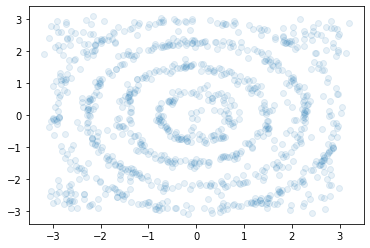

In [41]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

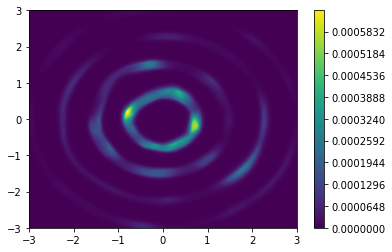

In [42]:
pdf = make_pdf_energy(rings_model)

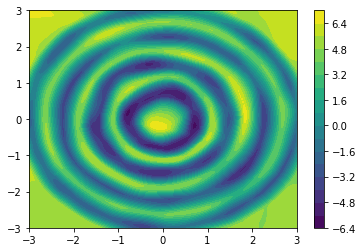

In [43]:
create_contour_plot_tensorflow(rings_model)

### Moons dataset

In [44]:
n_train = 10000
data = sklearn.datasets.make_moons(n_samples=n_train, noise=0.1)[0]
data = data.astype("float32")
data = data * 2 + np.array([-1, -0.2])
moons_train = data

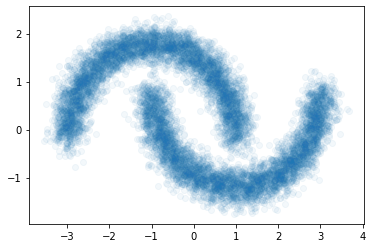

In [45]:
plt.scatter(moons_train[:, 0], moons_train[:, 1], alpha=0.05)

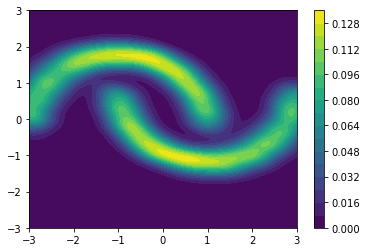

In [46]:
pdf_kde = make_pdf_data(moons_train)

In [47]:
input_ = keras.layers.Input(shape=moons_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
moons_model = keras.Model(inputs=[input_], outputs=[output])

In [48]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(moons_model)

In [49]:
ebm.fit(moons_train, 128, 15, optimizer, [-4, -4], [4, 4], num_steps_markov=tf.constant(10),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0002253529830620839
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.005768480209203866
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.009277941324771978
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.011234374382557012
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.011009696966562515
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.013425279886294633
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.014598763906038724
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.014020973291152563
Epoch progress: 011.52%
Average absolute energy differ

Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.04935683348239996
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.046251957233135514
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.05579091952397273
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.043026294463720076
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.0443808635075887
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.05091433647351387
JSD 0.395068366947769
Epoch 1: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.055120724898118235
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.049898538834009416
Epoch progress: 003.84%
Average absolu

Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.05109309538816794
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04789413549961188
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.04547748810205704
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.04844092100094526
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.049872973026373446
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.04423314180129614
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.03962996984139467
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.04348001724634415
Epoch progress: 096.00%
Average absolute energy difference between training and

Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.04806239788348858
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.04875434361971342
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.04596679027263935
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.05459326352828588
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.04768640872759697
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.05012844770382612
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.04866582919389773
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.055201897254356966
Epoch progress: 088.32%
Average absolute energy difference between training and

Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.051267578051640436
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.05337737156794621
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.05510570452763484
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.05646922038151667
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.05456182895562588
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.05130801445398575
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.054868233509552784
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.05011274875738682
Epoch progress: 080.64%
Average absolute energy difference between training an

Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.04665382091815655
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.06178793540367713
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.06202417764908228
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.06049394607543945
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.05557686243301783
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.057588094320052706
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.05522509110279572
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.054037949977776945
Epoch progress: 071.68%
Average absolute energy difference between training an

Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.05665205075190617
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.05680219943706806
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.05455802037165715
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.058566435789450616
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.05754392574994992
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.058279184194711536
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.053204401945456475
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.059877646275055714
Epoch progress: 064.00%
Average absolute energy difference between training 

Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.059681073213234924
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.05715865355271559
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.051393936841915816
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.055817261720315
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.05439909910544371
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.05957745283077925
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.05662255409436348
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.061068009107540816
Epoch progress: 056.32%
Average absolute energy difference between training and

Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.04952408105899126
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.057331207471016124
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.05133360471480932
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.05220540975913023
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.05841277195857121
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.051670135595859625
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.05598642275883601
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.0611872795300606
Epoch progress: 048.64%
Average absolute energy difference between training and

Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.06459775949135804
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.06036085348862868
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.062270439588106595
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.05986647116832244
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.0650028815636268
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.05323059130937625
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.0609590212504069
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.057040061706151717
Epoch progress: 039.68%
Average absolute energy difference between training and 

Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.06653631650484525
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.05891846387814253
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.06199070123525766
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.05782194015307304
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.05975195077749399
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.060486652912237704
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.06541119477687737
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.06941018960414788
Epoch progress: 032.00%
Average absolute energy difference between training and

Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.06165881034655449
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.06655620305966108
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.066774478325477
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.06378651887942582
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.061795821556678183
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.06833401704445863
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.06628769483321752
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.06914777022141677
Epoch progress: 024.32%
Average absolute energy difference between training and t

Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.061588213993952826
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.06538727344610752
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.06706045835446088
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.06996405430329151
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.07088540150569035
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.06419720405187362
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.07152247428894043
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.07395069415752704
Epoch progress: 015.36%
Average absolute energy difference between training and

Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.06984323110335912
JSD 0.306783255146328
Epoch 12: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.06750897872142303
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.06384986486190404
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.06650241216023763
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.06336292242392515
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.062187060331686944
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.06420491903256147
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.05898163868830754
Epoch progress: 010.24%
Average absolut

Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.07097640404334435
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.06942235506497896
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.07695649220393254
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.07167582634167793
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.07511756359002529
JSD 0.3139059972625612
Epoch 13: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.07326348622639973
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.06695974178803273
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.06730956297654372
Epoch progress: 005.12%
Average absolut

Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.0667102275750576
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.06651754257006523
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.06582892246735401
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.06637118412898137
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.06347445341256948
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.07223014342479217
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.07159194579491249
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.06844464326516175
Epoch progress: 098.56%
Average absolute energy difference between training and t

Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.060398376905001126
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.064391845311874
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.06319441550817245
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.06881682078043619
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.06274629250550881
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.07584856718014447
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.06916255217332107
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.07207902883872007
Epoch progress: 089.60%
Average absolute energy difference between training and t

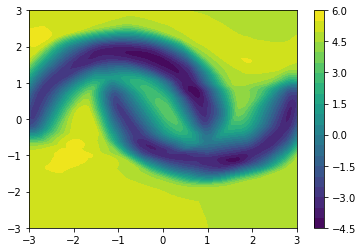

In [50]:
create_contour_plot_tensorflow(moons_model)

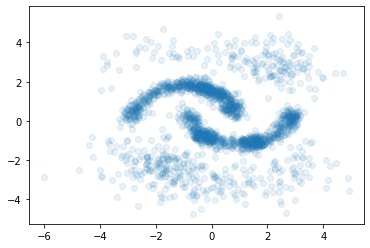

In [51]:
# Sample and plot some points
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(moons_model, x_init, tf.constant(30), 20, 0.15, clip_thresh=tf.constant(1.0))
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

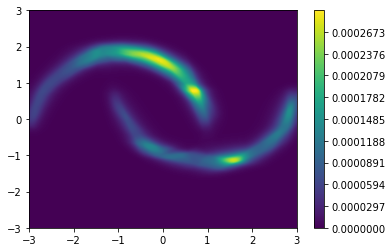

In [52]:
pdf = make_pdf_energy(moons_model)

### Gaussians dataset

In [53]:
batch_size = 5000
rng = np.random.RandomState()
scale = 4.
centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
           (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                 1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
centers = [(scale * x, scale * y) for x, y in centers]

dataset = []
for i in range(batch_size):
    point = rng.randn(2) * 0.5
    idx = rng.randint(8)
    center = centers[idx]
    point[0] += center[0]
    point[1] += center[1]
    dataset.append(point)
dataset = np.array(dataset, dtype="float32")
dataset /= 1.414
gaussians_train = dataset

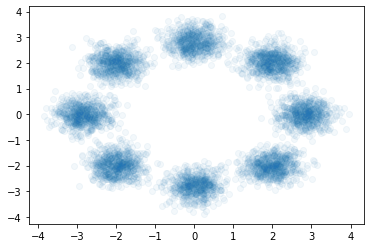

In [54]:
plt.scatter(gaussians_train[:, 0], gaussians_train[:, 1], alpha=0.05)

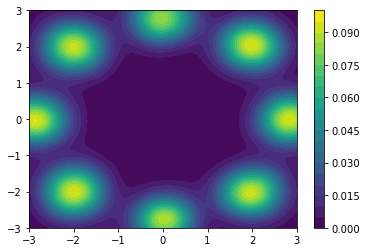

In [55]:
pdf_kde = make_pdf_data(gaussians_train)

In [56]:
input_ = keras.layers.Input(shape=gaussians_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
gaussians_model = keras.Model(inputs=[input_], outputs=[output])

In [57]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(gaussians_model)

In [58]:
ebm.fit(gaussians_train, 128, 30, optimizer, [-4.5, -4.5], [4.5, 4.5], num_steps_markov=tf.constant(10),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.000710889506034362
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.00643386443456014
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.008292930248456122
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.0033093041334396754
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.011366863281298906
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.007862429588268964
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.004268672985908313
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.0055256902407377195
Epoch progress: 023.04%
Average absolute energy differ

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.03485552469889323
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0282440735743596
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.04638781303014511
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.027359959406730455
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04130052297543257
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.03735131483811598
JSD 0.5005917457114865
Epoch 2: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.024063460337810025
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.04317386639423859
Epoch progress: 007.68%
Average absolut

Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.0801851688287197
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.07946672806373009
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.06983448908879207
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0752404164045285
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.0883789551563752
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.0770271924825815
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.07398644471779847
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.07208560674618451
Epoch progress: 092.16%
Average absolute energy difference between training and test

Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08048293529412685
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.08362248005011143
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.09335101567781888
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.08115835678883088
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.09648354236896221
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.08750459475395006
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.08214641228700295
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.09218107125697991
Epoch progress: 076.80%
Average absolute energy difference between training and 

Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.10997330836760692
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.09579066741160858
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.10177305417183118
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.10149975312061799
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.09326766087458684
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.08574320108462602
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08505389629266201
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.09588196950081067
Epoch progress: 061.44%
Average absolute energy difference between training and 

Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0970931664491311
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.07785603938958584
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.09133766859005658
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.10775394928761017
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.08473068017225999
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.09512027104695638
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.08929356550559019
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.10456597499358349
Epoch progress: 046.08%
Average absolute energy difference between training and t

Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.10507533489129482
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.10516790243295522
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.0928516510205391
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.09366223139640611
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.08722418393844213
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0791159837673872
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.10514332697941707
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.11084979619735326
Epoch progress: 033.28%
Average absolute energy difference between training and te

Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.08992892656570825
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.09103939472100674
JSD 0.26510822978155585
Epoch 13: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.1033193025833521
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.09969434982691056
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.10036495404365735
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.10270380362486227
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.08306130384787534
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.10928912040514824
Epoch progress: 017.92%
Average absolut

Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.09634764377887432
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.10670188757089467
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.09279801295353816
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.09610329530177972
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.08556606219365047
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.10184423128763834
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.09880930949480106
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.09460817850553072
JSD 0.2839377916632296
Epoch 15: 000.00%
Epoch progress: 002.56%
Average absolut

Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.09146500856448442
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.07942627026484562
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.10924964073376778
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.08965377318553436
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.10211745286599183
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.10645101009271084
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.08565649619469276
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.09035208897712903
Epoch progress: 087.04%
Average absolute energy difference between training and 

Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.09421195128025152
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.10062851661290878
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08495399279472156
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.09577637452345628
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.10724275540082882
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.09561972740368965
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.10725356370974809
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.10182439975249462
Epoch progress: 071.68%
Average absolute energy difference between training and 

Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.09299004383576222
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.09274192345448029
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.10946270135732797
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.0919509545350686
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.097823882714296
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.10039476859263885
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.10425325540395883
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.10626071538680638
Epoch progress: 056.32%
Average absolute energy difference between training and tes

Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.10653214576916817
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.08753355344136556
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.0916753182044396
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.09737387070289025
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.1059881846110026
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.0977196387755565
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0991963606614333
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.10008583924709222
Epoch progress: 038.40%
Average absolute energy difference between training and test

Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0934770901997884
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.10277691865578675
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.10513585653060521
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.10775094154553536
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.092253966209216
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.09428056081136067
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.09339526983407827
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.09092299754802997
Epoch progress: 023.04%
Average absolute energy difference between training and tes

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.06943994302016038
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.09677789761469914
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.09813677347623384
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.09992083525046323
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.10664754036145332
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.10523446400960286
JSD 0.3554367324932568
Epoch 26: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.09383211380396134
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0848529766767453
Epoch progress: 007.68%
Average absolute

Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.11721999828632061
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.10599432236109024
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.10393213614439352
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.08171717325846353
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.09825798181387094
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.10311833406106019
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.09998737848722017
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.11283686222174229
Epoch progress: 092.16%
Average absolute energy difference between training and 

Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.1113140888703175
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.09690153904450245
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.09596031140058468
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.09778687281486315
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0974885928325164
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.10119515198927659
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.10250307352114946
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.10604265408638196
Epoch progress: 079.36%
Average absolute energy difference between training and te

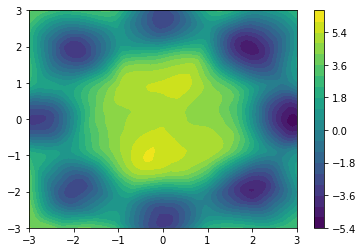

In [59]:
create_contour_plot_tensorflow(gaussians_model)

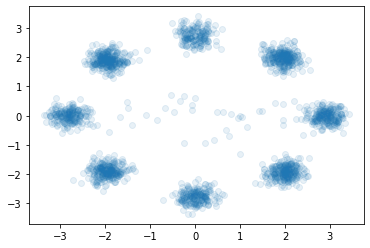

In [60]:
# Sample and plot some points
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(gaussians_model, x_init, tf.constant(30), 20, 0.20, clip_thresh=tf.constant(1.0))
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

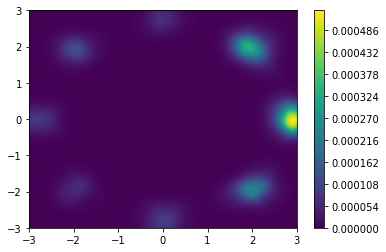

In [61]:
pdf = make_pdf_energy(gaussians_model)

### Pinwheel dataset

In [62]:
batch_size = 10000
rng = np.random.RandomState()
radial_std = 0.3
tangential_std = 0.1
num_classes = 5
num_per_class = batch_size // 5
rate = 0.25
rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

features = rng.randn(num_classes*num_per_class, 2) \
    * np.array([radial_std, tangential_std])
features[:, 0] += 1.
labels = np.repeat(np.arange(num_classes), num_per_class)

angles = rads[labels] + rate * np.exp(features[:, 0])
rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
rotations = np.reshape(rotations.T, (-1, 2, 2))

pinwheel_train = rng.permutation(np.einsum("ti,tij->tj", features, rotations))

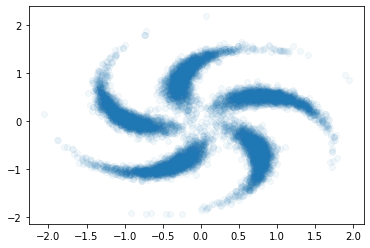

In [63]:
plt.scatter(pinwheel_train[:, 0], pinwheel_train[:, 1], alpha=0.05)

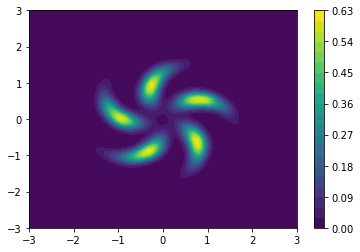

In [64]:
pdf_kde = make_pdf_data(pinwheel_train)

In [65]:
input_ = keras.layers.Input(shape=pinwheel_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
pinwheel_model = keras.Model(inputs=[input_], outputs=[output])

In [66]:
optimizer = keras.optimizers.Adam(1e-3)
ebm = EBM(pinwheel_model)

In [67]:
ebm.fit(pinwheel_train, 128, 50, optimizer, [-3, -3], [3, 3], num_steps_markov=tf.constant(10),
        std_dev=0.05, step_size=0.05, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.1, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0002541525575977105
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.006546598978531666
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.011816912736648168
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.01764996846516927
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.022026149126199573
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.02399911941626133
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.02486560894892766
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.022046404007153634
Epoch progress: 011.52%
Average absolute energy differenc

Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.06895112991333008
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.07721207692072941
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.06804808592184995
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.06148110291896722
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.06788362600864507
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.06511164934207231
JSD 0.42179683790522315
Epoch 1: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.06183226903279622
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.06662643872774564
Epoch progress: 003.84%
Average absolut

Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.06805606377430451
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.06552872290978065
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.07193375856448442
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.06457733496641502
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.07078050344418256
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.07297205924987793
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.07322394542205028
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.07117571586217636
Epoch progress: 094.72%
Average absolute energy difference between training and 

Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.06520876517662635
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.0623788038889567
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0685876577328413
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.06274686715541741
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.06582340216025327
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.07628791760175656
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.06637907028198242
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.06578996853950696
Epoch progress: 087.04%
Average absolute energy difference between training and te

Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.06941394316844451
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.06669155756632486
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.06132149085020407
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.0718539678133451
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.06644923870380108
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.06281721897614308
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.06507120988307855
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.07424043386410444
Epoch progress: 079.36%
Average absolute energy difference between training and t

Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.07623256781162359
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.07755802839230268
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.07027491545065855
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.06653311925056653
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.07514744538527268
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.07412168918511806
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0656739014845628
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.06859637529422075
Epoch progress: 071.68%
Average absolute energy difference between training and t

Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.07043021153181027
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.07368679535694611
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.06618203872289413
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.06703683657523914
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.0695042487902519
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.06559556569808568
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.06449506221673428
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.0726634050026918
Epoch progress: 064.00%
Average absolute energy difference between training and te

Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.06763728459676106
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.06609920354989858
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.06776208143967849
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.07083450219570062
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.06988925811571953
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.06555825624710473
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.07060575485229492
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.06423073548537034
Epoch progress: 056.32%
Average absolute energy difference between training and 

Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.07107164920904697
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.07234039062108749
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.07436542633252266
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.06545834052257049
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.0699476828941932
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.06708776645171337
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.06850762244982597
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.06988914807637532
Epoch progress: 048.64%
Average absolute energy difference between training and t

Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.06516174781016815
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.06751797749445988
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0727697030091897
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.06685874400994717
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.060958232635106795
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.07191823079035832
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.06678090340051895
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.07236348665677583
Epoch progress: 040.96%
Average absolute energy difference between training and 

Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.07142460651886769
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.06430698052430764
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.06632874562190129
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.05937748688917893
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.06549939131125425
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.07117093526400052
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.0699007572271885
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.07401151534838554
Epoch progress: 033.28%
Average absolute energy difference between training and t

Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.07021406369331555
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.07266039726061699
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.07292611782367413
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.07231414623749562
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.06404677415505433
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.06999526879726312
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.06405005699548966
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.07007188674731132
Epoch progress: 025.60%
Average absolute energy difference between training and 

Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.06757377966856346
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.07203077658628806
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.07378996335543118
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.07177884150774051
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.06985910122211163
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.0626691426986303
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.07767669971172626
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.06625501314798991
Epoch progress: 019.20%
Average absolute energy difference between training and t

JSD 0.25852181626811804
Epoch 12: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.07049219424907978
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.06985984704433343
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.07113917057330792
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.07249749623812161
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.0739302268395057
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.0766915663694724
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.06982251925346179
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.07311796530699119
Epoch progress: 011.52%
Average absolute

Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.07318107287089029
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.06796850302280523
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.07030277985792893
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.07367444649720803
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.077941222068591
JSD 0.28263568688637986
Epoch 13: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.07440760808113293
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.08347840186877128
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.07600961587367913
Epoch progress: 005.12%
Average absolute

Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.07166603895334096
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.07157414387433957
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.07558287107027493
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.07544533411661783
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.07290277725610977
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.07412598071954189
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.07888259643163437
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.08069798273917957
Epoch progress: 096.00%
Average absolute energy difference between training and 

Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.08078847787319085
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.07739845300332093
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.08343148842836037
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.07673228092682667
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.08289647713685647
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.07786836379613632
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.07523617377647987
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.07363764444986978
Epoch progress: 088.32%
Average absolute energy difference between training and 

Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.06990448022500062
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.07537857691446939
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.07659101486206055
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.08163570746397361
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.0818962500645564
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.07945032608814728
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.08131947884192833
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.07477054840479141
Epoch progress: 080.64%
Average absolute energy difference between training and t

Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.07328233963403946
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.07976843149234086
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.07974645418998523
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.07808112486814842
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.07858040393927158
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.08258376977382562
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.08340637500469501
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.08413503108880459
Epoch progress: 072.96%
Average absolute energy difference between training and 

Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.08277092224512345
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08052899898626865
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.07981475194295247
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.0685727901947804
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.07610926261314979
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.0694441428551307
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.07327975982274765
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.06984950334597856
Epoch progress: 065.28%
Average absolute energy difference between training and te

Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.07436194786658654
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.07275737248934232
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.07934157053629556
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.07538220821282803
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.09021642880562024
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.09013109329419258
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08485034795907827
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.08836626395201072
Epoch progress: 058.88%
Average absolute energy difference between training and 

Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.0776216800396259
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.08074847245827699
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.08009886130308494
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.0846414321508163
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.08319353445982322
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.08720730512570112
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.08540087479811448
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.08127085367838541
Epoch progress: 052.48%
Average absolute energy difference between training and te

Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.08596022923787434
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.08353897241445687
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.08165562458527394
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.0837400448627961
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.08135434297414926
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.08935360419444549
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.08147924374311398
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.08315521631485376
Epoch progress: 044.80%
Average absolute energy difference between training and t

Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.07978118382967435
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.07544579872718224
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.08701546986897786
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.08057023317385942
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.08690823041475736
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.07272933079646184
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.08054165962414864
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.0821385016808143
Epoch progress: 037.12%
Average absolute energy difference between training and t

Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.0881038934756548
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.08368710982493865
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.07787617047627766
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.08054370146531324
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.08427795997032753
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.08414649963378906
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.08039728800455728
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.08704685553526267
Epoch progress: 029.44%
Average absolute energy difference between training and t

Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.08074835019233899
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.08212526639302571
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.08752151635976937
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.08727450859852326
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.0828545827132005
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.08630549602019481
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.07904810783190605
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.07733008800408779
Epoch progress: 021.76%
Average absolute energy difference between training and t

Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.07721399038265912
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.08151184595548189
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.0767974670116718
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.08325551106379582
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.0845640989450308
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.08512013997787084
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.08466664338723207
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.08243714234767816
Epoch progress: 014.08%
Average absolute energy difference between training and te

Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.08897075897608048
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.08403681486080854
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.08605351814856896
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.07835353949131109
JSD 0.3353361748830838
Epoch 25: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.08824008550399388
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.07964969292665139
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.08373006184895833
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.08273994005643404
Epoch progress: 006.40%
Average absolut

Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.08472096003018892
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.08071310092241336
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.0697337969755515
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.07644276741223457
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.08118126942561223
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.07593838373819986
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.08076835289979592
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.08576904810391939
Epoch progress: 098.56%
Average absolute energy difference between training and t

Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.08526531855265299
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.08674994493142152
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.08624552457760541
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.08486508100460737
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.08086052919045472
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.0799418107057229
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.08482649998787122
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0806436294164413
Epoch progress: 090.88%
Average absolute energy difference between training and te

Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.07986883016733022
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.08380453403179462
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.08958671031854092
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.09027866828135955
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.09043830480331029
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.08033917500422551
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.08219077648260655
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.08587953371879382
Epoch progress: 083.20%
Average absolute energy difference between training and 

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.08909363624377128
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.08331930943024464
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.08904175269298065
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.08290497461954752
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.07490450296646509
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.08744741708804399
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.08148362086369441
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.08949986482277894
Epoch progress: 075.52%
Average absolute energy difference between training and 

Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.09360776803432366
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.08847560026706792
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.08911003210605718
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.09513522417117387
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.090027283399533
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.08444610008826622
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.09035579363505045
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.08620884479620518
Epoch progress: 067.84%
Average absolute energy difference between training and te

Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.09380796628120618
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0902869945917374
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.09044193610166892
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.09084554818960336
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.0900584000807542
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.09017125154152894
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08440574010213216
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.08059524267147748
Epoch progress: 058.88%
Average absolute energy difference between training and te

Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.08880106608072916
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.08558432261149088
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.08994290156242174
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.08793390714205228
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.08771278919317783
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.08929889630048703
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.08543008413070287
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.08350583223196176
Epoch progress: 051.20%
Average absolute energy difference between training and 

Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.08331634448124813
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0865331490834554
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.09253483552199143
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.08649021539932641
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.08582460574614696
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.09110876841422838
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.09032078278370392
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.08977867395449907
Epoch progress: 042.24%
Average absolute energy difference between training and t

Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.08947362655248398
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.08728800675807855
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.08207465440799028
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.08433847549634102
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.09389634621449006
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.09247962022439027
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.08501465503986065
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0901487790621244
Epoch progress: 034.56%
Average absolute energy difference between training and t

Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.0865937746488131
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.09061890993362817
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.09238410607362404
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.08731511922983022
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.08476988474527994
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.08398195413442758
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.09139704092954978
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.08560370787596092
Epoch progress: 026.88%
Average absolute energy difference between training and t

Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.08924736120761968
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.08595981964698204
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.0859702978378687
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.0872200819162222
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.0866852784768129
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.08497625742203149
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.09212426650218475
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.09270889331132938
Epoch progress: 017.92%
Average absolute energy difference between training and tes

Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.08998813384618515
JSD 0.31734646125827254
Epoch 36: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.09064439626840444
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.08586923892681415
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.08415687389862843
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.09426060089698204
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.08417768356127617
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.08229863337981395
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.0877392842219426
Epoch progress: 010.24%
Average absolut

Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.09237197729257436
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.08526139381604317
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.09223365783691406
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.09718971986037034
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.09057139127682416
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.09040161279531625
JSD 0.3192833759557517
Epoch 37: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.08310485497499123
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0875095342978453
Epoch progress: 003.84%
Average absolute

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.08572286214583959
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.08221102983523637
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0934001482450045
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.08942965360788198
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.09032315474290113
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.08459141315558018
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.08511637418698041
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.0841084382472894
Epoch progress: 097.28%
Average absolute energy difference between training and te

Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.08794729526226337
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.08028695522210537
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.08089124239408052
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.09000069055801782
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.089310517677894
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.09182524069761619
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.09666892198415902
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.09158896177242963
Epoch progress: 088.32%
Average absolute energy difference between training and te

Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.08683687601334009
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.08155621626438238
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.08810188831427158
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.08921892215044071
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.08685994759584084
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.09148938839252178
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.08338876870962289
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0828699576549041
Epoch progress: 080.64%
Average absolute energy difference between training and t

Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.08857396932748647
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.09552437831193973
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.08782828771151029
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.09069581520863068
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.09726741986396985
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.09145789268689278
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.08442156742780636
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.08888097909780648
Epoch progress: 072.96%
Average absolute energy difference between training and 

Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.08463996495956029
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.09032457914107885
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.08766909746023324
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.10046562781700721
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.08958032803657727
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.09575807742583446
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.08989989451872997
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.0913257476611015
Epoch progress: 065.28%
Average absolute energy difference between training and t

Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.09435861538618039
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.08925551634568434
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.09795050743298653
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.08688557453644581
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.08692577557686047
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.0782470458593124
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.09084695424789037
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.08441821734110513
Epoch progress: 057.60%
Average absolute energy difference between training and t

Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.09118240307538937
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.08470654487609863
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.08900838631850022
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.08159407591208433
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.08202847456320737
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.08530694399124536
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.09012463765266614
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.09016991272950783
Epoch progress: 049.92%
Average absolute energy difference between training and 

Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.07788828091743664
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.08697839272327912
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.08129754433265099
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.0830083504701272
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.09058208954639924
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.08095195965889172
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.09176050699674165
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.092774109962659
Epoch progress: 042.24%
Average absolute energy difference between training and tes

Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.08535001828120305
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.08479054768880208
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.08477630370702499
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.08632650130834335
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.08748862682244717
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.08651570173410268
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.09092291196187337
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.08417064104324731
Epoch progress: 034.56%
Average absolute energy difference between training and 

Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.08833760481614332
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.08478766221266526
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.08112390224750225
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.08086093266805013
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.08471379524622208
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.0842902966034718
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.09290643227406037
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.09215132395426431
Epoch progress: 026.88%
Average absolute energy difference between training and t

Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.08271270531874436
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.08420130534049793
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.09077673691969651
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.09162823359171549
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.08995249332525791
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.09050693267431015
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.09348573440160507
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.08895538403437687
Epoch progress: 019.20%
Average absolute energy difference between training and 

Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.07780970059908353
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.08592678950383113
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.08244146444858648
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0811765377338116
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.08899389169155023
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.08190090228349735
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.08295455345740685
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.09100514191847581
Epoch progress: 011.52%
Average absolute energy difference between training and t

Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.09325284224290113
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.0920884976020226
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.08153507037040515
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.08999005342141175
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.08550698329240848
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.08605043704693134
JSD 0.36543140135943375
Epoch 49: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.08784207319601987
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.09302823971479367
Epoch progress: 003.84%
Average absolut

Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.08604211073655348
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.08445498882195888
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.07994040464743589
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0841517509558262
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.08118834862342247
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.08325795026925893
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.08639357640193059
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.08873275610116811
Epoch progress: 096.00%
Average absolute energy difference between training and t

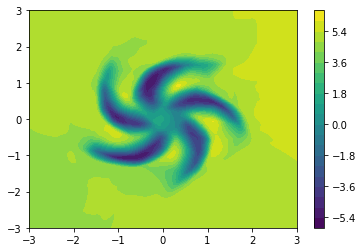

In [68]:
create_contour_plot_tensorflow(pinwheel_model)

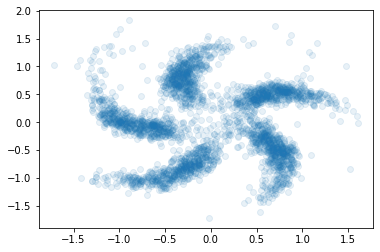

In [69]:
# Sample and plot some points
batch_size = 3000
x_init = tf.random.uniform((batch_size, 2), minval=-1, maxval=1)
sample = sgld_sample(pinwheel_model, x_init, tf.constant(30), 3.1, 0.065, clip_thresh=tf.constant(1.0))
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

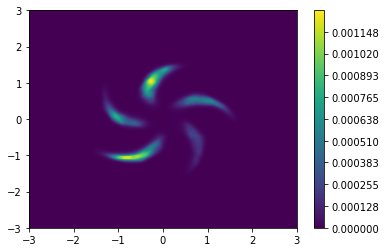

In [70]:
pdf = make_pdf_energy(pinwheel_model)

### Spirals dataset

In [71]:
batch_size = 20000
n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
x += np.random.randn(*x.shape) * 0.1
spirals_train = x

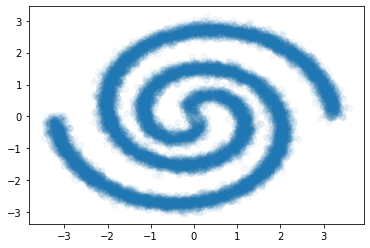

In [72]:
plt.scatter(spirals_train[:, 0], spirals_train[:, 1], alpha=0.05)

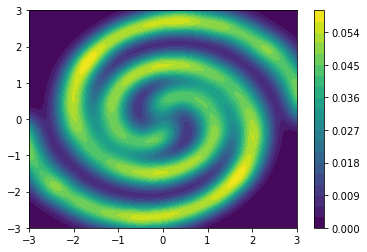

In [73]:
pdf_kde = make_pdf_data(spirals_train)

In [74]:
input_ = keras.layers.Input(shape=spirals_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
spirals_model = keras.Model(inputs=[input_], outputs=[output])

In [75]:
ebm = EBM(spirals_model)

In [76]:
optimizer = keras.optimizers.Adam(1e-3)
ebm.fit(spirals_train, 128, 30, optimizer, [-4, -4], [4, 4], num_steps_markov=tf.constant(25),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.5, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.0002536564969863647
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.002037310065367283
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.0012560429481359627
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.00015860681350414569
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.0003815083167491815
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.0004029810333099121
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.0007320841153462727
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0008703727179612869
Epoch progress: 005.76%
Average absolute energy

Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.0024878745659803734
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.0032447744638491897
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.003023261634203104
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.0026526624957720437
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.0024542351945852623
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.00286748699652843
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.002172432839870453
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.002723814776310554
Epoch progress: 096.64%
Average absolute energy difference between tr

Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.002692235585970756
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.002829126058480678
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.00249921243924361
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.0024041132285044743
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.0026836635974737313
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.0020970310538243023
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.002466506682909452
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.0025465736786524453
Epoch progress: 042.88%
Average absolute energy difference between tr

Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.002231369606959514
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.0026448529500227706
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.0019166943354484362
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.0020425904255646924
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.002867906712568723
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.0036779412856468787
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.001841763655344645
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.0014409422874450684
Epoch progress: 088.32%
Average absolute energy difference between 

Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.0025186680066279876
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.0024068603912989297
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.00263137542284452
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.002144751258385487
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.0023264907873593844
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.0024177248661334696
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.0018119519719710716
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0021612563958534827
Epoch progress: 033.92%
Average absolute energy difference between 

Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.0017689623129673493
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.0023420028961621798
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.0015855166010367563
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.0019342186741339853
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.0016520667152527051
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.0025319594603318432
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.0022172071994879306
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0020274571501291716
Epoch progress: 080.00%
Average absolute energy difference betwe

Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.0028248257361925566
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.0028915342230063216
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.002094044899329161
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.002373422949742048
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.002646330457467299
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.002570470938315758
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.0024631932759896303
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.002066455208338224
Epoch progress: 024.96%
Average absolute energy difference between tr

Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.002269707047022306
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.0028016666571299234
Epoch progress: 067.20%
Average absolute energy difference between training and test examples: 0.0026521610143857123
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.002509589760731428
Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.0030522228051454593
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0021360573860315177
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.0026937864529780853
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.002261676467381991
Epoch progress: 071.04%
Average absolute energy difference between 

Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.0025465572491670265
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.0031137642187949936
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.003000357212164463
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.003094385640743451
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.002370606248195355
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.0028639806386752007
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.002724223794081272
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.0025208452955270424
Epoch progress: 016.64%
Average absolute energy difference between t

Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.0031497663794419705
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.003007413103030278
Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.0033293901345668696
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.003513852373147622
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.0028657605632757526
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.0033114575422727144
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.002538583408563565
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.0029896448055903115
Epoch progress: 062.08%
Average absolute energy difference between 

Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.0040665314747737
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0039953039242671086
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.0037604979215524136
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.003223178478387686
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.0028400614093511533
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0028536044634305513
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.002793597487302927
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.0033909540909987227
Epoch progress: 007.04%
Average absolute energy difference between tr

Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.003872600503456898
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.004301351232406421
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.0035626169962760727
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0033569431457764064
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.004113355890298501
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.004127994561806703
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.0030486129033259857
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.0037991694914988982
Epoch progress: 053.12%
Average absolute energy difference between t

Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.004694998264312744
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.004802795938956432
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.00505644923601395
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.004384430173115852
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.004867773789625901
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.003609230503057822
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.0037714487467056666
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.004544469790580945
Epoch progress: 099.20%
Average absolute energy difference between train

Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.004923864817007994
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.004337814373847766
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.004540972984754122
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.004683569837839175
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.004909163866287623
Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.004236972102752099
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.004306925795017145
Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.004576766338103857
Epoch progress: 046.08%
Average absolute energy difference between train

Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.004286149373421302
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.004648163150518368
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.004332329218204205
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.0053490469088921175
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.003936682756130512
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.004474883660292014
Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.004592694533176911
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.004695400213583922
Epoch progress: 091.52%
Average absolute energy difference between trai

Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.004023461005626581
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.004398591243303739
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.005236023511642065
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.004959947023636255
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.004855269422897926
Epoch progress: 035.20%
Average absolute energy difference between training and test examples: 0.004030184868054512
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.004932545316524995
Epoch progress: 036.48%
Average absolute energy difference between training and test examples: 0.004703509501921825
Epoch progress: 037.12%
Average absolute energy difference between train

Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.004744024612964728
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.004543762176464765
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.004722671248973944
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.005717649291723202
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.006006194994999812
Epoch progress: 081.28%
Average absolute energy difference between training and test examples: 0.005366222980694893
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.004858790299831293
Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.005091218230051872
Epoch progress: 083.20%
Average absolute energy difference between train

Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.004715003646337069
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.005053786895213983
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.005249042159471756
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.00515636648887243
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.005168135731648176
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.005128359183287009
Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.005318729541240594
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.00533334032083169
Epoch progress: 028.80%
Average absolute energy difference between trainin

Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.00495571127304664
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.0072613442555452
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.005602680719815767
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.004354322567964211
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.00506845460488246
Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.005563810085638976
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.005674919256797204
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.006171487080745208
Epoch progress: 075.52%
Average absolute energy difference between training 

Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.005263369052838056
Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.005052605882669106
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.005728329221407572
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.005315917424666576
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.005833059167250609
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.006025922986177297
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.00484357965298188
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.0057940949232150344
Epoch progress: 021.76%
Average absolute energy difference between train

Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.005054809344120515
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.0058608001623398215
Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.005523644960843599
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.00562175649863023
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.005070166710095528
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.005549350610146156
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.005866160759559045
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.005290822340891912
Epoch progress: 067.20%
Average absolute energy difference between train

Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.005935703332607563
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.005806506444246341
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.006276077949083768
Epoch progress: 009.60%
Average absolute energy difference between training and test examples: 0.005444187384385329
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.0068062612643608675
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.005748375868185973
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.005264295981480525
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.005519068393951807
Epoch progress: 012.80%
Average absolute energy difference between trai

Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.005675377754064706
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.006377577017515133
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.005557505748210809
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.006053998302190731
Epoch progress: 055.68%
Average absolute energy difference between training and test examples: 0.005969943908544687
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.0062847083959824
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.005510168961989574
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.005925690516447409
Epoch progress: 058.24%
Average absolute energy difference between trainin

Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.0065431380883241306
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.005815635889004438
JSD 0.15777648178228304
Epoch 11: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.0052447647620470095
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.00584177940319746
Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.006075823154204931
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.005808549049573067
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.006285164982844622
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.0061206825268574246
Epoch progress: 004.48%
Aver

Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.005914260943730672
Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.006732703783573248
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.005654880633720985
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.0065464744201073274
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.005943882159697704
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.007119267414777706
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.006928177980276254
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.005256131291389465
Epoch progress: 094.72%
Average absolute energy difference between trai

Epoch progress: 036.48%
Average absolute energy difference between training and test examples: 0.00705867547255296
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.006285463388149555
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.006374294559160868
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.005689893395472796
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.006750228313299325
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.006224251710451566
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.005693867802619934
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.0058623666946704565
Epoch progress: 041.60%
Average absolute energy difference between train

Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.005377664397924374
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.006985858464852357
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.006339099544745225
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.004626569839624258
Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.0056740656877175355
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.007108963452852689
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.007334945293573232
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.0073413917651543245
Epoch progress: 087.68%
Average absolute energy difference between tra

Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.007115027079215417
Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.0073424562429770445
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.006725722398513403
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.006531608410370655
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.007578742045622605
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.006271660327911377
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.005823635902160253
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.006415861539351635
Epoch progress: 033.28%
Average absolute energy difference between trai

Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.006898705775921161
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.006430768813842382
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.006151306323516063
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.00544708585127806
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.005940680320446308
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.005684193128194564
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.0055639285307664136
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.00642753793643071
Epoch progress: 078.72%
Average absolute energy difference between traini

Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.006631042712774032
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.006348839172950158
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.0062570373217264805
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.006814886362124712
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.006505785080102773
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.006591339906056722
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.006261297907584753
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.005965272585550943
Epoch progress: 024.32%
Average absolute energy difference between trai

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.005906393512701376
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.005869137170987251
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.006962527067233355
Epoch progress: 067.20%
Average absolute energy difference between training and test examples: 0.006051716514122792
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.006347761704371526
Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.005676002838672736
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0060445926128289635
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.006221946997520251
Epoch progress: 070.40%
Average absolute energy difference between trai

Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.006668054140531099
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.006528012263469207
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.006239766493821755
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.006473133197197547
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.006313013724791698
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.005958434098806136
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.006373654191310589
Epoch progress: 016.00%
Average absolute energy difference between training and test examples: 0.0064711471398671465
Epoch progress: 016.64%
Average absolute energy difference between trai

Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.00609492376828805
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.0057163322583222995
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.006434038663521791
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.006862016060413458
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.006500630806653927
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.006564614100333972
Epoch progress: 062.08%
Average absolute energy difference between training and test examples: 0.0069077916634388455
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.006601069218073135
Epoch progress: 063.36%
Average absolute energy difference between trai

Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.005743674742869842
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.006549093967828995
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.006382452753873971
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.006709963847429324
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.0062254430391849615
Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.006246549960894462
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.00688475523239527
Epoch progress: 008.32%
Average absolute energy difference between training and test examples: 0.0059826767597443015
Epoch progress: 008.96%
Average absolute energy difference between trai

Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.006346206634472578
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.006124657698166676
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.0057299236456553135
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.007033000389734903
Epoch progress: 053.12%
Average absolute energy difference between training and test examples: 0.006783033028627053
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.006456124476897411
Epoch progress: 054.40%
Average absolute energy difference between training and test examples: 0.006383195519447327
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.006371621902172382
Epoch progress: 055.68%
Average absolute energy difference between trai

Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.007301396284347925
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.006855674279041779
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.006915152072906494
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.007681002983680138
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.007019358567702465
Epoch progress: 099.20%
Average absolute energy difference between training and test examples: 0.006788959869971642
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.006559132765500973
JSD 0.15093426691293851
Epoch 17: 000.00%
Epoch progress: 000.64%
Average absolute energy difference between training and test examples: 0.006389933900955396
Epoch progress: 001.28%
Averag

Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.006716119173245552
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.0071135820486606695
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.006445233638469989
Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.006954811322383392
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.007205383899884346
Epoch progress: 045.44%
Average absolute energy difference between training and test examples: 0.007762905878898425
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.0071638570382044865
Epoch progress: 046.72%
Average absolute energy difference between training and test examples: 0.007351476412553053
Epoch progress: 047.36%
Average absolute energy difference between tra

Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.006266812483469645
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.006075797936855218
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0064768218077146085
Epoch progress: 090.24%
Average absolute energy difference between training and test examples: 0.007177141232368274
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.006944530285321749
Epoch progress: 091.52%
Average absolute energy difference between training and test examples: 0.006578384301601312
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.0074357718993455935
Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.006886351567048293
Epoch progress: 093.44%
Average absolute energy difference between tra

Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.0068146723967332104
Epoch progress: 035.20%
Average absolute energy difference between training and test examples: 0.006847763672853127
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.00736395823649871
Epoch progress: 036.48%
Average absolute energy difference between training and test examples: 0.00728073334082579
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.0069448535258953385
Epoch progress: 037.76%
Average absolute energy difference between training and test examples: 0.007338698093707745
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.006540683599618765
Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.006738141561165834
Epoch progress: 039.68%
Average absolute energy difference between train

Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.006211345776533469
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.007366735201615553
Epoch progress: 081.28%
Average absolute energy difference between training and test examples: 0.006585899835977798
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.007380182162309304
Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.0074799931966341455
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.006530290994888697
Epoch progress: 083.84%
Average absolute energy difference between training and test examples: 0.006226360033719967
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.00571744564252022
Epoch progress: 085.12%
Average absolute energy difference between train

Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.0064108983064309144
Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.006912959691805717
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.006145283579826355
Epoch progress: 028.80%
Average absolute energy difference between training and test examples: 0.007633288701375325
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.006179109597817445
Epoch progress: 030.08%
Average absolute energy difference between training and test examples: 0.0059339694487742884
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.006365329791338015
Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.006021909988843477
Epoch progress: 032.00%
Average absolute energy difference between tra

Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.006134990698251968
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.006670886125320043
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.0072950231723296335
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.006261367828418047
Epoch progress: 076.16%
Average absolute energy difference between training and test examples: 0.00667043679799789
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.007118336665324676
Epoch progress: 077.44%
Average absolute energy difference between training and test examples: 0.006087259604380681
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.006951400866875282
Epoch progress: 078.72%
Average absolute energy difference between train

Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.006619357909911718
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.007063778547140268
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.00711824343754695
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.007149318854014078
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.006550061397063427
Epoch progress: 022.40%
Average absolute energy difference between training and test examples: 0.006561925778022179
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.007667364218296149
Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.006356301980140882
Epoch progress: 024.32%
Average absolute energy difference between traini

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.007378769226563282
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.006668757169674604
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.006586655592307066
Epoch progress: 067.20%
Average absolute energy difference between training and test examples: 0.006600467058328481
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.006998001764982174
Epoch progress: 068.48%
Average absolute energy difference between training and test examples: 0.007061670988033979
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0077315630056919195
Epoch progress: 069.76%
Average absolute energy difference between training and test examples: 0.007104542010869735
Epoch progress: 070.40%
Average absolute energy difference between trai

Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.006446153689653445
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.006357278579320663
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.006547744457538311
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.006755983982330713
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.006445511793478941
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.007370662230711716
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.00734330599124615
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.006730067424285106
Epoch progress: 016.00%
Average absolute energy difference between traini

Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.006667014880058093
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.007131411479069636
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.006840696701636681
Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.006703369892560518
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.005853409950549786
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.006870590723477877
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.00826667363827045
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.006498760137802515
Epoch progress: 061.44%
Average absolute energy difference between traini

Epoch progress: 001.92%
Average absolute energy difference between training and test examples: 0.005950738222171099
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.005985129338044386
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.006839918784606151
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.007518363304627247
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.006582634571271065
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.00634969427035405
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.007654958810561743
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.007547447314629188
Epoch progress: 007.04%
Average absolute energy difference between traini

Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.007119613580214672
Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.007299977999467116
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.007372847734353481
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.007763046484727126
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.006975287046187963
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.006990638298866076
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.006751058957515619
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.007459563322556324
Epoch progress: 052.48%
Average absolute energy difference between train

Epoch progress: 092.80%
Average absolute energy difference between training and test examples: 0.006756413441437941
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.007204774098518567
Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.006122780533937307
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.006791616861636822
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.007094054650037716
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.006984933828696226
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.006885987061720627
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.007080486187568078
Epoch progress: 097.92%
Average absolute energy difference between train

Epoch progress: 039.04%
Average absolute energy difference between training and test examples: 0.007316066668583796
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.006757887510152963
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.005884668001761803
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.0065849981246850426
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.007262376638559194
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.00734183879999014
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.007583401142022548
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.007567051129463391
Epoch progress: 044.16%
Average absolute energy difference between train

Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.0075239103574019205
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.008281836907068888
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.006469362821334448
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.00693405515108353
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.007344282590425931
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.007780584005209115
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.007562317909338535
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.006931952941112029
Epoch progress: 090.24%
Average absolute energy difference between train

Epoch progress: 031.36%
Average absolute energy difference between training and test examples: 0.007365621053255521
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.0065094859172136355
Epoch progress: 032.64%
Average absolute energy difference between training and test examples: 0.007527351379394531
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.007435897986094156
Epoch progress: 033.92%
Average absolute energy difference between training and test examples: 0.0075466930866241455
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.007371661754754873
Epoch progress: 035.20%
Average absolute energy difference between training and test examples: 0.006939828395843506
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.007104206543702345
Epoch progress: 036.48%
Average absolute energy difference between tra

Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.006698828477125901
Epoch progress: 078.72%
Average absolute energy difference between training and test examples: 0.00765916781547742
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.007488719927958953
Epoch progress: 080.00%
Average absolute energy difference between training and test examples: 0.007472024514124943
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.007616512286357391
Epoch progress: 081.28%
Average absolute energy difference between training and test examples: 0.007476147168721908
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.0076122238085820125
Epoch progress: 082.56%
Average absolute energy difference between training and test examples: 0.008055800046676245
Epoch progress: 083.20%
Average absolute energy difference between train

Epoch progress: 023.68%
Average absolute energy difference between training and test examples: 0.0076723893483479815
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.0075956078676077034
Epoch progress: 024.96%
Average absolute energy difference between training and test examples: 0.007717713331564878
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.007242623812113052
Epoch progress: 026.24%
Average absolute energy difference between training and test examples: 0.007015732618478628
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.007938543955485025
Epoch progress: 027.52%
Average absolute energy difference between training and test examples: 0.006735317982160128
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.00649871581639999
Epoch progress: 028.80%
Average absolute energy difference between trai

Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.008189597955116859
Epoch progress: 071.04%
Average absolute energy difference between training and test examples: 0.007557209485616439
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.006968807715636033
Epoch progress: 072.32%
Average absolute energy difference between training and test examples: 0.007081688214571048
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.007989641183461899
Epoch progress: 073.60%
Average absolute energy difference between training and test examples: 0.00755842068256476
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.007434763969519199
Epoch progress: 074.88%
Average absolute energy difference between training and test examples: 0.007788887390723595
Epoch progress: 075.52%
Average absolute energy difference between traini

Epoch progress: 017.28%
Average absolute energy difference between training and test examples: 0.007005821435879438
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.007881106474460699
Epoch progress: 018.56%
Average absolute energy difference between training and test examples: 0.0078116670632973695
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.007652673965845352
Epoch progress: 019.84%
Average absolute energy difference between training and test examples: 0.007512197280541444
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.006881600771194849
Epoch progress: 021.12%
Average absolute energy difference between training and test examples: 0.008215178281832963
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.007049912061446752
Epoch progress: 022.40%
Average absolute energy difference between trai

Epoch progress: 063.36%
Average absolute energy difference between training and test examples: 0.007258380070710793
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.006800347413772192
Epoch progress: 064.64%
Average absolute energy difference between training and test examples: 0.007605766638731345
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.008501301209131876
Epoch progress: 065.92%
Average absolute energy difference between training and test examples: 0.006835769384335249
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.006944874158272376
Epoch progress: 067.20%
Average absolute energy difference between training and test examples: 0.0076465629614316495
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.008273156789632944
Epoch progress: 068.48%
Average absolute energy difference between trai

Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.007264134211417956
Epoch progress: 010.88%
Average absolute energy difference between training and test examples: 0.007120675001388941
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.0074301927517621946
Epoch progress: 012.16%
Average absolute energy difference between training and test examples: 0.007368323130485339
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.007598371841968634
Epoch progress: 013.44%
Average absolute energy difference between training and test examples: 0.007362749332036727
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.007020644652537811
Epoch progress: 014.72%
Average absolute energy difference between training and test examples: 0.0076408951710432
Epoch progress: 015.36%
Average absolute energy difference between traini

Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.007973463107378054
Epoch progress: 056.96%
Average absolute energy difference between training and test examples: 0.007231111709888165
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.007868526837764641
Epoch progress: 058.24%
Average absolute energy difference between training and test examples: 0.007370980122150519
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.006403917303452125
Epoch progress: 059.52%
Average absolute energy difference between training and test examples: 0.0073721072612664635
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.0073698499263861236
Epoch progress: 060.80%
Average absolute energy difference between training and test examples: 0.007261099723669198
Epoch progress: 061.44%
Average absolute energy difference between tra

Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.007654950404778505
Epoch progress: 003.20%
Average absolute energy difference between training and test examples: 0.007278923040781265
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.007655136860333956
Epoch progress: 004.48%
Average absolute energy difference between training and test examples: 0.007172798499082907
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.006571649740903805
Epoch progress: 005.76%
Average absolute energy difference between training and test examples: 0.008076314742748553
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.007310992632156763
Epoch progress: 007.04%
Average absolute energy difference between training and test examples: 0.007133710842866164
Epoch progress: 007.68%
Average absolute energy difference between train

Epoch progress: 048.00%
Average absolute energy difference between training and test examples: 0.0075205900730230864
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.0073929841701801
Epoch progress: 049.28%
Average absolute energy difference between training and test examples: 0.0066220622796278735
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.007742347625585702
Epoch progress: 050.56%
Average absolute energy difference between training and test examples: 0.0074375317646906925
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.007082723654233492
Epoch progress: 051.84%
Average absolute energy difference between training and test examples: 0.006642009967412704
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.006605099409054487
Epoch progress: 053.12%
Average absolute energy difference between trai

Epoch progress: 094.08%
Average absolute energy difference between training and test examples: 0.007143855094909668
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.00660791305395273
Epoch progress: 095.36%
Average absolute energy difference between training and test examples: 0.00678870922479874
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.00753291524373568
Epoch progress: 096.64%
Average absolute energy difference between training and test examples: 0.007374758903796856
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.006353579270534026
Epoch progress: 097.92%
Average absolute energy difference between training and test examples: 0.007398970616169465
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.007620674677384205
Epoch progress: 099.20%
Average absolute energy difference between training

Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.0068579010474376185
Epoch progress: 040.32%
Average absolute energy difference between training and test examples: 0.007191311854582566
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.006997213149682069
Epoch progress: 041.60%
Average absolute energy difference between training and test examples: 0.006987531979878743
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.007550002672733405
Epoch progress: 042.88%
Average absolute energy difference between training and test examples: 0.006432054898677728
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.006414862015308478
Epoch progress: 044.16%
Average absolute energy difference between training and test examples: 0.007668744295071333
Epoch progress: 044.80%
Average absolute energy difference between trai

Epoch progress: 085.12%
Average absolute energy difference between training and test examples: 0.007546094747690054
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.007546805418454683
Epoch progress: 086.40%
Average absolute energy difference between training and test examples: 0.007761428753534952
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.007681608200073242
Epoch progress: 087.68%
Average absolute energy difference between training and test examples: 0.008042644995909471
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.006984488322184635
Epoch progress: 088.96%
Average absolute energy difference between training and test examples: 0.0071737345976707265
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.007699238948332957
Epoch progress: 090.24%
Average absolute energy difference between trai

In [77]:
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(spirals_model, x_init, tf.constant(50), 8, 0.05, clip_thresh=tf.constant(0.1))

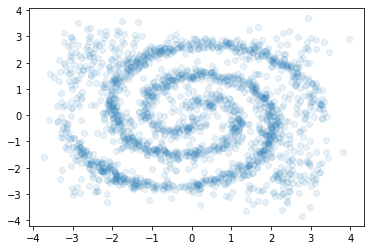

In [78]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

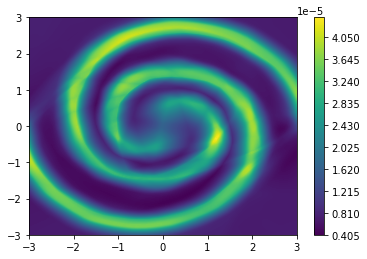

In [79]:
pdf = make_pdf_energy(spirals_model)

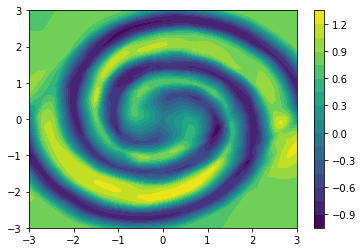

In [80]:
create_contour_plot_tensorflow(spirals_model)

### Checkerboard dataset

In [81]:
batch_size = 10000
x1 = np.random.rand(batch_size) * 4 - 2
x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
x2 = x2_ + (np.floor(x1) % 2)
checkerboard_train = np.concatenate([x1[:, None], x2[:, None]], 1) * 2

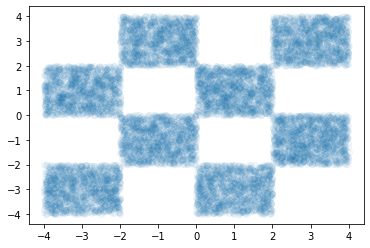

In [82]:
plt.scatter(checkerboard_train[:, 0], checkerboard_train[:, 1], alpha=0.05)

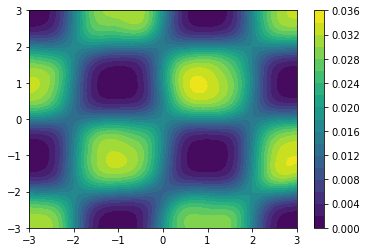

In [83]:
pdf_kde = make_pdf_data(checkerboard_train)

In [84]:
input_ = keras.layers.Input(shape=checkerboard_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
checkerboard_model = keras.Model(inputs=[input_], outputs=[output])

In [85]:
ebm = EBM(checkerboard_model)

In [86]:
optimizer = keras.optimizers.Adam(1e-3)
ebm.fit(checkerboard_train, 128, 30, optimizer, [-4.5, -4.5], [4.5, 4.5], num_steps_markov=tf.constant(25),
        std_dev=0.1, step_size=0.1, callbacks_energy=[("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))],
        alpha=0.5, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 2.4668108194302287e-05
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.002277906888570541
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.00035869120023189445
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.0006534518339695075
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.0008927048780979255
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.0006024871881191547
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 7.701598298855317e-05
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.00022635752191910375
Epoch progress: 011.52%
Average absolute ener

Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.0019505234100879766
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.001746402145960392
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.001089601084972039
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.0011777268388332464
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.0012379738573844617
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.0012191655353093757
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.000861469560708755
JSD 0.24062427334092795
Epoch 1: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0009372881016670129
Epoch progress: 002.56%
Av

Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.0017971558830676933
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.0014414989795440282
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.002195053757765354
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.001862668074094332
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.002572085230778425
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.002264497562860831
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.0028001723381189197
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.0019473699040901966
Epoch progress: 092.16%
Average absolute energy difference between t

Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.0022053258159221746
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.0035552791295907437
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.002725861011407314
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.003071675889002971
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.003159985710413028
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.0020517695408601025
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.0026904470645464384
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.0025330583254496255
Epoch progress: 084.48%
Average absolute energy difference between 

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.003750088123174814
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.002419340113798777
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.0031438412574621346
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.003445304739169585
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.002546318830587925
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.003220536769964756
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.0028827606867521238
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.003479927014081906
Epoch progress: 075.52%
Average absolute energy difference between tra

Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.004014826737917386
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.0037218068654720597
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.0028795706920134714
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.0036339534398836964
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0035509604674119214
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.0034824999479147103
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.0037023516801687386
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.0035450496734716953
Epoch progress: 055.04%
Average absolute energy difference betwee

Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.003459627811725323
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.004972795645395914
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.003610584598321181
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.00497878400179056
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.003647106198164133
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.003481136300624945
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.0029089626593467514
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.0039501258960136995
Epoch progress: 044.80%
Average absolute energy difference between trai

Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.0040376702180275545
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.002281194696059594
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.004318656065525153
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.003589141827363234
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.0024848396961505595
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.003911665616891323
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.0042716325857700445
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.003556145307345268
Epoch progress: 034.56%
Average absolute energy difference between tr

Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.0038711100052564573
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.004744026141288953
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.003924278112558218
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.004802972842485476
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.0035442713743601088
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.0031253913274178137
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.00374382122969016
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.004275662012589283
Epoch progress: 025.60%
Average absolute energy difference between tra

Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.0049929022789001465
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.004306929233746651
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.003464063008626302
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.004073726825225048
JSD 0.16421834667814922
Epoch 10: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.003582387016369746
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.004530565860943916
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.004620180680201604
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.004727700963998452
Epoch progress: 006.40%
Avera

Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.003933651325030205
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.003789692352979611
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.004425259736868051
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.005385377850288
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.0045953882046234915
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.003234000542224982
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.004982059582685812
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.004033180383535531
Epoch progress: 098.56%
Average absolute energy difference between trainin

Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.0054850906897813845
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.004583704548004346
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.0056680960532946465
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.004490270446508358
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.004917961282607837
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.004187539601937318
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.0047454100388747
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.005518506734799116
Epoch progress: 090.88%
Average absolute energy difference between train

Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.004411384463310242
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.005050058548267071
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.0046852800326469615
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.004186493081924243
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.004109201522973867
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0036870546830006135
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.006003266725784693
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.004361703609808898
Epoch progress: 083.20%
Average absolute energy difference between tra

Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.004836964301573925
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.004904115429291358
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.005108898266767844
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.004596973458925882
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0042478606486931825
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.0053370060064853765
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.005512449603814345
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.005732920689460559
Epoch progress: 074.24%
Average absolute energy difference between tra

Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.005391989380885393
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.004847088685402503
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.0063378260685847355
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.004445337332212008
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.006360382605821658
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.004560545851022769
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.0044670059130742
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.0052569879171175836
Epoch progress: 065.28%
Average absolute energy difference between train

Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.005133273891913585
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.00450935042821444
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.0048487247564853765
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.005019088204090412
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.005674035121233035
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.0057459653188020755
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.004109486173360775
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.006285206629679753
Epoch progress: 057.60%
Average absolute energy difference between trai

Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.004902418607320541
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.0052438000073799715
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.004769120460901504
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.0043908670926705385
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.004078213220987564
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.005290202223337613
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.004872028644268329
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.005387758215268453
Epoch progress: 051.20%
Average absolute energy difference between tra

Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.00470359661640265
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.0065093842836526725
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.0044533629447985916
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.0047385952411553795
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.0058573805368863615
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.0052433220239786
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.005705987031643207
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.0036270656646826328
Epoch progress: 043.52%
Average absolute energy difference between tra

Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.004910309727375324
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.006017076663481884
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.006427399623088348
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.005100130652770018
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.0058469122801071555
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.005826254685719808
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.004890853395828834
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.00552622133340591
Epoch progress: 035.84%
Average absolute energy difference between train

Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.00590359247647799
Epoch progress: 019.20%
Average absolute energy difference between training and test examples: 0.006601603367389777
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.00614388210651202
Epoch progress: 021.76%
Average absolute energy difference between training and test examples: 0.005920711618203383
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.005832036718344077
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.004835444765213208
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.005833963935191815
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.005217655729024838
Epoch progress: 028.16%
Average absolute energy difference between trainin

Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.00726632888500507
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.005401433278352786
Epoch progress: 011.52%
Average absolute energy difference between training and test examples: 0.005986465475498102
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.006500119582200661
Epoch progress: 014.08%
Average absolute energy difference between training and test examples: 0.007148396510344285
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.006142699565642919
Epoch progress: 016.64%
Average absolute energy difference between training and test examples: 0.006149407380666488
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.005676132746231861
Epoch progress: 019.20%
Average absolute energy difference between traini

Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.006081580351560543
JSD 0.12639497174553857
Epoch 21: 000.00%
Epoch progress: 001.28%
Average absolute energy difference between training and test examples: 0.0055252034694720535
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.005677224733890631
Epoch progress: 003.84%
Average absolute energy difference between training and test examples: 0.0058009311174735045
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.006039274044525929
Epoch progress: 006.40%
Average absolute energy difference between training and test examples: 0.00519732748850798
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.006175842040624374
Epoch progress: 008.96%
Average absolute energy difference between training and test examples: 0.004981630123578585
Epoch progress: 010.24%
Avera

Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.005371115528620206
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.006312939983147841
Epoch progress: 093.44%
Average absolute energy difference between training and test examples: 0.006744308349413749
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.005228796066381992
Epoch progress: 096.00%
Average absolute energy difference between training and test examples: 0.006011475355197222
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.007401686448317307
Epoch progress: 098.56%
Average absolute energy difference between training and test examples: 0.005891661995496505
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.005056216930731749
JSD 0.11664397336024218
Epoch 22: 000.00%
Epoch progress: 001.28%
Averag

Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.005920768548280764
Epoch progress: 083.20%
Average absolute energy difference between training and test examples: 0.0050720385251901085
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.0063340213054265725
Epoch progress: 085.76%
Average absolute energy difference between training and test examples: 0.005869097816638458
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.005380643483919975
Epoch progress: 088.32%
Average absolute energy difference between training and test examples: 0.005939461481876862
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.005350278738217476
Epoch progress: 090.88%
Average absolute energy difference between training and test examples: 0.006166347326376499
Epoch progress: 092.16%
Average absolute energy difference between tra

Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.005704353253046671
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.005414260503573296
Epoch progress: 075.52%
Average absolute energy difference between training and test examples: 0.005596599899805509
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.006766822857734485
Epoch progress: 078.08%
Average absolute energy difference between training and test examples: 0.006223622040870862
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.0058728273098285376
Epoch progress: 080.64%
Average absolute energy difference between training and test examples: 0.007205393069829696
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.00656043107693012
Epoch progress: 083.20%
Average absolute energy difference between train

Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.006981407984709128
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.006151917271125011
Epoch progress: 067.84%
Average absolute energy difference between training and test examples: 0.00511436661084493
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.006424624186295729
Epoch progress: 070.40%
Average absolute energy difference between training and test examples: 0.006477958880938016
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.006292218581224099
Epoch progress: 072.96%
Average absolute energy difference between training and test examples: 0.00727501053076524
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.006834995288115281
Epoch progress: 075.52%
Average absolute energy difference between trainin

Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.006244572309347299
Epoch progress: 057.60%
Average absolute energy difference between training and test examples: 0.005593115702653542
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.007356753716102013
Epoch progress: 060.16%
Average absolute energy difference between training and test examples: 0.006466434552119329
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.006656428178151448
Epoch progress: 062.72%
Average absolute energy difference between training and test examples: 0.006276180346806844
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.006883866511858426
Epoch progress: 065.28%
Average absolute energy difference between training and test examples: 0.006185944645832746
Epoch progress: 066.56%
Average absolute energy difference between train

Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.007121822772881923
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.006157237749833327
Epoch progress: 049.92%
Average absolute energy difference between training and test examples: 0.005679093110255706
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.0062450957603943655
Epoch progress: 052.48%
Average absolute energy difference between training and test examples: 0.006470690170923868
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.006361421866294665
Epoch progress: 055.04%
Average absolute energy difference between training and test examples: 0.0074984767498114165
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.006379407949936695
Epoch progress: 057.60%
Average absolute energy difference between tra

Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.006742407114077837
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.006854016047257643
Epoch progress: 042.24%
Average absolute energy difference between training and test examples: 0.00655896082902566
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.005923169163557199
Epoch progress: 044.80%
Average absolute energy difference between training and test examples: 0.006870100131401649
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.006744221234932924
Epoch progress: 047.36%
Average absolute energy difference between training and test examples: 0.0053024505957579
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.006847583330594576
Epoch progress: 049.92%
Average absolute energy difference between training

Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.006267087581830147
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.0066566016429509866
Epoch progress: 034.56%
Average absolute energy difference between training and test examples: 0.0058587430379329584
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.006589168157332983
Epoch progress: 037.12%
Average absolute energy difference between training and test examples: 0.005948085051316481
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.007129403261037973
Epoch progress: 039.68%
Average absolute energy difference between training and test examples: 0.006404729989858774
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.008205456611437675
Epoch progress: 042.24%
Average absolute energy difference between tra

Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.005735362187410012
Epoch progress: 024.32%
Average absolute energy difference between training and test examples: 0.005971438991717803
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.007119615872701009
Epoch progress: 026.88%
Average absolute energy difference between training and test examples: 0.006928271972216092
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.0068416534326015375
Epoch progress: 029.44%
Average absolute energy difference between training and test examples: 0.007540530883348905
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.005566072387573047
Epoch progress: 032.00%
Average absolute energy difference between training and test examples: 0.007181322727447901
Epoch progress: 033.28%
Average absolute energy difference between trai

In [87]:
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-4, maxval=4)
sample = sgld_sample(checkerboard_model, x_init, tf.constant(50), 25, 0.095, clip_thresh=tf.constant(0.1))

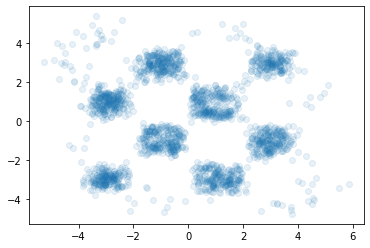

In [88]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

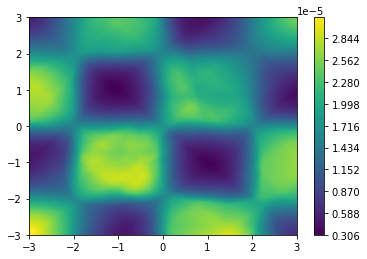

In [89]:
pdf = make_pdf_energy(checkerboard_model)

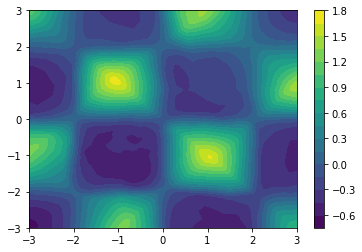

In [90]:
create_contour_plot_tensorflow(checkerboard_model)

### Line dataset

In [91]:
batch_size = 5000
rng = np.random.RandomState()
x = rng.rand(batch_size) * 5 - 2.5
y = x
line_train = np.stack((x, y), 1)

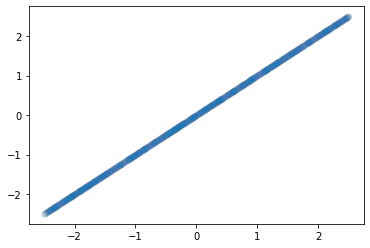

In [92]:
plt.scatter(line_train[:, 0], line_train[:, 1], alpha=0.01)

Unfortunately, KDE does not work on this dataset, because it results in a singular matrix.

In [93]:
input_ = keras.layers.Input(shape=line_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
line_model = keras.Model(inputs=[input_], outputs=[output])

In [94]:
ebm = EBM(line_model)

In [95]:
optimizer = keras.optimizers.Adam(1e-3)
ebm.fit(line_train, 128, 30, optimizer, [-4.5, -4.5], [4.5, 4.5], num_steps_markov=tf.constant(25),
        std_dev=0.5, step_size=0.1, callbacks_energy=[],
        alpha=0.5, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.0023898233970006304
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.03740237615047357
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.021693218977023393
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.0008289699371044452
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.004077363090637403
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.010785420735677082
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.01679795063458956
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.024715133202381622
Epoch progress: 023.04%
Average absolute energy differe

Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.04148956139882405
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04107133547465006
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.039710466678325944
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.03943473559159499
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.03978887582436586
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04132842406248435
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.0413287144440871
Epoch 2: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.03883277452909029
Epoch progress: 005.12%
Average absolute energy difference betw

Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.05021998821160732
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.04926184507516714
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.04969598085452349
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.04887810731545473
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.048592542990660056
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.04925728149903126
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.04982472994388678
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.04955160923493214
Epoch progress: 087.04%
Average absolute energy difference between training and

Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.04944480076814309
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.04841044621589856
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.0498808408394838
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.05021974062308287
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.0509798098833133
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.04967242632156763
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.050057524289840304
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.04922814858265412
Epoch progress: 071.68%
Average absolute energy difference between training and t

Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.05062754031939384
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.05086284417372483
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.05067512622246375
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.04913022273626083
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.05006274198874449
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.05026717675037873
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.04978188490256285
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.04977900553972293
Epoch progress: 056.32%
Average absolute energy difference between training and 

Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.051447984499809064
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.050670538193140276
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.04870013701610076
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.05109592890128111
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.05135717758765587
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.050889247503036104
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.049106548994015425
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.0498429720218365
Epoch progress: 043.52%
Average absolute energy difference between training a

Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.05434637803297776
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.04982818701328375
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.04780335915394318
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.05097098839588654
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.052595982184776895
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.049680966597336985
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.050216491405780495
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0509875707137279
Epoch progress: 028.16%
Average absolute energy difference between training an

Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.05221728178171011
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.04964780807495117
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04913084934919308
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.051793599740052834
Epoch 13: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.052172232896853715
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.05056295639429337
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.047936139962612055
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.04878119933299529
Epoch progress: 012.80%
Average absolute energy difference 

Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.05110896550692045
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.049874898714896955
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.05079627954042875
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.052072928502009466
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.05135198739858774
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.05133548149695763
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.04999089241027832
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.05008128361824231
Epoch progress: 097.28%
Average absolute energy difference between training an

Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.05061690929608467
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.049972399687155694
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.049647386257465065
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0503320541137304
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.05151654512454302
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.04945330436413105
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.04936661781408848
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.05255426504673102
Epoch progress: 081.92%
Average absolute energy difference between training and

Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.051752457251915567
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.050205942911979475
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.05088240672380496
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.05248877941033779
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.04926545192033816
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.048282806689922624
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.05190494732979016
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.051407948518410705
Epoch progress: 064.00%
Average absolute energy difference between training 

Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.04991403604165102
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.04873179166744917
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.051522040978456154
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.053281417259803183
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.050794170452998236
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.049199678958990634
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.050965070724487305
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.052298723123012446
Epoch progress: 046.08%
Average absolute energy difference between trainin

Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.050551860760419794
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.04849641139690693
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.05102256933848063
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.05231148157364283
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.051435103783240683
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.04922043360196627
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.05036320441808456
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.05185653613163874
Epoch progress: 030.72%
Average absolute energy difference between training an

Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.049440775162134416
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.049943300393911504
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.05048845975826948
Epoch 24: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.05077466597923865
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.04987747241289187
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.05300325613755446
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.05137867193955641
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.048317310137626454
Epoch progress: 015.36%
Average absolute energy difference 

Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.054193087113209255
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.05076446900000939
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.04714171703045185
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.05065406285799467
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.05332785997635279
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.05113254754971235
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.048438610174717046
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.047858947362655245
Epoch progress: 097.28%
Average absolute energy difference between training a

Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.0504768934005346
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.050172191399794355
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.05091288456550011
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.0514681400396885
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.05063974551665477
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.05009080813481257
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.05036467466598902
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.05145074159671099
Epoch progress: 081.92%
Average absolute energy difference between training and t

Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.05041730098235301
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.05224922375801282
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.05203736134064503
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.05076589645483555
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.050153603920569785
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.05093559852013221
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.05195456896072779
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.05188977412688426
Epoch progress: 066.56%
Average absolute energy difference between training and

In [96]:
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-1, maxval=1)
sample = sgld_sample(line_model, x_init, tf.constant(50), 500, 0.05, clip_thresh=tf.constant(0.005))

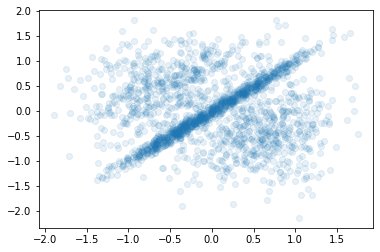

In [97]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

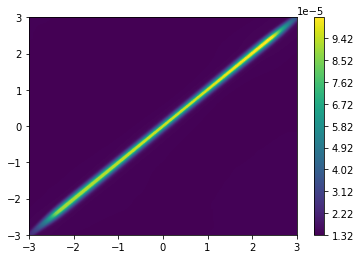

In [98]:
pdf = make_pdf_energy(line_model)

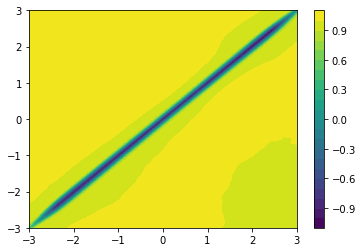

In [99]:
create_contour_plot_tensorflow(line_model)

### Cosine dataset

In [100]:
batch_size = 5000
rng = np.random.RandomState()
x = rng.rand(batch_size) * 5 - 2.5
y = np.sin(x) * 2.5
cosine_train = np.stack((x, y), 1)

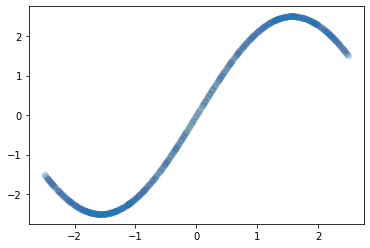

In [101]:
plt.scatter(cosine_train[:, 0], cosine_train[:, 1], alpha=0.01)

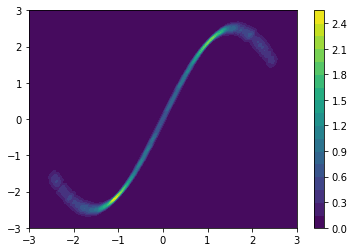

In [102]:
pdf_kde = make_pdf_data(cosine_train, bw_method=0.05)

In [103]:
input_ = keras.layers.Input(shape=cosine_train.shape[1:])
hidden_1 = keras.layers.Dense(1000, activation="relu")(input_)
hidden_2 = keras.layers.Dense(1000, activation="relu")(hidden_1)
output = keras.layers.Dense(1)(hidden_2)
cosine_model = keras.Model(inputs=[input_], outputs=[output])

In [104]:
ebm = EBM(cosine_model)

In [105]:
optimizer = keras.optimizers.Adam(1e-3)
ebm.fit(cosine_train, 128, 30, optimizer, [-3, -3], [3, 3], num_steps_markov=tf.constant(25),
        std_dev=0.5, step_size=0.1, callbacks_energy=[],
        alpha=0.5, clip_thresh=tf.constant(1.0))

Epoch 0: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.00029976775821967004
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.022804546050536327
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.01603516095723861
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.004364177202567076
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.007677722435731154
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.01349411102441641
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.01760734961583064
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.021201543318919647
Epoch progress: 023.04%
Average absolute energy differen

Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.035077785834287986
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.03754477011851775
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.035230349271725386
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.03645585744808882
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.0364084671705197
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.037786453198163934
Epoch 2: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.03782552022200364
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.03535775954906757
Epoch progress: 007.68%
Average absolute energy difference be

Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.04285289996709579
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.045345055751311474
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.04549300670623779
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.045015704937470265
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.04326937443170792
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.041343539189069696
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04157124421535394
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.04288173638857328
Epoch progress: 092.16%
Average absolute energy difference between training a

Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.04767812826694586
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.044427339847271256
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.04367300791618151
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.042312423388163246
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.04536568812834911
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.046645329548762396
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.0500495494940342
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.04807162284851074
Epoch progress: 076.80%
Average absolute energy difference between training an

Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.04877356382516714
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.04968899946946364
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.04667074252397586
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.04496961373549241
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.04675865173339844
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.04789220981108837
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.05137284596761067
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.04884126858833508
Epoch progress: 064.00%
Average absolute energy difference between training and 

Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0442737218661186
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.045473263813899115
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.04745799455887232
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.047754862369635165
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.04778100282717974
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.04743110216580904
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.04665738497024927
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.04567590126624474
Epoch progress: 046.08%
Average absolute energy difference between training and

Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.049270565693195045
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.051253569431793995
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.04841721974886381
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.04514468021881886
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.04500849124712822
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.04609184081737812
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.04783576268416184
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.049780112046461836
Epoch progress: 030.72%
Average absolute energy difference between training a

Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.04903904596964518
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04965394582503881
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.04935720028021397
Epoch 13: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.04699489703545203
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.04701587481376452
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.049068918594947226
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.04923523389376127
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.04852909919543144
Epoch progress: 015.36%
Average absolute energy difference be

Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.050382424623538286
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.052173987413064025
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.04888516206007737
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04628728597592085
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.04587940375010172
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.048905653831286304
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.04733685958079802
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04564449114677233
Epoch progress: 099.84%
Average absolute energy difference between training a

Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.04749746811695588
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.04760931088374211
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.04919890562693278
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.05001921225816775
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.048994198823586486
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.04710973531771929
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.04677539605360764
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.049729182169987604
Epoch progress: 084.48%
Average absolute energy difference between training an

Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.048808981210757524
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.049485114904550404
Epoch progress: 051.20%
Average absolute energy difference between training and test examples: 0.04896103418790377
Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.04871674073048127
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.04864380298516689
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.04766302842360276
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.04846669771732428
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.04850893142895821
Epoch progress: 066.56%
Average absolute energy difference between training an

Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.047938450788840264
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.047855511689797424
Epoch progress: 035.84%
Average absolute energy difference between training and test examples: 0.048929813580635265
Epoch progress: 038.40%
Average absolute energy difference between training and test examples: 0.04972254312955416
Epoch progress: 040.96%
Average absolute energy difference between training and test examples: 0.0484998929194915
Epoch progress: 043.52%
Average absolute energy difference between training and test examples: 0.04929688954964662
Epoch progress: 046.08%
Average absolute energy difference between training and test examples: 0.04856604184859838
Epoch progress: 048.64%
Average absolute energy difference between training and test examples: 0.04923085065988394
Epoch progress: 051.20%
Average absolute energy difference between training an

Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.046696335841447875
Epoch progress: 017.92%
Average absolute energy difference between training and test examples: 0.04604487235729511
Epoch progress: 020.48%
Average absolute energy difference between training and test examples: 0.04706328343122433
Epoch progress: 023.04%
Average absolute energy difference between training and test examples: 0.04986796929286076
Epoch progress: 025.60%
Average absolute energy difference between training and test examples: 0.0500419904024173
Epoch progress: 028.16%
Average absolute energy difference between training and test examples: 0.049573204456231534
Epoch progress: 030.72%
Average absolute energy difference between training and test examples: 0.05016049360617613
Epoch progress: 033.28%
Average absolute energy difference between training and test examples: 0.051855417398306035
Epoch progress: 035.84%
Average absolute energy difference between training an

Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.04894531690157377
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.05012015807322966
Epoch 24: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.05092526093507424
Epoch progress: 005.12%
Average absolute energy difference between training and test examples: 0.04950554859943879
Epoch progress: 007.68%
Average absolute energy difference between training and test examples: 0.04825528462727864
Epoch progress: 010.24%
Average absolute energy difference between training and test examples: 0.04997583536001352
Epoch progress: 012.80%
Average absolute energy difference between training and test examples: 0.04991567134857178
Epoch progress: 015.36%
Average absolute energy difference between training and test examples: 0.048491380153558195
Epoch progress: 017.92%
Average absolute energy difference be

Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.04814036687215169
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04857445985842974
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.04805073065635485
Epoch progress: 092.16%
Average absolute energy difference between training and test examples: 0.048256632609245106
Epoch progress: 094.72%
Average absolute energy difference between training and test examples: 0.04843627489530123
Epoch progress: 097.28%
Average absolute energy difference between training and test examples: 0.05038710740896372
Epoch progress: 099.84%
Average absolute energy difference between training and test examples: 0.048744317812797346
Epoch 26: 000.00%
Epoch progress: 002.56%
Average absolute energy difference between training and test examples: 0.04707743877019638
Epoch progress: 005.12%
Average absolute energy difference b

Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.050030152002970375
Epoch progress: 074.24%
Average absolute energy difference between training and test examples: 0.04983398547539344
Epoch progress: 076.80%
Average absolute energy difference between training and test examples: 0.04834217291611891
Epoch progress: 079.36%
Average absolute energy difference between training and test examples: 0.048524483656271905
Epoch progress: 081.92%
Average absolute energy difference between training and test examples: 0.04978368832514836
Epoch progress: 084.48%
Average absolute energy difference between training and test examples: 0.05072600719256279
Epoch progress: 087.04%
Average absolute energy difference between training and test examples: 0.04832815512632712
Epoch progress: 089.60%
Average absolute energy difference between training and test examples: 0.048707097004621454
Epoch progress: 092.16%
Average absolute energy difference between training a

Epoch progress: 053.76%
Average absolute energy difference between training and test examples: 0.048680048722487226
Epoch progress: 056.32%
Average absolute energy difference between training and test examples: 0.04730400060996031
Epoch progress: 058.88%
Average absolute energy difference between training and test examples: 0.049096061633183405
Epoch progress: 061.44%
Average absolute energy difference between training and test examples: 0.051555670224703275
Epoch progress: 064.00%
Average absolute energy difference between training and test examples: 0.052933986370380104
Epoch progress: 066.56%
Average absolute energy difference between training and test examples: 0.048203012882134855
Epoch progress: 069.12%
Average absolute energy difference between training and test examples: 0.04473266846094376
Epoch progress: 071.68%
Average absolute energy difference between training and test examples: 0.04854934643476437
Epoch progress: 074.24%
Average absolute energy difference between training

In [106]:
batch_size = 2000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(cosine_model, x_init, tf.constant(50), 100, 0.05, clip_thresh=tf.constant(0.05))

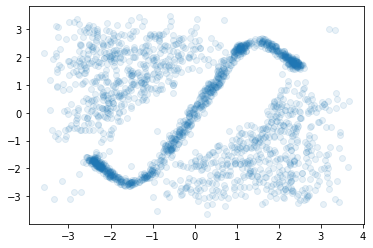

In [107]:
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1)

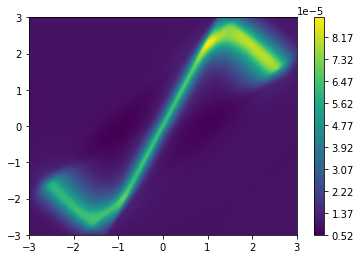

In [108]:
pdf = make_pdf_energy(cosine_model)

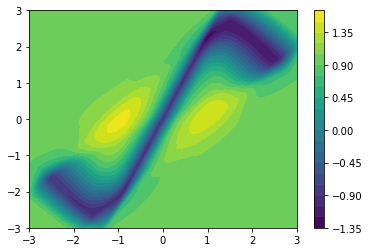

In [109]:
create_contour_plot_tensorflow(cosine_model)